In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-CosineAnnealingWarmRestarts2
Time: Tue Nov 17 10:58:20 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

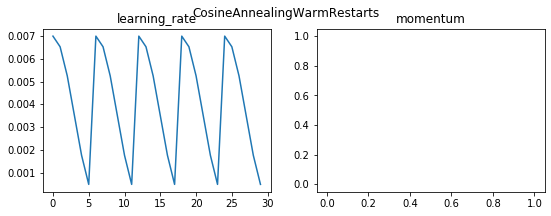

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': 6,
    'T_mult': 1, 
    'eta_min': 1e-5
    
}

CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    #
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam, LookaheadDiffGrad, LookaheadYogi, RangerLars
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.01997335490967934
epoch2 save best model... 0.018528214878570246
epoch3 save best model... 0.01793817650942569
epoch4 save best model... 0.017399388328534052
epoch5 save best model... 0.017038239887438224
epoch6 save best model... 0.016810225607967324
epoch11 save best model... 0.016510302164424253
epoch12 save best model... 0.0163228392728301
epoch18 save best model... 0.016281985537762115
fold0 score: 0.016281985441905306


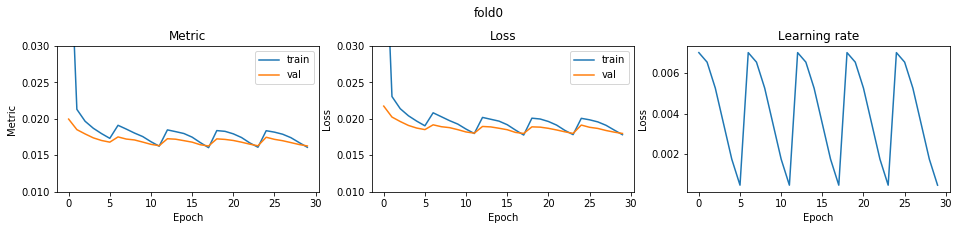

fold 1


epoch1 save best model... 0.019982157220334446
epoch2 save best model... 0.018719210220031028
epoch3 save best model... 0.017934782613441433
epoch4 save best model... 0.01758004448532135
epoch5 save best model... 0.01723064785141232
epoch6 save best model... 0.01698753018909121
epoch11 save best model... 0.016811874830926856
epoch12 save best model... 0.016622484058156986
epoch18 save best model... 0.016590470858945286
epoch24 save best model... 0.01655092605725559
epoch30 save best model... 0.016514683566269447
fold1 score: 0.01651468365638978


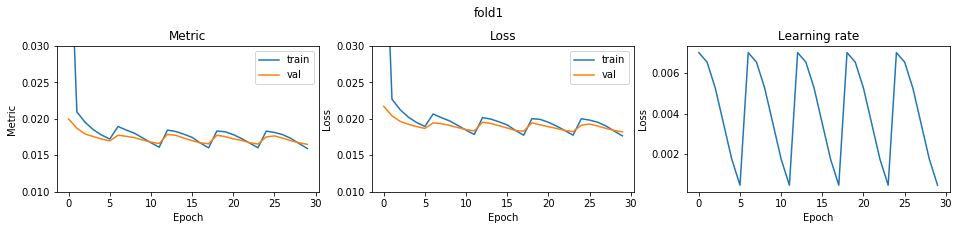

fold 2


epoch1 save best model... 0.020386184270984493
epoch2 save best model... 0.018662028572731963
epoch3 save best model... 0.01795684855739425
epoch4 save best model... 0.01754990745103252
epoch5 save best model... 0.017110322076274734
epoch6 save best model... 0.016911280785569926
epoch11 save best model... 0.0166023512018429
epoch12 save best model... 0.016444180719045156
epoch18 save best model... 0.016346858350925468
epoch24 save best model... 0.016329360426220883
epoch30 save best model... 0.016292890570090188
fold2 score: 0.016292890468138966


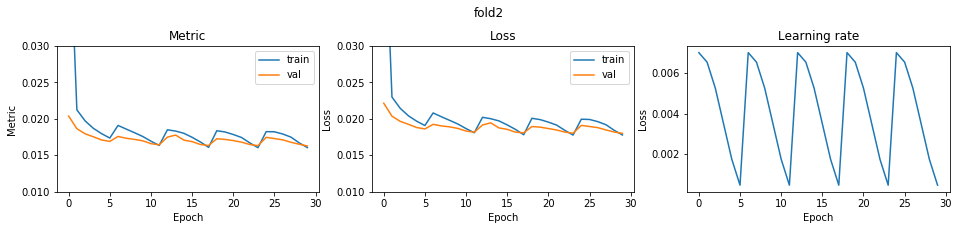

fold 3


epoch1 save best model... 0.020116573967599652
epoch2 save best model... 0.01886099380417674
epoch3 save best model... 0.01809100060000303
epoch4 save best model... 0.01760134873466231
epoch5 save best model... 0.017240075799286502
epoch6 save best model... 0.017081648635344924
epoch11 save best model... 0.016848772716260854
epoch12 save best model... 0.01662394772909565
epoch18 save best model... 0.016548199726773558
epoch24 save best model... 0.0164989922895756
epoch30 save best model... 0.01646057452819817
fold3 score: 0.0164605744859912


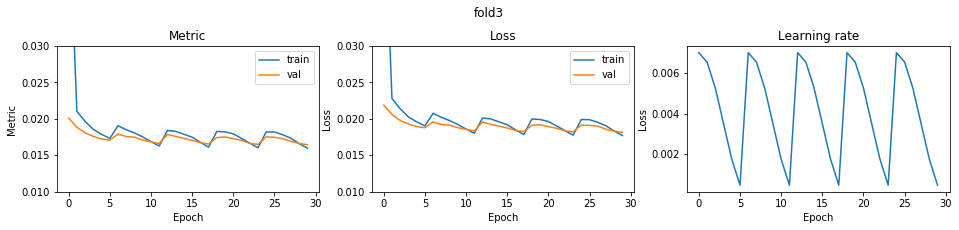

fold 4


epoch1 save best model... 0.019677845031396402
epoch2 save best model... 0.01843696871522076
epoch3 save best model... 0.017858388621130945
epoch4 save best model... 0.017536731592139785
epoch5 save best model... 0.017160188486472893
epoch6 save best model... 0.016975282847558854
epoch11 save best model... 0.016626673489215028
epoch12 save best model... 0.016502640299617836
epoch24 save best model... 0.016457546028841058
epoch30 save best model... 0.016432446675430264
fold4 score: 0.016431680653669085


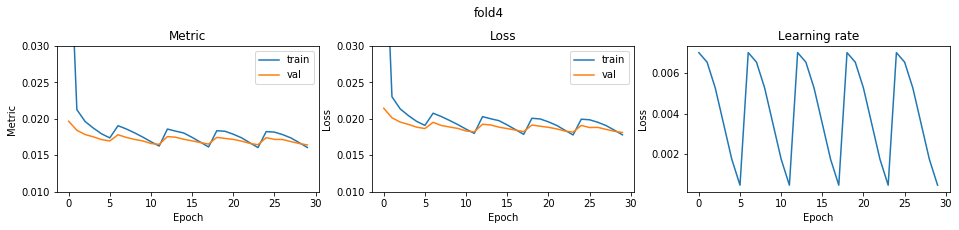

CV score: 0.01639636226469973

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.02016094075876515
epoch2 save best model... 0.019434695976843594
epoch3 save best model... 0.018312513072187918
epoch4 save best model... 0.01773291213145153
epoch5 save best model... 0.01736287327148105
epoch6 save best model... 0.017165334878281473
epoch9 save best model... 0.01698941173613207
epoch10 save best model... 0.01673471891577939
epoch11 save best model... 0.016583939330707516
epoch12 save best model... 0.016436640800725762
epoch16 save best model... 0.016409693220481785
epoch17 save best model... 0.016252662588106065
epoch18 save best model... 0.0161539037234589
epoch23 save best model... 0.016141207033772538
epoch24 save best model... 0.016103693754210696
fold0 score: 0.01610369367076553


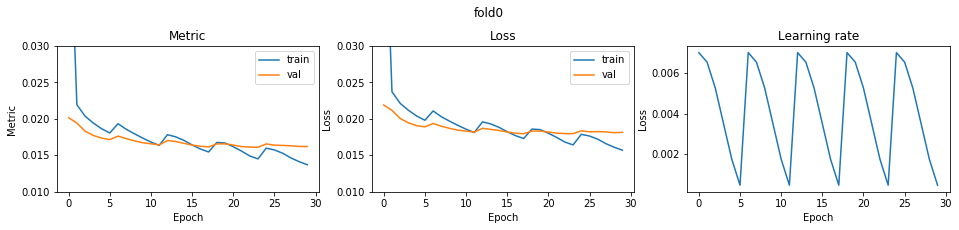

fold 1


epoch1 save best model... 0.02022293321346946
epoch2 save best model... 0.01908877643627766
epoch3 save best model... 0.018417691109554726
epoch4 save best model... 0.017934235994780244
epoch5 save best model... 0.01749489468382958
epoch6 save best model... 0.017324001059584586
epoch9 save best model... 0.017252765319211032
epoch10 save best model... 0.016962058778523748
epoch11 save best model... 0.016788219150531792
epoch12 save best model... 0.01663909455488431
epoch17 save best model... 0.016489863161640153
epoch18 save best model... 0.016469637800740556
fold1 score: 0.016469637773021902


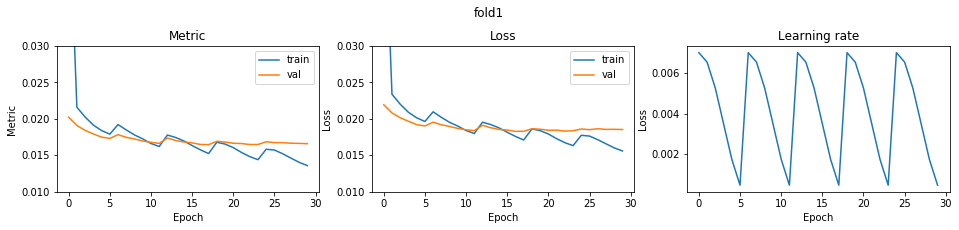

fold 2


epoch1 save best model... 0.02026617993305928
epoch2 save best model... 0.01897341777534685
epoch3 save best model... 0.018261247728928995
epoch4 save best model... 0.017676650139077307
epoch5 save best model... 0.017260543765883412
epoch6 save best model... 0.017131196357026326
epoch10 save best model... 0.01683261518074443
epoch11 save best model... 0.01653181938558484
epoch12 save best model... 0.016475323739163043
epoch16 save best model... 0.01640696933046985
epoch17 save best model... 0.016315174134145582
epoch18 save best model... 0.016244380026342767
fold2 score: 0.01624437995761785


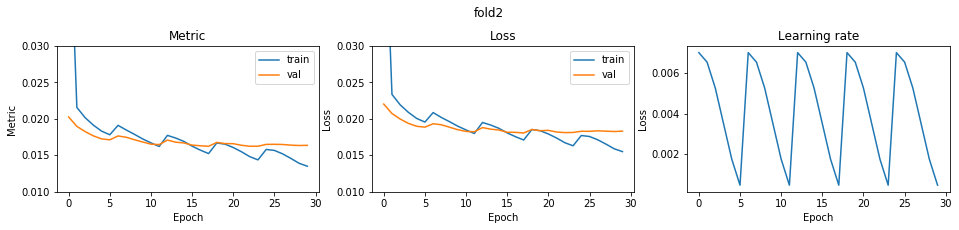

fold 3


epoch1 save best model... 0.020255001690790295
epoch2 save best model... 0.019434455300178507
epoch3 save best model... 0.018572432097633092
epoch4 save best model... 0.01801205958347929
epoch5 save best model... 0.01770757972676485
epoch6 save best model... 0.017485300585593614
epoch9 save best model... 0.01739226627017208
epoch10 save best model... 0.017097724245644784
epoch11 save best model... 0.01682238848094992
epoch12 save best model... 0.01673452197775618
epoch16 save best model... 0.016723065769431396
epoch17 save best model... 0.01660405354434306
epoch18 save best model... 0.016493302860333327
epoch23 save best model... 0.016428086145914633
epoch24 save best model... 0.01639873595327003
fold3 score: 0.016398735931077622


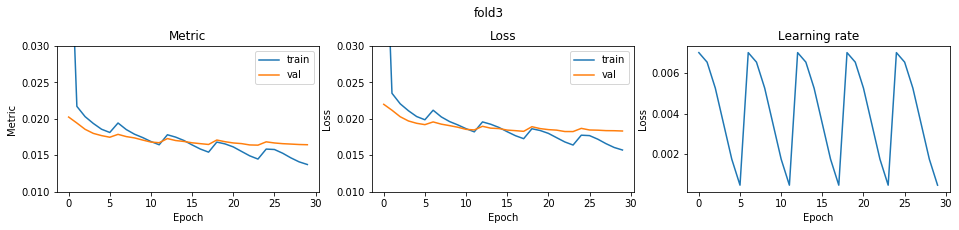

fold 4


epoch1 save best model... 0.020203176831533807
epoch2 save best model... 0.0188346627335953
epoch3 save best model... 0.018041804284366497
epoch4 save best model... 0.0177272941098296
epoch5 save best model... 0.017364457023917677
epoch6 save best model... 0.017219172343866294
epoch9 save best model... 0.01710696836852878
epoch10 save best model... 0.016888461708767948
epoch11 save best model... 0.016671237218828027
epoch12 save best model... 0.016591563296837388
epoch17 save best model... 0.016466235167056253
epoch18 save best model... 0.016362304500132326
epoch24 save best model... 0.016356245460994286
fold4 score: 0.016356245397557544


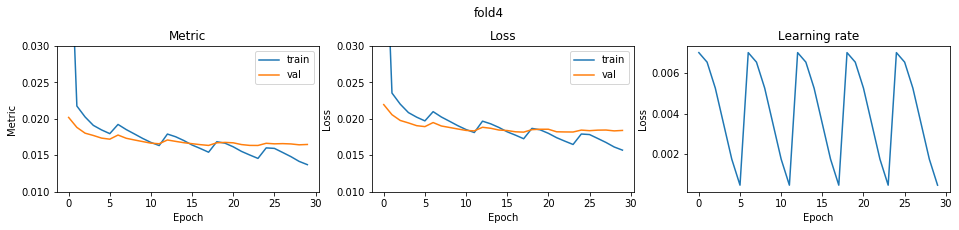

CV score: 0.016314534675922497

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.6986394960407787
epoch2 save best model... 0.6777646945929473
epoch3 save best model... 0.6582245149753632
epoch4 save best model... 0.6449905968472734
epoch5 save best model... 0.6426569611445103
epoch6 save best model... 0.6423479049786891
epoch7 save best model... 0.5433347107609203
epoch8 save best model... 0.4069067855766531
epoch9 save best model... 0.3121043049257274
epoch10 save best model... 0.2762263826465824
epoch11 save best model... 0.27020301916604705
epoch12 save best model... 0.26762008199930737
epoch13 save best model... 0.1569328506810247
epoch14 save best model... 0.10020838371374069
epoch15 save best model... 0.07682975094790882
epoch16 save best model... 0.06937513207859765
epoch17 save best model... 0.06550849744358475
epoch19 save best model... 0.042489983319625224
epoch20 save best model... 0.03308595491908406
epoch21 save best model... 0.029340641690176278
epoch22 save best model... 0.028025280370256082
epoch23 save best model... 0.0

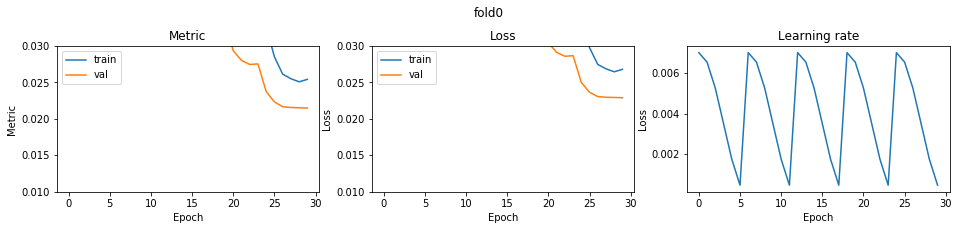

fold 1


epoch1 save best model... 0.6987729593245688
epoch2 save best model... 0.6781640192945771
epoch3 save best model... 0.6585058043393657
epoch4 save best model... 0.6465972721590271
epoch5 save best model... 0.641406530099731
epoch6 save best model... 0.638546191537861
epoch7 save best model... 0.5431290284651346
epoch8 save best model... 0.4061096475686047
epoch9 save best model... 0.3135826781470185
epoch10 save best model... 0.2784594237790832
epoch11 save best model... 0.27066428038953894
epoch12 save best model... 0.26842375369570637
epoch13 save best model... 0.15522885243464613
epoch14 save best model... 0.10094896004394997
epoch15 save best model... 0.07633702795613896
epoch16 save best model... 0.06789729757946156
epoch17 save best model... 0.064971656887182
epoch19 save best model... 0.04173301477863702
epoch20 save best model... 0.03316374334187762
epoch21 save best model... 0.028889838738104263
epoch22 save best model... 0.027701014454658387
epoch23 save best model... 0.02745

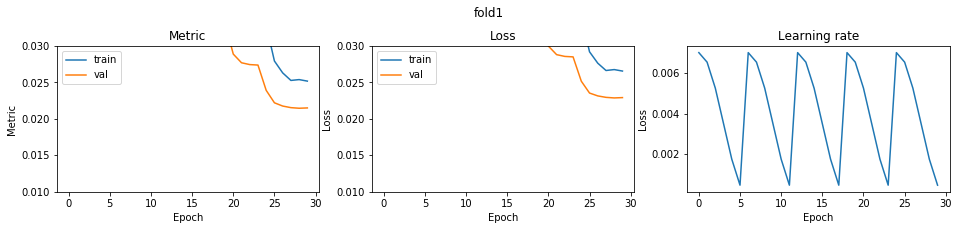

fold 2


epoch1 save best model... 0.7053302111455101
epoch2 save best model... 0.6826197214239577
epoch3 save best model... 0.6635019278086299
epoch4 save best model... 0.6499930389733053
epoch5 save best model... 0.6470002985592719
epoch6 save best model... 0.6469409344787884
epoch7 save best model... 0.5463527885920694
epoch8 save best model... 0.40759510353231354
epoch9 save best model... 0.31828330471809535
epoch10 save best model... 0.2782573530874428
epoch11 save best model... 0.2668695815550925
epoch13 save best model... 0.15582700366717478
epoch14 save best model... 0.0972374762790598
epoch15 save best model... 0.07382800934403816
epoch16 save best model... 0.06587785903400917
epoch17 save best model... 0.0654384245322353
epoch19 save best model... 0.04195696047082201
epoch20 save best model... 0.032209165255955234
epoch21 save best model... 0.029087562439507005
epoch22 save best model... 0.027747044838009213
epoch23 save best model... 0.027369260425110915
epoch25 save best model... 0.

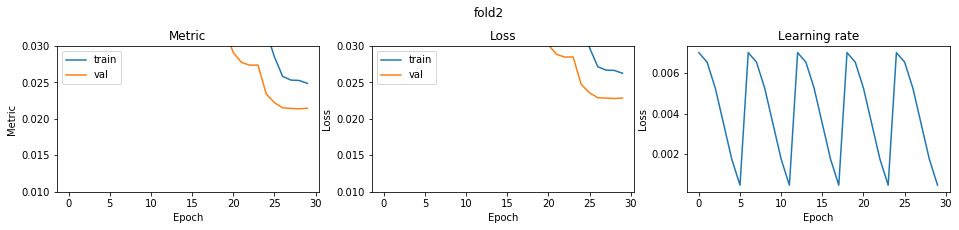

fold 3


epoch1 save best model... 0.6899720524329531
epoch2 save best model... 0.6722444195410657
epoch3 save best model... 0.6516298890656925
epoch4 save best model... 0.6395483725434827
epoch5 save best model... 0.6353222917044081
epoch7 save best model... 0.5374831969482752
epoch8 save best model... 0.40071227224649764
epoch9 save best model... 0.3103550896150376
epoch10 save best model... 0.2767631950709706
epoch11 save best model... 0.26197157701761686
epoch13 save best model... 0.15262046335498403
epoch14 save best model... 0.09889904317660321
epoch15 save best model... 0.07451871510654484
epoch16 save best model... 0.06755498590495157
epoch17 save best model... 0.0660392384662172
epoch18 save best model... 0.06386772924546229
epoch19 save best model... 0.042822964856048924
epoch20 save best model... 0.032467680890325264
epoch21 save best model... 0.0294381765686909
epoch22 save best model... 0.027717631918660328
epoch25 save best model... 0.023782420323860402
epoch26 save best model... 

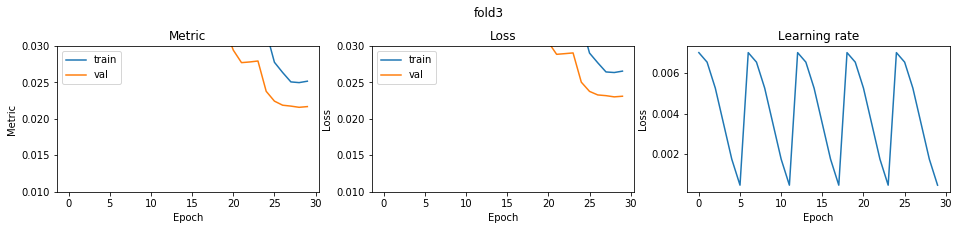

fold 4


epoch1 save best model... 0.6979974945748314
epoch2 save best model... 0.6793856424459835
epoch3 save best model... 0.6604123619802992
epoch4 save best model... 0.6465283163316158
epoch5 save best model... 0.6429915031974027
epoch6 save best model... 0.6419238136135093
epoch7 save best model... 0.5443640091967745
epoch8 save best model... 0.40692149115586335
epoch9 save best model... 0.31274775720131426
epoch10 save best model... 0.2760246630410127
epoch11 save best model... 0.27079761320203205
epoch12 save best model... 0.26686498096429134
epoch13 save best model... 0.15241450317764066
epoch14 save best model... 0.09710821394293075
epoch15 save best model... 0.07387511101222527
epoch16 save best model... 0.06721602087174298
epoch17 save best model... 0.06387255453846177
epoch19 save best model... 0.042394700337515336
epoch20 save best model... 0.03196925543384427
epoch21 save best model... 0.028648668360431808
epoch22 save best model... 0.02719799272444498
epoch23 save best model... 0

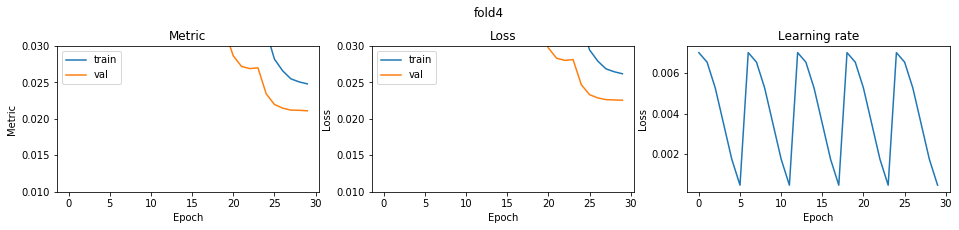

CV score: 0.021404478452200514

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.02023797596641445
epoch2 save best model... 0.01895204783928557
epoch3 save best model... 0.018273947467700766
epoch4 save best model... 0.01767562794539407
epoch5 save best model... 0.017414188343429077
epoch6 save best model... 0.01715092970172881
epoch9 save best model... 0.017058271179845503
epoch10 save best model... 0.016861072942139347
epoch11 save best model... 0.01660988219167214
epoch12 save best model... 0.01650297941304828
epoch16 save best model... 0.016433886389814505
epoch17 save best model... 0.016252192461561912
epoch18 save best model... 0.01619763382941756
epoch24 save best model... 0.01619364091816755
fold0 score: 0.016193640842631158


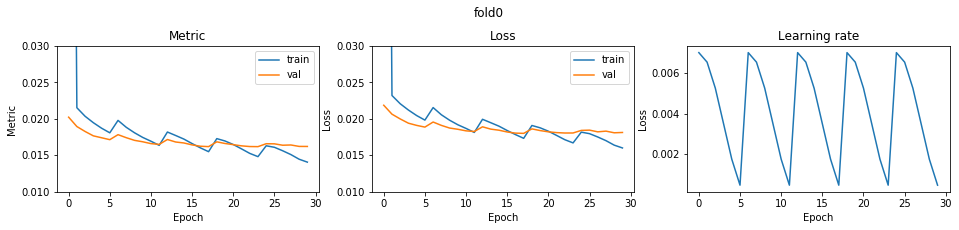

fold 1


epoch1 save best model... 0.020514993892936345
epoch2 save best model... 0.018912586912098576
epoch3 save best model... 0.018330997431989845
epoch4 save best model... 0.017702111876748992
epoch5 save best model... 0.017482516675165587
epoch6 save best model... 0.01723683250214549
epoch10 save best model... 0.01701723573117002
epoch11 save best model... 0.016753162415458392
epoch12 save best model... 0.0166555775251383
epoch17 save best model... 0.016540164430535555
epoch18 save best model... 0.01645646164162769
epoch24 save best model... 0.016435402082642176
fold1 score: 0.016435402137099514


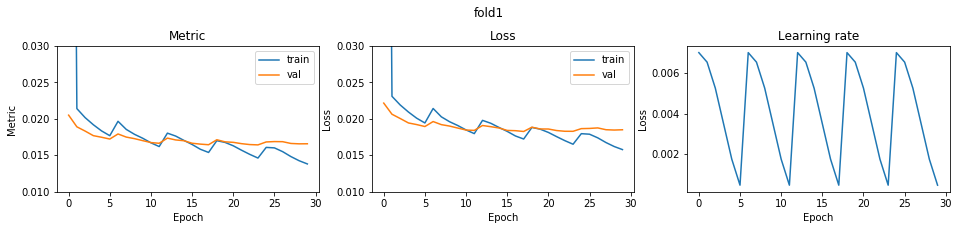

fold 2


epoch1 save best model... 0.020285976014303087
epoch2 save best model... 0.019150828288248038
epoch3 save best model... 0.018435958130159948
epoch4 save best model... 0.017789610584539577
epoch5 save best model... 0.017339884560690175
epoch6 save best model... 0.01708281291981891
epoch10 save best model... 0.016819260777864418
epoch11 save best model... 0.01651623964268951
epoch12 save best model... 0.01645455748079598
epoch17 save best model... 0.016342128418627037
epoch18 save best model... 0.016203458910889874
fold2 score: 0.01620345880552467


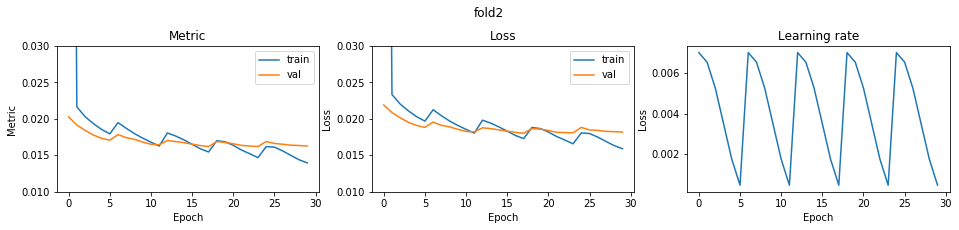

fold 3


epoch1 save best model... 0.02038892966468133
epoch2 save best model... 0.019130236127653535
epoch3 save best model... 0.01834903608006266
epoch4 save best model... 0.01791348272641794
epoch5 save best model... 0.017434491534083062
epoch6 save best model... 0.017282287810837897
epoch10 save best model... 0.017028152752998613
epoch11 save best model... 0.0168121143093583
epoch12 save best model... 0.016630521662753917
epoch17 save best model... 0.016523124592841214
epoch18 save best model... 0.01644876977950674
epoch24 save best model... 0.016411493718199822
epoch30 save best model... 0.016409358683897177
fold3 score: 0.016409358495908986


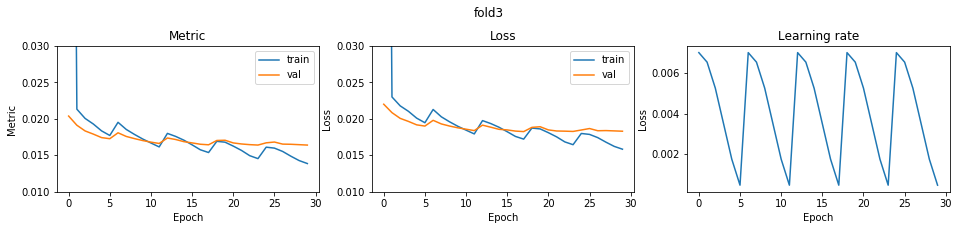

fold 4


epoch1 save best model... 0.019924342611079063
epoch2 save best model... 0.018628013064418674
epoch3 save best model... 0.01805259873178323
epoch4 save best model... 0.01770452251169907
epoch5 save best model... 0.017208147583983348
epoch6 save best model... 0.01703796988408291
epoch10 save best model... 0.01685158319066964
epoch11 save best model... 0.01670458896726302
epoch12 save best model... 0.01655145549259927
epoch17 save best model... 0.016478597744450752
epoch18 save best model... 0.016433911490973282
epoch23 save best model... 0.01640227259877127
epoch24 save best model... 0.016379118843559932
fold4 score: 0.01637911873076746


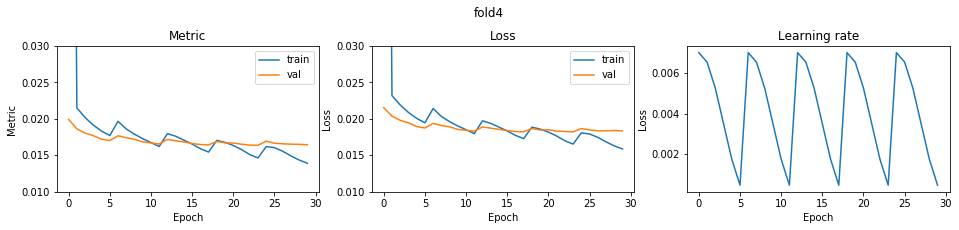

CV score: 0.016324196236624653

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021042830954414022
epoch2 save best model... 0.019532159092180548
epoch3 save best model... 0.018943200936723407
epoch4 save best model... 0.018188237913105646
epoch5 save best model... 0.01785258511611704
epoch6 save best model... 0.017657612016369378
epoch8 save best model... 0.01746771153410502
epoch9 save best model... 0.01706026132072159
epoch10 save best model... 0.01686532495114825
epoch11 save best model... 0.016630850548183456
epoch12 save best model... 0.016535035796582293
epoch16 save best model... 0.016400561750715848
epoch17 save best model... 0.016262493027132303
epoch18 save best model... 0.016236503451960777
epoch23 save best model... 0.01617169225703
epoch24 save best model... 0.016150957973491493
fold0 score: 0.01615095777419836


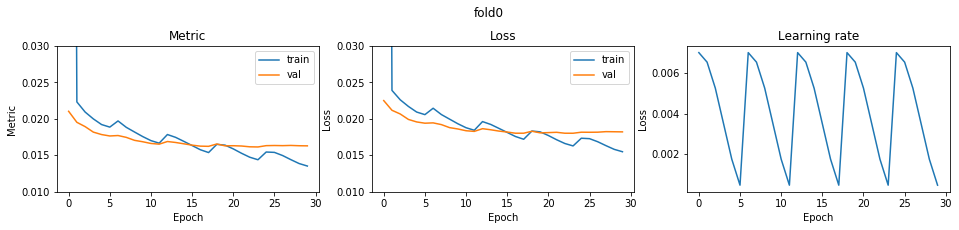

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02132210969045592
epoch2 save best model... 0.019706511275881404
epoch3 save best model... 0.01887356259453321
epoch4 save best model... 0.018430580767191986
epoch5 save best model... 0.01795024345600271
epoch6 save best model... 0.017809027611978452
epoch8 save best model... 0.017623821576884517
epoch9 save best model... 0.017206042247878906
epoch10 save best model... 0.017067362004999257
epoch11 save best model... 0.01684003901632032
epoch12 save best model... 0.016737145472103192
epoch16 save best model... 0.016668657212685577
epoch17 save best model... 0.016549075486197454
epoch18 save best model... 0.016495854271489658
epoch24 save best model... 0.016473037364098417
fold1 score: 0.01647303728781357


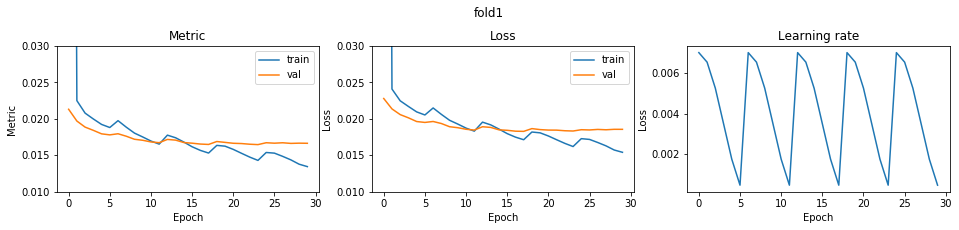

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021293279275851524
epoch2 save best model... 0.01968206356940114
epoch3 save best model... 0.018729703374611037
epoch4 save best model... 0.01808609169101316
epoch5 save best model... 0.017779239311841468
epoch6 save best model... 0.01758750014373764
epoch8 save best model... 0.017361153197880282
epoch9 save best model... 0.017115497736713968
epoch10 save best model... 0.01686373662914827
epoch11 save best model... 0.016688110593746263
epoch12 save best model... 0.016649688629691965
epoch15 save best model... 0.016622513985886447
epoch16 save best model... 0.016394827501730783
epoch17 save best model... 0.016290133031317273
epoch18 save best model... 0.016236383928587384
epoch24 save best model... 0.016231645101723365
fold2 score: 0.016231645079789622


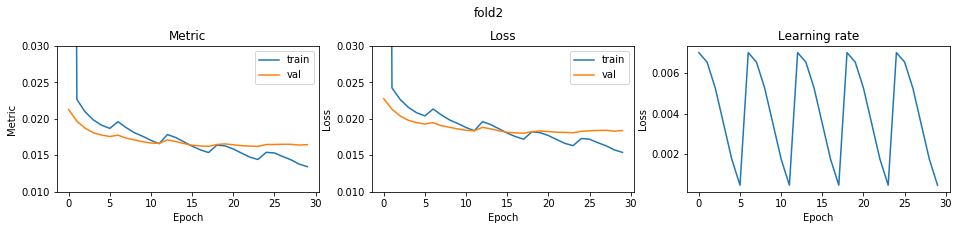

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021338181587992604
epoch2 save best model... 0.019735926631116785
epoch3 save best model... 0.019068021433754634
epoch4 save best model... 0.018412542319379256
epoch5 save best model... 0.018190756175403985
epoch6 save best model... 0.018037182146976097
epoch8 save best model... 0.017663139394635083
epoch9 save best model... 0.01743655668058197
epoch10 save best model... 0.017044599748435082
epoch11 save best model... 0.016959025658633144
epoch12 save best model... 0.016795069422649224
epoch16 save best model... 0.016692874897992694
epoch17 save best model... 0.01659679464647941
epoch18 save best model... 0.01654278719012789
epoch24 save best model... 0.01650754121176746
fold3 score: 0.016507541171264385


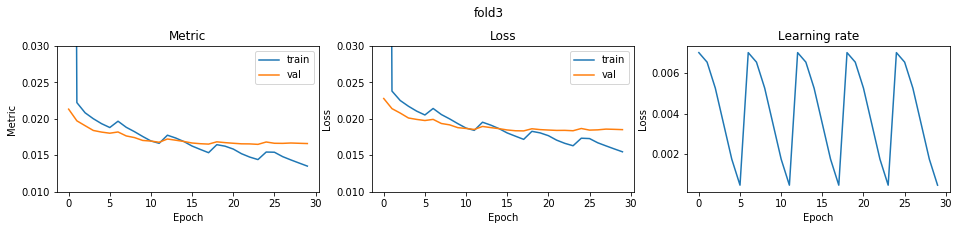

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020920515298877326
epoch2 save best model... 0.019326431304216386
epoch3 save best model... 0.018477047739682003
epoch4 save best model... 0.018003453517540575
epoch5 save best model... 0.017713069107493807
epoch6 save best model... 0.017588392483465085
epoch8 save best model... 0.017547675536559355
epoch9 save best model... 0.017194494493051108
epoch10 save best model... 0.01690335793034566
epoch11 save best model... 0.016812765968280394
epoch12 save best model... 0.016742585244289426
epoch15 save best model... 0.01672442187480883
epoch16 save best model... 0.016583442716415896
epoch17 save best model... 0.016477784630259104
epoch18 save best model... 0.016446355466809386
epoch23 save best model... 0.016445767470892173
epoch24 save best model... 0.01644491828545283
fold4 score: 0.01644491818663063


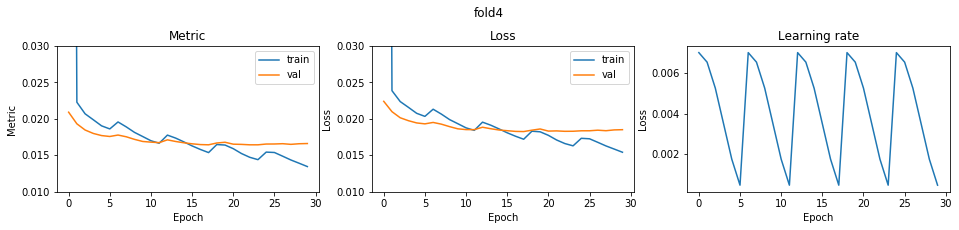

CV score: 0.016361620745457457

optimizer: AggMo
fold 0


epoch1 save best model... 0.2524226873230554
epoch2 save best model... 0.026701265189940947
epoch3 save best model... 0.023027159064023806
epoch4 save best model... 0.022186714547404125
epoch5 save best model... 0.021842801665933907
epoch6 save best model... 0.02175739749689037
epoch7 save best model... 0.021158823502464282
epoch8 save best model... 0.020764391447559576
epoch9 save best model... 0.02056242462357926
epoch10 save best model... 0.020447363519451343
epoch11 save best model... 0.020367542686522144
epoch12 save best model... 0.02035949184794768
epoch13 save best model... 0.02016592250207698
epoch14 save best model... 0.020006130587369
epoch15 save best model... 0.019805319396808643
epoch16 save best model... 0.01975508569771581
epoch17 save best model... 0.019733998490866603
epoch19 save best model... 0.01955018861978771
epoch20 save best model... 0.019473254722214235
epoch21 save best model... 0.01931873576584058
epoch22 save best model... 0.01925246302114804
epoch23 save b

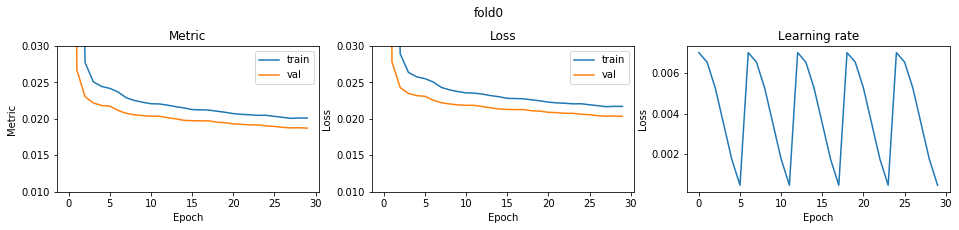

fold 1


epoch1 save best model... 0.2503138413649807
epoch2 save best model... 0.026706195404801045
epoch3 save best model... 0.023152567535353618
epoch4 save best model... 0.022294932467946567
epoch5 save best model... 0.021987554520253142
epoch6 save best model... 0.021911195234248514
epoch7 save best model... 0.021249131402894125
epoch8 save best model... 0.020889857205895226
epoch9 save best model... 0.02067782029197194
epoch10 save best model... 0.020583267241977808
epoch12 save best model... 0.02049550123166443
epoch13 save best model... 0.020272089687457633
epoch14 save best model... 0.020159973040830847
epoch15 save best model... 0.01998679725952764
epoch16 save best model... 0.0199123511655737
epoch17 save best model... 0.019863512304624874
epoch19 save best model... 0.019680725147459197
epoch20 save best model... 0.019578642459485682
epoch21 save best model... 0.019423196104555257
epoch22 save best model... 0.019342229008338506
epoch25 save best model... 0.019312381636165464
epoch26 

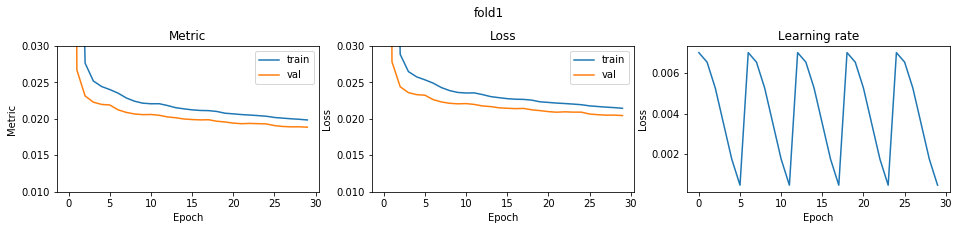

fold 2


epoch1 save best model... 0.23090664787427198
epoch2 save best model... 0.02611786168638178
epoch3 save best model... 0.022777624631130387
epoch4 save best model... 0.022044490098929483
epoch5 save best model... 0.02178742977970688
epoch6 save best model... 0.021742635287512514
epoch7 save best model... 0.021081569607334164
epoch8 save best model... 0.02075437226562531
epoch9 save best model... 0.02051838691305818
epoch10 save best model... 0.02035890635944127
epoch11 save best model... 0.020313910699448844
epoch13 save best model... 0.02025733157435564
epoch14 save best model... 0.01994791138924847
epoch15 save best model... 0.019788878101759604
epoch16 save best model... 0.01965919933155583
epoch18 save best model... 0.019622598056027684
epoch19 save best model... 0.019427950164452992
epoch20 save best model... 0.019334030808067372
epoch21 save best model... 0.019199393005941066
epoch22 save best model... 0.01916009607419497
epoch23 save best model... 0.019138922288463853
epoch24 sav

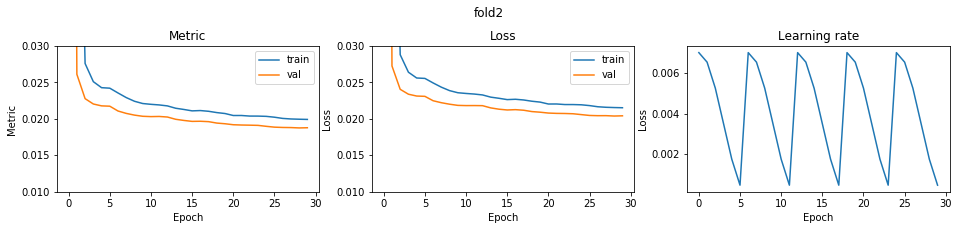

fold 3


epoch1 save best model... 0.2709293202007007
epoch2 save best model... 0.02706041070622029
epoch3 save best model... 0.023324456754096005
epoch4 save best model... 0.02232269094768988
epoch5 save best model... 0.0220016193026698
epoch6 save best model... 0.02197297704586407
epoch7 save best model... 0.021281222664753234
epoch8 save best model... 0.020877825667347614
epoch9 save best model... 0.02069474484194452
epoch10 save best model... 0.020555632959856122
epoch11 save best model... 0.0205329714270822
epoch12 save best model... 0.020514160804959665
epoch13 save best model... 0.020328071879770326
epoch14 save best model... 0.020170805483190914
epoch15 save best model... 0.020121117528095197
epoch16 save best model... 0.01999835298356339
epoch17 save best model... 0.01997774905251479
epoch19 save best model... 0.019828505810256834
epoch20 save best model... 0.019624773285655064
epoch21 save best model... 0.019487500136849686
epoch22 save best model... 0.019435175411521982
epoch23 save 

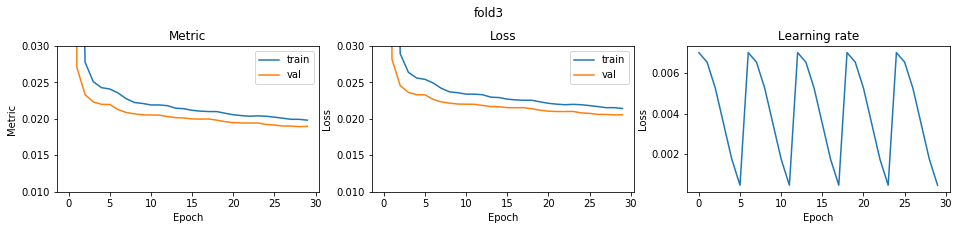

fold 4


epoch1 save best model... 0.24225699942312914
epoch2 save best model... 0.02614365450969997
epoch3 save best model... 0.022635980972973525
epoch4 save best model... 0.021881770072738237
epoch5 save best model... 0.02169506280069878
epoch6 save best model... 0.02156896050043557
epoch7 save best model... 0.02086512420691363
epoch8 save best model... 0.020572235229889733
epoch9 save best model... 0.02036079175702396
epoch10 save best model... 0.020219005393988722
epoch11 save best model... 0.020120070984158536
epoch13 save best model... 0.019927856170812067
epoch14 save best model... 0.01972283021820569
epoch15 save best model... 0.01960967535530652
epoch16 save best model... 0.01952831775102773
epoch17 save best model... 0.019496245905417518
epoch19 save best model... 0.019355624201357502
epoch20 save best model... 0.01925210347208184
epoch21 save best model... 0.019125604042295442
epoch22 save best model... 0.019045483066375817
epoch24 save best model... 0.01900222698706022
epoch25 save

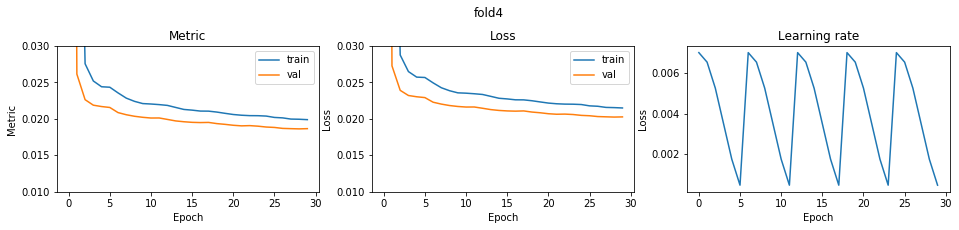

CV score: 0.01878627885725319

optimizer: Apollo
fold 0


epoch1 save best model... 0.704478277568122
epoch2 save best model... 0.696423783416357
epoch3 save best model... 0.6900957420094953
epoch4 save best model... 0.684496313211315
epoch6 save best model... 0.682338514523517
epoch7 save best model... 0.6734969757684
epoch8 save best model... 0.6684231008646971
epoch9 save best model... 0.6594101645680386
epoch10 save best model... 0.6549127068769416
epoch11 save best model... 0.6539042885591337
epoch12 save best model... 0.6537698791347495
epoch13 save best model... 0.6431298463382591
epoch14 save best model... 0.6339405994480455
epoch15 save best model... 0.6272419427956427
epoch16 save best model... 0.6193340292009515
epoch17 save best model... 0.6158742990200503
epoch19 save best model... 0.6022905203910515
epoch20 save best model... 0.5858027530694062
epoch21 save best model... 0.5745955608971841
epoch22 save best model... 0.5635812159551303
epoch23 save best model... 0.558865427373482
epoch24 save best model... 0.5576070820823618
epoc

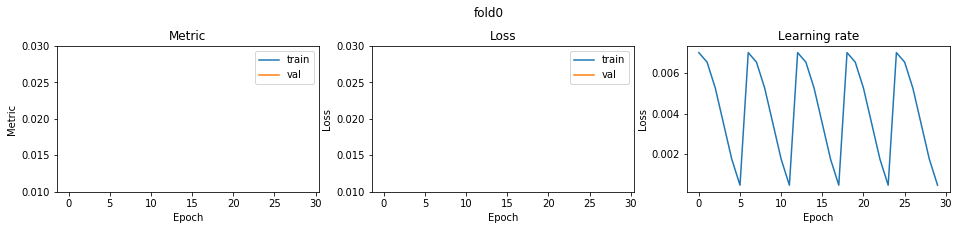

fold 1


epoch1 save best model... 0.7039190011052723
epoch2 save best model... 0.6972942260219394
epoch3 save best model... 0.6930063623832282
epoch4 save best model... 0.6889268502229763
epoch5 save best model... 0.6853840985991303
epoch7 save best model... 0.6766409731231754
epoch8 save best model... 0.6694922279621697
epoch9 save best model... 0.6638252175622933
epoch10 save best model... 0.659113135933197
epoch11 save best model... 0.6569380594375438
epoch12 save best model... 0.6559631854506228
epoch13 save best model... 0.6464502793505675
epoch14 save best model... 0.6374282247250431
epoch15 save best model... 0.6298537012193871
epoch16 save best model... 0.6225560294465504
epoch17 save best model... 0.6188287228705753
epoch18 save best model... 0.617893033254171
epoch19 save best model... 0.6060443840230019
epoch20 save best model... 0.5902771748913044
epoch21 save best model... 0.5769954586686347
epoch22 save best model... 0.5685801136925541
epoch23 save best model... 0.560529773586783

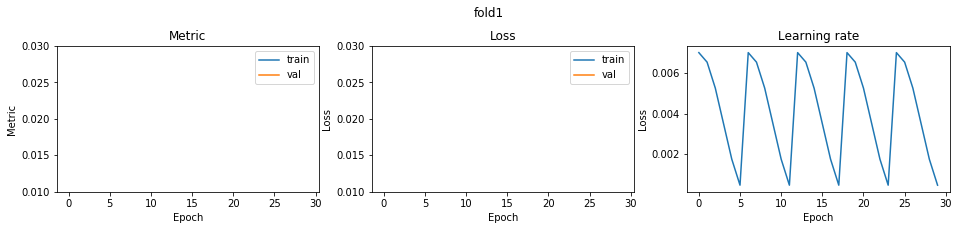

fold 2


epoch1 save best model... 0.7007978080915519
epoch2 save best model... 0.6934953282107034
epoch3 save best model... 0.6860452878309508
epoch4 save best model... 0.6841128063951546
epoch5 save best model... 0.6795251912287358
epoch6 save best model... 0.6776671166516676
epoch7 save best model... 0.6723724813335277
epoch8 save best model... 0.6664082136342129
epoch9 save best model... 0.6564530019038738
epoch10 save best model... 0.653384910938435
epoch11 save best model... 0.651416488540121
epoch13 save best model... 0.6417599795456219
epoch14 save best model... 0.6305726474742189
epoch15 save best model... 0.6217317983973241
epoch16 save best model... 0.6158312747624611
epoch17 save best model... 0.6117878035712443
epoch18 save best model... 0.6107862025438232
epoch19 save best model... 0.596730327071131
epoch20 save best model... 0.5818123452129438
epoch21 save best model... 0.5678663770113319
epoch22 save best model... 0.5600907726802813
epoch23 save best model... 0.5540207460790866


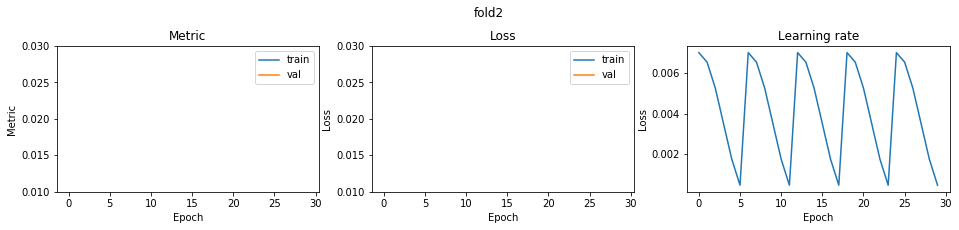

fold 3


epoch1 save best model... 0.7068447452742852
epoch2 save best model... 0.6981166531121812
epoch3 save best model... 0.6914875484544758
epoch4 save best model... 0.6874993558896701
epoch6 save best model... 0.685956814185905
epoch7 save best model... 0.6795565695588844
epoch8 save best model... 0.6709945921202727
epoch9 save best model... 0.6634129361030996
epoch10 save best model... 0.659829424942816
epoch11 save best model... 0.6570504143189189
epoch13 save best model... 0.6486291435693554
epoch14 save best model... 0.6386773555859889
epoch15 save best model... 0.6323768116347067
epoch16 save best model... 0.6270864781866312
epoch17 save best model... 0.6233357904983816
epoch18 save best model... 0.6223660464167323
epoch19 save best model... 0.609686759854232
epoch20 save best model... 0.5976930454543077
epoch21 save best model... 0.5869631111486083
epoch22 save best model... 0.5784464352494764
epoch23 save best model... 0.5721592309263138
epoch25 save best model... 0.5527216251727389

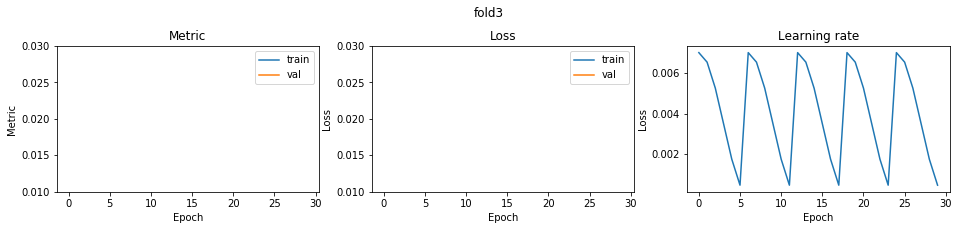

fold 4


epoch1 save best model... 0.7059654715120928
epoch2 save best model... 0.6998838219664363
epoch3 save best model... 0.695045206188341
epoch4 save best model... 0.6901440559595755
epoch5 save best model... 0.6876532170386955
epoch6 save best model... 0.6870568508167745
epoch7 save best model... 0.6797827681267723
epoch8 save best model... 0.6728351573194621
epoch9 save best model... 0.6661530321171181
epoch10 save best model... 0.6623044010446936
epoch11 save best model... 0.6583502803956729
epoch12 save best model... 0.658344138456097
epoch13 save best model... 0.649098210318485
epoch14 save best model... 0.6397183470411019
epoch15 save best model... 0.6299567425984185
epoch16 save best model... 0.6247091823123854
epoch17 save best model... 0.6237246273590383
epoch18 save best model... 0.6225525956762136
epoch19 save best model... 0.6070130041357054
epoch20 save best model... 0.5930552955097381
epoch21 save best model... 0.5810460941123528
epoch22 save best model... 0.5720070818019076


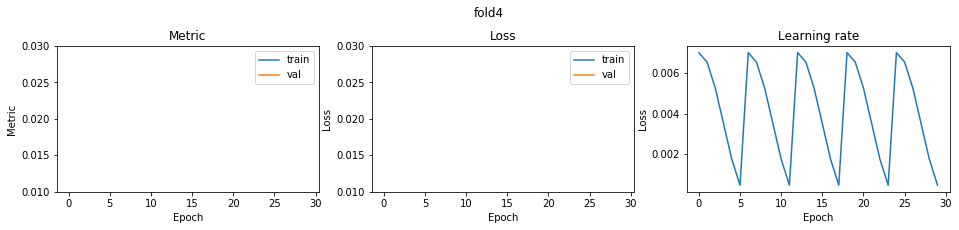

CV score: 0.4763897836270188

optimizer: PID
fold 0


epoch1 save best model... 0.7021183707176417
epoch2 save best model... 0.6935175910626022
epoch3 save best model... 0.6882389296703295
epoch4 save best model... 0.6847284246414289
epoch5 save best model... 0.6833894993558288
epoch7 save best model... 0.6772978549394629
epoch8 save best model... 0.6664997778069186
epoch9 save best model... 0.6610643230972638
epoch10 save best model... 0.6561143797187979
epoch12 save best model... 0.6550236891776934
epoch13 save best model... 0.644492355457471
epoch14 save best model... 0.6369881813509861
epoch15 save best model... 0.6272824886719567
epoch16 save best model... 0.6218472740644746
epoch17 save best model... 0.6179471295352406
epoch19 save best model... 0.6027159500773784
epoch20 save best model... 0.5908065783135712
epoch21 save best model... 0.5776325144637419
epoch22 save best model... 0.568816821450253
epoch23 save best model... 0.5639194876023469
epoch24 save best model... 0.5624703823569696
epoch25 save best model... 0.541367347175276

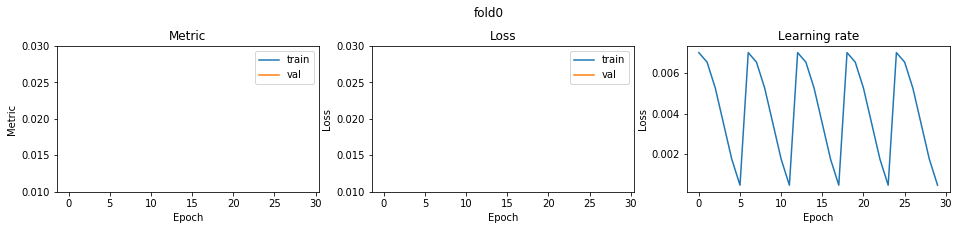

fold 1


epoch1 save best model... 0.7038044432052096
epoch2 save best model... 0.694598785875924
epoch3 save best model... 0.6915270510961646
epoch4 save best model... 0.6863649568978191
epoch5 save best model... 0.6854431016837906
epoch7 save best model... 0.677232600203623
epoch8 save best model... 0.668908163528286
epoch9 save best model... 0.6633036849737222
epoch10 save best model... 0.6581602375500293
epoch11 save best model... 0.6569681118712878
epoch13 save best model... 0.6464846198964591
epoch14 save best model... 0.6376989823480651
epoch15 save best model... 0.6307836989520975
epoch16 save best model... 0.6247482531894771
epoch17 save best model... 0.6223712826025027
epoch18 save best model... 0.6215215565593891
epoch19 save best model... 0.6092466658355163
epoch20 save best model... 0.5951160383295105
epoch21 save best model... 0.583016509943493
epoch22 save best model... 0.5756499360025431
epoch23 save best model... 0.5689382389320222
epoch25 save best model... 0.5497760186436562


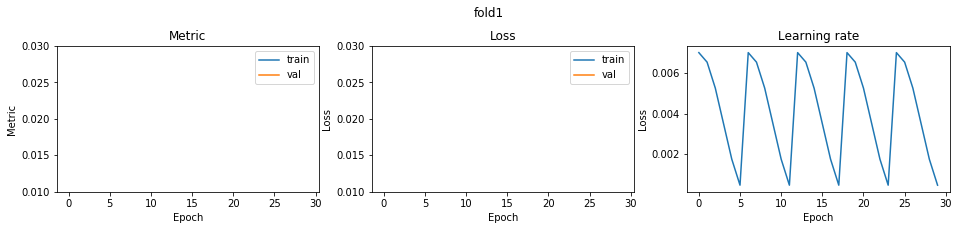

fold 2


epoch1 save best model... 0.7056136006482181
epoch2 save best model... 0.6986538839519472
epoch3 save best model... 0.6924089622758304
epoch4 save best model... 0.689428452207983
epoch5 save best model... 0.6871042656556271
epoch6 save best model... 0.6859596413071103
epoch7 save best model... 0.6766966458984648
epoch8 save best model... 0.6696518232078752
epoch9 save best model... 0.6623220232685217
epoch10 save best model... 0.6597856653662851
epoch11 save best model... 0.6563745336723805
epoch12 save best model... 0.6556329513280585
epoch13 save best model... 0.6459121898709573
epoch14 save best model... 0.6354354173997508
epoch15 save best model... 0.6274435319588705
epoch16 save best model... 0.621973692868342
epoch17 save best model... 0.618080427052356
epoch18 save best model... 0.6169010750197365
epoch19 save best model... 0.6044690066846256
epoch20 save best model... 0.5914674715399335
epoch21 save best model... 0.5764449908158099
epoch22 save best model... 0.564332575346077
e

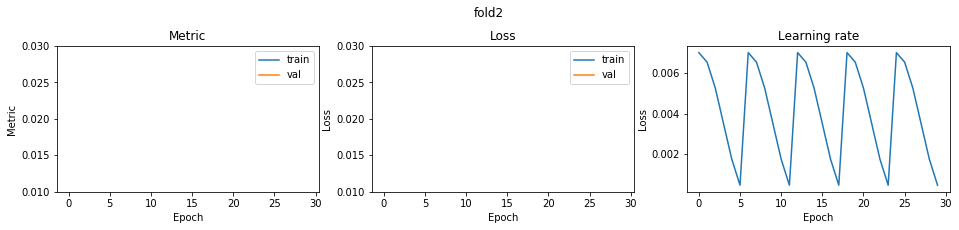

fold 3


epoch1 save best model... 0.7052668699370973
epoch2 save best model... 0.6981879950927439
epoch3 save best model... 0.6924841518282618
epoch4 save best model... 0.6863085495040737
epoch5 save best model... 0.6844251500446867
epoch6 save best model... 0.6836608130459362
epoch7 save best model... 0.6764237167894976
epoch8 save best model... 0.6705975028811392
epoch9 save best model... 0.6634182091182891
epoch10 save best model... 0.6597434263294542
epoch11 save best model... 0.6563084740302014
epoch12 save best model... 0.6558166160398844
epoch13 save best model... 0.647988695028431
epoch14 save best model... 0.6395695786541307
epoch15 save best model... 0.6291591716790254
epoch16 save best model... 0.6250559878512233
epoch17 save best model... 0.6214881437514529
epoch18 save best model... 0.6212522446701901
epoch19 save best model... 0.607959341758476
epoch20 save best model... 0.5938141104572183
epoch21 save best model... 0.5800049384253987
epoch22 save best model... 0.5704310792725287

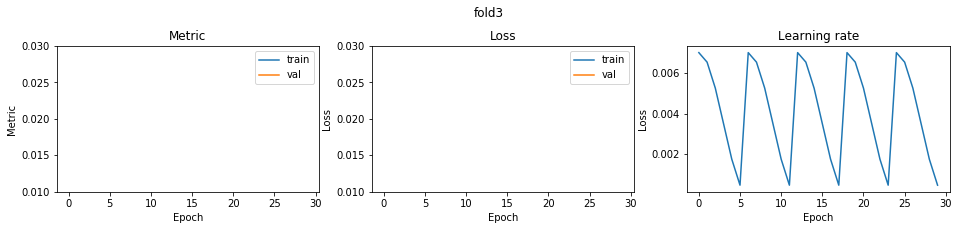

fold 4


epoch1 save best model... 0.710915286557278
epoch2 save best model... 0.6999590900872997
epoch3 save best model... 0.6936514731963295
epoch4 save best model... 0.6893526170411252
epoch6 save best model... 0.6875814293674565
epoch7 save best model... 0.6801987355825299
epoch8 save best model... 0.6716875123814733
epoch9 save best model... 0.6652185210062865
epoch10 save best model... 0.6591757964979271
epoch11 save best model... 0.6569486915386348
epoch12 save best model... 0.6560941013768485
epoch13 save best model... 0.6459171933030756
epoch14 save best model... 0.6359664177568736
epoch15 save best model... 0.6255321663170035
epoch16 save best model... 0.6203296206806678
epoch17 save best model... 0.619234442357865
epoch18 save best model... 0.6175413355740437
epoch19 save best model... 0.6023172219684836
epoch20 save best model... 0.5865519024245016
epoch21 save best model... 0.572529905939428
epoch22 save best model... 0.5586272249189216
epoch23 save best model... 0.5551021739942338

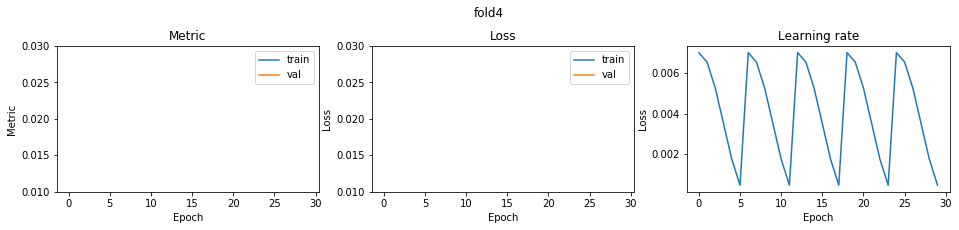

CV score: 0.47579545794882083

optimizer: QHM
fold 0


epoch1 save best model... 0.7022289338307391
epoch2 save best model... 0.6947259433991817
epoch3 save best model... 0.689473788912041
epoch4 save best model... 0.6883228842109645
epoch5 save best model... 0.6829549284350628
epoch7 save best model... 0.6751163624956831
epoch8 save best model... 0.6657140488776639
epoch9 save best model... 0.6593367692549842
epoch10 save best model... 0.6552715838634343
epoch11 save best model... 0.6519532460829663
epoch13 save best model... 0.6421199247614398
epoch14 save best model... 0.6315961461132371
epoch15 save best model... 0.6234115468885469
epoch16 save best model... 0.6167692886126611
epoch17 save best model... 0.6142246009277048
epoch18 save best model... 0.6122040000211677
epoch19 save best model... 0.5974960422461559
epoch20 save best model... 0.5827668227204429
epoch21 save best model... 0.5714030579988397
epoch22 save best model... 0.5588652876352124
epoch23 save best model... 0.5550362116111981
epoch24 save best model... 0.55422502962494

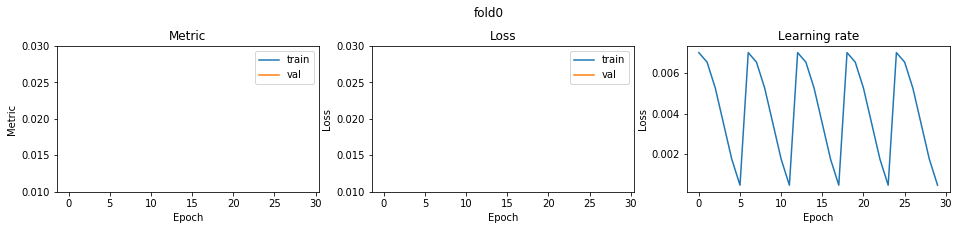

fold 1


epoch1 save best model... 0.7014612345278304
epoch2 save best model... 0.6966593759319021
epoch3 save best model... 0.6890864042519816
epoch4 save best model... 0.6863219619584969
epoch5 save best model... 0.6833410101182424
epoch7 save best model... 0.6751864967109348
epoch8 save best model... 0.6672499868641086
epoch9 save best model... 0.6613857942497738
epoch10 save best model... 0.6578979213244824
epoch11 save best model... 0.6566299398740133
epoch12 save best model... 0.653820856770776
epoch13 save best model... 0.6436416893674616
epoch14 save best model... 0.6342696319763903
epoch15 save best model... 0.6256659522255398
epoch16 save best model... 0.6196331370390203
epoch17 save best model... 0.6190438486633988
epoch18 save best model... 0.6162087923574893
epoch19 save best model... 0.6019284978600618
epoch20 save best model... 0.5875326976550144
epoch21 save best model... 0.5761017321481007
epoch22 save best model... 0.565260858382579
epoch23 save best model... 0.559539282829839

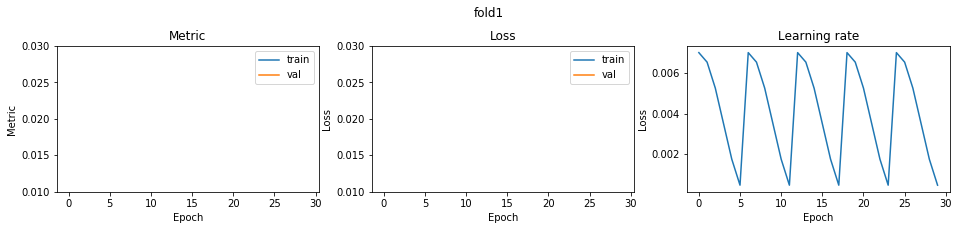

fold 2


epoch1 save best model... 0.7069548423590652
epoch2 save best model... 0.6984426223435904
epoch3 save best model... 0.6927680313845217
epoch4 save best model... 0.6900983766098179
epoch5 save best model... 0.6883963593374111
epoch7 save best model... 0.6815011888898622
epoch8 save best model... 0.6715880653042814
epoch9 save best model... 0.6643443593785496
epoch10 save best model... 0.6616598394444548
epoch11 save best model... 0.6601541459248044
epoch12 save best model... 0.660097034177413
epoch13 save best model... 0.6502545911349368
epoch14 save best model... 0.6416085284889953
epoch15 save best model... 0.6343924499883498
epoch16 save best model... 0.6272819904565105
epoch17 save best model... 0.6249343734799009
epoch18 save best model... 0.6247665816109553
epoch19 save best model... 0.6126462532409803
epoch20 save best model... 0.601718070485864
epoch21 save best model... 0.5871318935071398
epoch22 save best model... 0.5796693429286346
epoch23 save best model... 0.573812674759025

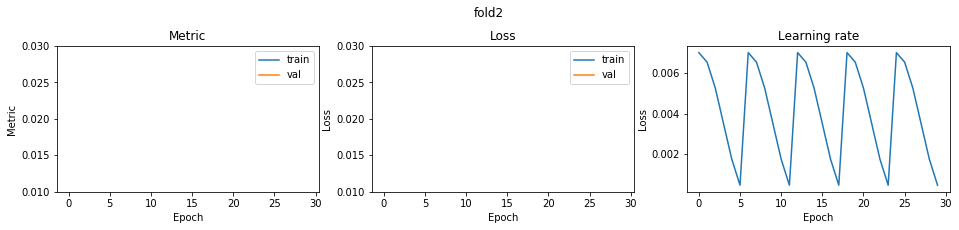

fold 3


epoch1 save best model... 0.7034989418092784
epoch2 save best model... 0.6971428791048315
epoch3 save best model... 0.6904421357467668
epoch4 save best model... 0.6893764417372423
epoch5 save best model... 0.6851127739919345
epoch6 save best model... 0.684909722826747
epoch7 save best model... 0.6775025628422279
epoch8 save best model... 0.6700488067976706
epoch9 save best model... 0.662391828214389
epoch10 save best model... 0.6599826819261277
epoch11 save best model... 0.6576720091911004
epoch12 save best model... 0.656458728215689
epoch13 save best model... 0.6478216777086802
epoch14 save best model... 0.6404216490465308
epoch15 save best model... 0.6312081145534211
epoch16 save best model... 0.6267390211785301
epoch17 save best model... 0.6232112689822029
epoch18 save best model... 0.6215323487827067
epoch19 save best model... 0.6131509554413294
epoch20 save best model... 0.598365110661283
epoch21 save best model... 0.5861718277996385
epoch22 save best model... 0.5780313342198695
e

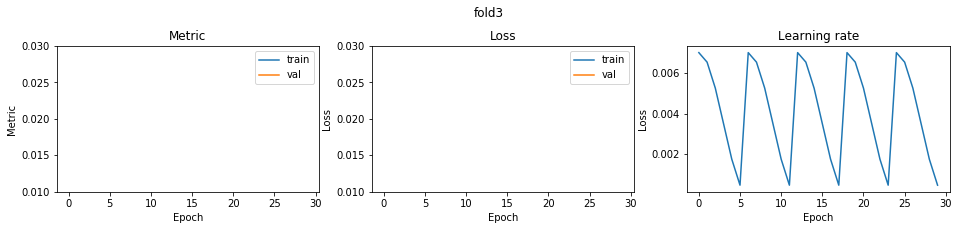

fold 4


epoch1 save best model... 0.7055109013185957
epoch2 save best model... 0.7001170121727337
epoch3 save best model... 0.6948281479044764
epoch4 save best model... 0.6905580404136067
epoch5 save best model... 0.6876895188470636
epoch6 save best model... 0.6872623351548962
epoch7 save best model... 0.6802851495547284
epoch8 save best model... 0.6695706187185231
epoch9 save best model... 0.6639376383436025
epoch10 save best model... 0.6606056471077347
epoch11 save best model... 0.6581560794204677
epoch13 save best model... 0.6498286281739932
epoch14 save best model... 0.6408715632618968
epoch15 save best model... 0.6304943905876004
epoch16 save best model... 0.6255997587988208
epoch17 save best model... 0.6218002024163961
epoch19 save best model... 0.6099600332201478
epoch20 save best model... 0.5950766872164872
epoch21 save best model... 0.5813272523988624
epoch22 save best model... 0.5713736688629099
epoch23 save best model... 0.5685782411103911
epoch25 save best model... 0.54714000879496

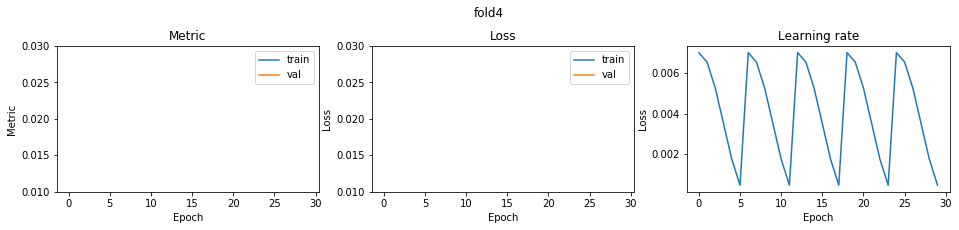

CV score: 0.48115149435239973

optimizer: SGDP
fold 0


epoch1 save best model... 0.7039507873509088
epoch2 save best model... 0.6992476839139412
epoch3 save best model... 0.6912071275819679
epoch4 save best model... 0.687731747448037
epoch5 save best model... 0.6847819329665842
epoch7 save best model... 0.6792088457826602
epoch8 save best model... 0.6717669631462705
epoch9 save best model... 0.6639788838616808
epoch10 save best model... 0.6589835803981251
epoch11 save best model... 0.6578522623264165
epoch13 save best model... 0.6478744575265871
epoch14 save best model... 0.6388823981708709
epoch15 save best model... 0.6293880519942977
epoch16 save best model... 0.6253425205487053
epoch17 save best model... 0.6216272249037149
epoch18 save best model... 0.6212777420980241
epoch19 save best model... 0.6085807584141273
epoch20 save best model... 0.5942483704562611
epoch21 save best model... 0.58303315881173
epoch22 save best model... 0.573758261703413
epoch23 save best model... 0.570557345018843
epoch24 save best model... 0.5680550520675329
e

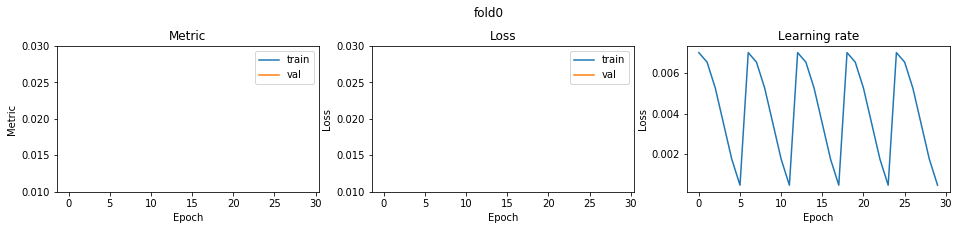

fold 1


epoch1 save best model... 0.7024019254207285
epoch2 save best model... 0.6964749743303423
epoch3 save best model... 0.6889569852395057
epoch4 save best model... 0.6860060678932057
epoch5 save best model... 0.6836622558495101
epoch7 save best model... 0.6765297068417493
epoch8 save best model... 0.6694197646847454
epoch9 save best model... 0.6626728176934813
epoch10 save best model... 0.6602552456148504
epoch11 save best model... 0.6575351158234655
epoch12 save best model... 0.6566352713458439
epoch13 save best model... 0.6488921208543532
epoch14 save best model... 0.63931471042846
epoch15 save best model... 0.6316403181250314
epoch16 save best model... 0.6275267901005575
epoch17 save best model... 0.6211794829363159
epoch19 save best model... 0.6110280595191874
epoch20 save best model... 0.5960631210838209
epoch21 save best model... 0.5839888190973264
epoch22 save best model... 0.5771183871033252
epoch23 save best model... 0.5720014897259799
epoch24 save best model... 0.568014378128303

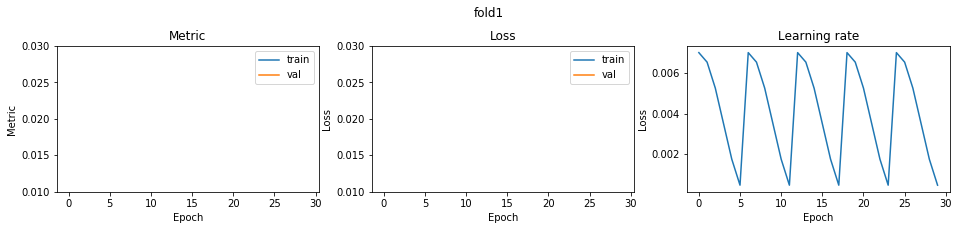

fold 2


epoch1 save best model... 0.7096434739951148
epoch2 save best model... 0.6985706603182126
epoch3 save best model... 0.692941528025019
epoch4 save best model... 0.6913675232095473
epoch5 save best model... 0.6882223824103184
epoch6 save best model... 0.6857555388562309
epoch7 save best model... 0.6785967923101571
epoch8 save best model... 0.6719527224197179
epoch9 save best model... 0.6662816612534166
epoch10 save best model... 0.6594073162260292
epoch11 save best model... 0.6574194389205501
epoch13 save best model... 0.6494942162025488
epoch14 save best model... 0.6381063591811944
epoch15 save best model... 0.6300815321313246
epoch16 save best model... 0.6240290486071098
epoch17 save best model... 0.6199071297995401
epoch19 save best model... 0.6083983152079457
epoch20 save best model... 0.5916658046577481
epoch21 save best model... 0.5804781444144972
epoch22 save best model... 0.567475540147987
epoch23 save best model... 0.5627438490117539
epoch24 save best model... 0.5623651771725758

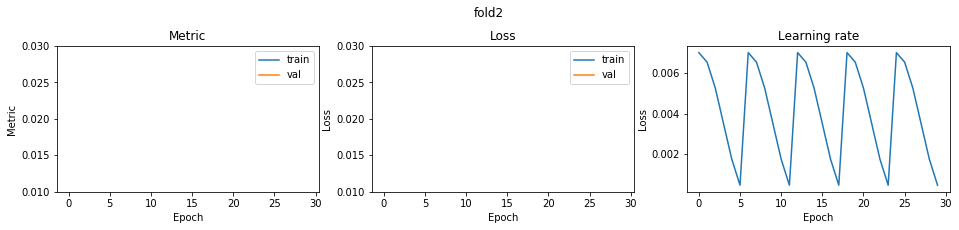

fold 3


epoch1 save best model... 0.7002989291873228
epoch2 save best model... 0.6940340537145089
epoch3 save best model... 0.6878000256955488
epoch4 save best model... 0.6841531262310871
epoch6 save best model... 0.6808028741686654
epoch7 save best model... 0.6729791532616409
epoch8 save best model... 0.6662882077938331
epoch9 save best model... 0.6595215938628942
epoch10 save best model... 0.654794338786792
epoch11 save best model... 0.6516208248420837
epoch12 save best model... 0.6499470974698425
epoch13 save best model... 0.6405900411019293
epoch14 save best model... 0.63153532279108
epoch15 save best model... 0.6238670796631137
epoch16 save best model... 0.6168003715795374
epoch17 save best model... 0.6127598851308192
epoch18 save best model... 0.6110757201299037
epoch19 save best model... 0.5957685021984822
epoch20 save best model... 0.5807163589093028
epoch21 save best model... 0.5674824383101322
epoch22 save best model... 0.5584849129233653
epoch23 save best model... 0.5545120567558567

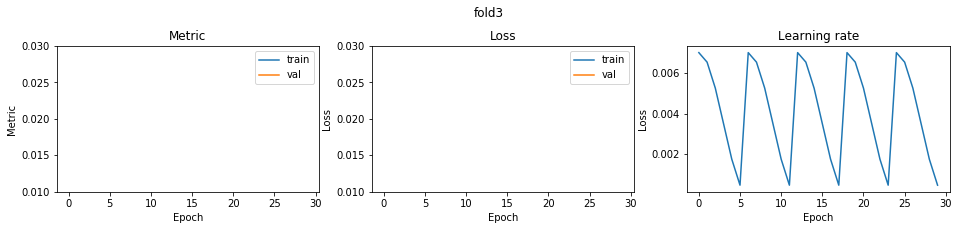

fold 4


epoch1 save best model... 0.7073055467192839
epoch2 save best model... 0.6992043430006857
epoch3 save best model... 0.6930540178522705
epoch4 save best model... 0.6890809668495335
epoch5 save best model... 0.68460150294532
epoch7 save best model... 0.6776394088338882
epoch8 save best model... 0.6706464443771606
epoch9 save best model... 0.6638152080407719
epoch10 save best model... 0.6565217632367562
epoch11 save best model... 0.6544705365676272
epoch13 save best model... 0.6474925943007501
epoch14 save best model... 0.6386555359412435
epoch15 save best model... 0.6302932887522669
epoch16 save best model... 0.6236315526017295
epoch17 save best model... 0.6197718527702645
epoch19 save best model... 0.6070686114676178
epoch20 save best model... 0.5925443778820081
epoch21 save best model... 0.5808110024771549
epoch22 save best model... 0.5687838590498122
epoch23 save best model... 0.5649823193126496
epoch24 save best model... 0.5633518851971029
epoch25 save best model... 0.545364422461438

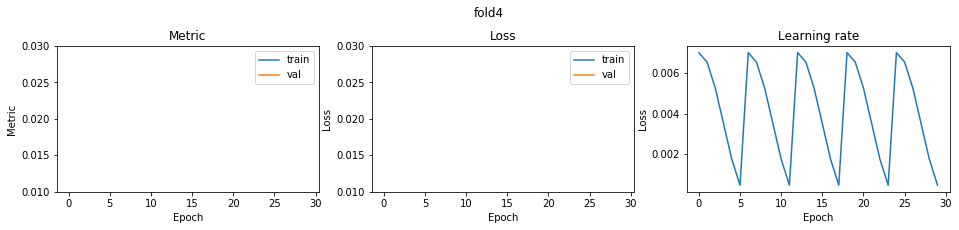

CV score: 0.4779983722807299

optimizer: SGDW
fold 0


epoch1 save best model... 0.7067811496437003
epoch2 save best model... 0.7012356404019923
epoch3 save best model... 0.6933736186092698
epoch4 save best model... 0.6876734967383817
epoch7 save best model... 0.6781085127578509
epoch8 save best model... 0.6717168674382099
epoch9 save best model... 0.6640521893740243
epoch10 save best model... 0.6606165106312832
epoch11 save best model... 0.6571068185065493
epoch13 save best model... 0.6477267367421631
epoch14 save best model... 0.6400856768894847
epoch15 save best model... 0.6321572810207793
epoch16 save best model... 0.6267365857789077
epoch17 save best model... 0.621952717586639
epoch18 save best model... 0.6208097449467774
epoch19 save best model... 0.6087267266590666
epoch20 save best model... 0.5927776051816744
epoch21 save best model... 0.5834894399165022
epoch22 save best model... 0.5729414403574342
epoch23 save best model... 0.5686828140517303
epoch24 save best model... 0.5666621165286435
epoch25 save best model... 0.5466373973392

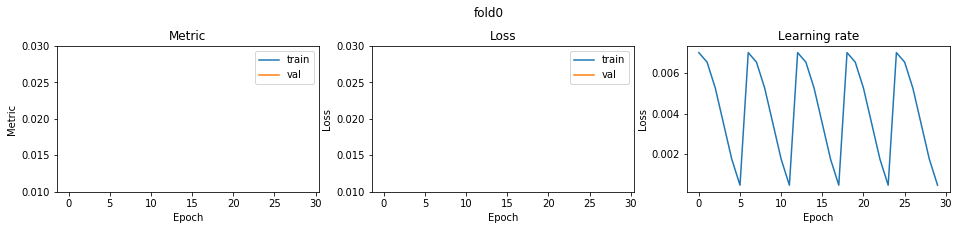

fold 1


epoch1 save best model... 0.7033154507736107
epoch2 save best model... 0.6953621723842556
epoch3 save best model... 0.6888677676111344
epoch4 save best model... 0.6875079022259993
epoch5 save best model... 0.6845722130176608
epoch6 save best model... 0.6821258708403468
epoch7 save best model... 0.6762168448996397
epoch8 save best model... 0.6702545047431037
epoch9 save best model... 0.6641079748945264
epoch10 save best model... 0.6613971489413938
epoch11 save best model... 0.6565848777440285
epoch13 save best model... 0.6519603561529349
epoch14 save best model... 0.6395811707317816
epoch15 save best model... 0.6352808735696024
epoch16 save best model... 0.628644641302908
epoch17 save best model... 0.626390422645368
epoch18 save best model... 0.6251308533264798
epoch19 save best model... 0.6140760773133787
epoch20 save best model... 0.6005470548737535
epoch21 save best model... 0.5897143512088309
epoch22 save best model... 0.5816096655734173
epoch23 save best model... 0.5802106760878529

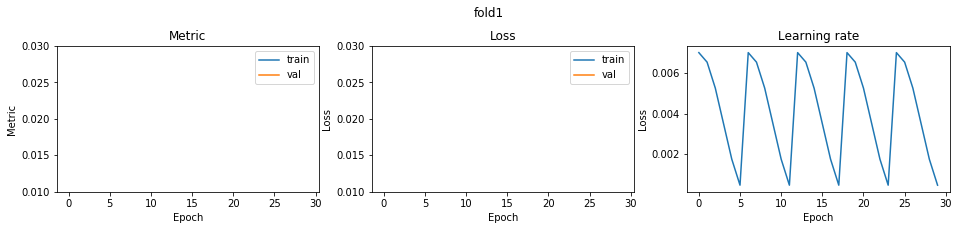

fold 2


epoch1 save best model... 0.7005700385089778
epoch2 save best model... 0.6930814811840609
epoch3 save best model... 0.6902444794227441
epoch4 save best model... 0.6839953468665634
epoch5 save best model... 0.6823891037470334
epoch6 save best model... 0.6808370913479262
epoch7 save best model... 0.6758883937830044
epoch8 save best model... 0.6656008191384658
epoch9 save best model... 0.660485408672251
epoch10 save best model... 0.6580700639658241
epoch11 save best model... 0.6538043856539306
epoch12 save best model... 0.6532424867193909
epoch13 save best model... 0.6459972621721514
epoch14 save best model... 0.6357178801989387
epoch15 save best model... 0.6275981566606662
epoch16 save best model... 0.6233382410274113
epoch17 save best model... 0.6200307443734588
epoch18 save best model... 0.6190949432614671
epoch19 save best model... 0.6057534021461002
epoch20 save best model... 0.5920541273567067
epoch21 save best model... 0.5794560318521172
epoch22 save best model... 0.571783461000903

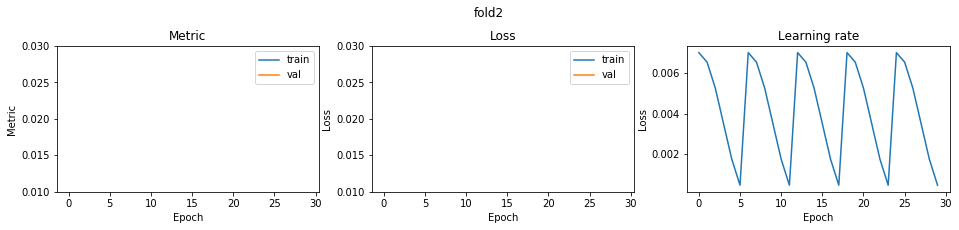

fold 3


epoch1 save best model... 0.7036315238014169
epoch2 save best model... 0.6956435892467889
epoch3 save best model... 0.693020575491877
epoch4 save best model... 0.6872864142365771
epoch5 save best model... 0.6814562243861326
epoch7 save best model... 0.6728060183329572
epoch8 save best model... 0.6653480952041296
epoch9 save best model... 0.6582525831420221
epoch10 save best model... 0.6545543465636042
epoch11 save best model... 0.6533621745663515
epoch13 save best model... 0.6418636595198125
epoch14 save best model... 0.6322347973093628
epoch15 save best model... 0.6235812233357875
epoch16 save best model... 0.6199318175706885
epoch17 save best model... 0.6150826442486061
epoch19 save best model... 0.6013253663015257
epoch20 save best model... 0.5841395930168569
epoch21 save best model... 0.572498898761419
epoch22 save best model... 0.5626606067926846
epoch23 save best model... 0.5577678073511579
epoch25 save best model... 0.5370287254622422
epoch26 save best model... 0.512712017142962

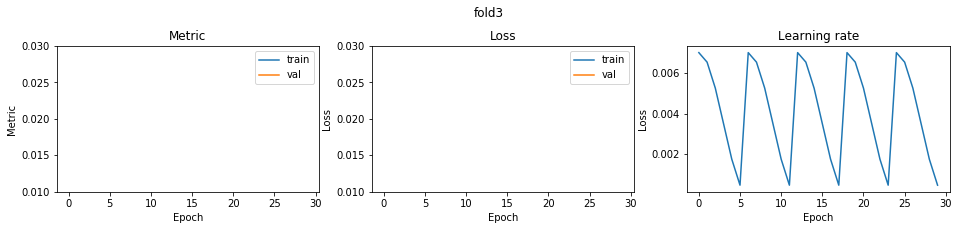

fold 4


epoch1 save best model... 0.7109979042702764
epoch2 save best model... 0.6996592445362674
epoch3 save best model... 0.6937684915060335
epoch4 save best model... 0.6892897158114405
epoch5 save best model... 0.6887203343908445
epoch6 save best model... 0.6874454318255118
epoch7 save best model... 0.6829125331311672
epoch8 save best model... 0.6716807824060966
epoch9 save best model... 0.6655192178854367
epoch10 save best model... 0.6612427131190115
epoch11 save best model... 0.6590401628837499
epoch12 save best model... 0.6586370667998502
epoch13 save best model... 0.650374914057434
epoch14 save best model... 0.6412445811312942
epoch15 save best model... 0.6332194761154591
epoch16 save best model... 0.627201830390374
epoch17 save best model... 0.625139705222397
epoch18 save best model... 0.6250455791151877
epoch19 save best model... 0.6122655740903016
epoch20 save best model... 0.5972336245289153
epoch21 save best model... 0.5857446560555547
epoch22 save best model... 0.5772171910911594


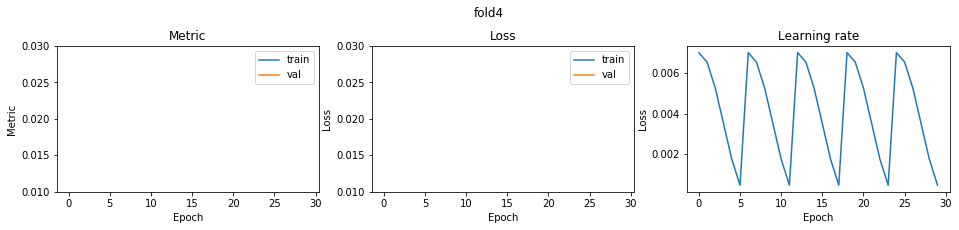

CV score: 0.48610409196539917

optimizer: SGD
fold 0


epoch1 save best model... 0.7110439349144086
epoch2 save best model... 0.7031128938757477
epoch3 save best model... 0.697501881654822
epoch4 save best model... 0.6936923323839835
epoch5 save best model... 0.6925327910649206
epoch6 save best model... 0.6900390457455281
epoch7 save best model... 0.6846161889866978
epoch8 save best model... 0.6756701674982736
epoch9 save best model... 0.6686249581719313
epoch10 save best model... 0.6658195204506703
epoch11 save best model... 0.6635159961998055
epoch12 save best model... 0.6620572543904558
epoch13 save best model... 0.6533910820315803
epoch14 save best model... 0.6415789419263261
epoch15 save best model... 0.6352939311084008
epoch16 save best model... 0.6300202381366478
epoch17 save best model... 0.6268220914795078
epoch19 save best model... 0.6125000339434196
epoch20 save best model... 0.5976200590644176
epoch21 save best model... 0.5868526013674117
epoch22 save best model... 0.5788493828512813
epoch23 save best model... 0.572300728089717

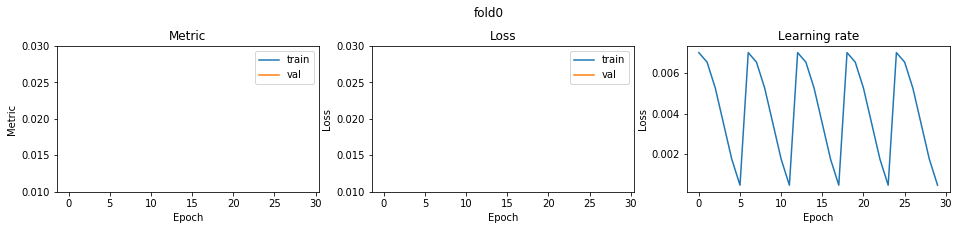

fold 1


epoch1 save best model... 0.7053238168803563
epoch2 save best model... 0.6996679253609692
epoch3 save best model... 0.6924639925051724
epoch4 save best model... 0.6887551151176986
epoch5 save best model... 0.686070648704202
epoch7 save best model... 0.6787693218452617
epoch8 save best model... 0.6705690537316024
epoch9 save best model... 0.6645861366501863
epoch10 save best model... 0.6606970913428113
epoch11 save best model... 0.6580819894578143
epoch13 save best model... 0.6483253601146576
epoch14 save best model... 0.6405746055426156
epoch15 save best model... 0.6321000890841542
epoch16 save best model... 0.6259123198696518
epoch17 save best model... 0.6225734707379726
epoch19 save best model... 0.6105392728315776
epoch20 save best model... 0.5958963997490614
epoch21 save best model... 0.584726263760271
epoch22 save best model... 0.571127523971761
epoch23 save best model... 0.5693362171352793
epoch24 save best model... 0.5684138871075815
epoch25 save best model... 0.5474441633813336

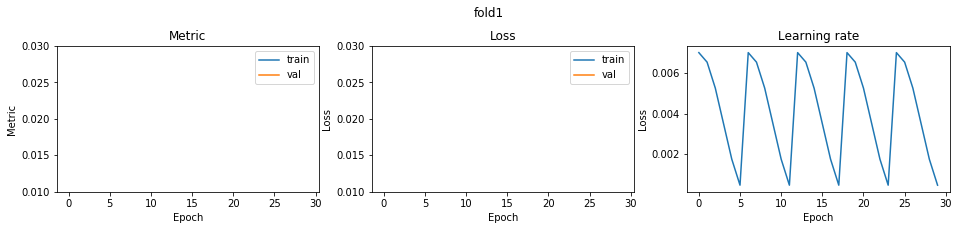

fold 2


epoch1 save best model... 0.7073246362704192
epoch2 save best model... 0.6970857775246644
epoch3 save best model... 0.6914638137730468
epoch4 save best model... 0.687802693626011
epoch5 save best model... 0.6868096562202168
epoch7 save best model... 0.6769461796370093
epoch8 save best model... 0.6713000993626512
epoch9 save best model... 0.6623788690289976
epoch10 save best model... 0.6612935414154564
epoch11 save best model... 0.6577833901915091
epoch12 save best model... 0.6551643080362618
epoch13 save best model... 0.6457259943447778
epoch14 save best model... 0.636703813597509
epoch15 save best model... 0.6295354586034354
epoch16 save best model... 0.6228823685434202
epoch17 save best model... 0.6201389910528887
epoch19 save best model... 0.6047486024854611
epoch20 save best model... 0.5898393676122898
epoch21 save best model... 0.576656108512018
epoch22 save best model... 0.5691972883640158
epoch23 save best model... 0.5639473206634591
epoch24 save best model... 0.5611028197170743

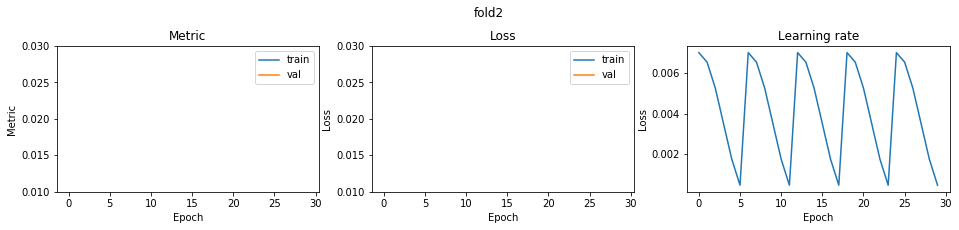

fold 3


epoch1 save best model... 0.7023886463093595
epoch2 save best model... 0.6968079767629063
epoch3 save best model... 0.690480176109931
epoch4 save best model... 0.6874337161592036
epoch5 save best model... 0.6851896007946249
epoch7 save best model... 0.6756508727551592
epoch8 save best model... 0.6673405970690733
epoch9 save best model... 0.6610703893837462
epoch10 save best model... 0.6605204539581421
epoch11 save best model... 0.6550902466296064
epoch12 save best model... 0.6550559176670935
epoch13 save best model... 0.6498562244185011
epoch14 save best model... 0.6371423156494975
epoch15 save best model... 0.629113501215307
epoch16 save best model... 0.6226260847545702
epoch17 save best model... 0.6200405925987522
epoch18 save best model... 0.6192796514897791
epoch19 save best model... 0.6057364494491003
epoch20 save best model... 0.5925543799487225
epoch21 save best model... 0.5796547473427375
epoch22 save best model... 0.5715356858553268
epoch23 save best model... 0.567616466183325

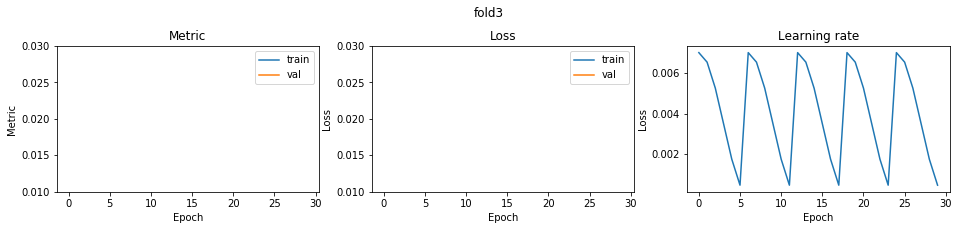

fold 4


epoch1 save best model... 0.7071925765289533
epoch2 save best model... 0.6977726113280294
epoch3 save best model... 0.6935977088563263
epoch4 save best model... 0.688804792244505
epoch5 save best model... 0.6848901522729826
epoch7 save best model... 0.6786472261902412
epoch8 save best model... 0.6703055716321246
epoch9 save best model... 0.6633599954748479
epoch10 save best model... 0.6591055901284099
epoch12 save best model... 0.657626374571633
epoch13 save best model... 0.6480744696695332
epoch14 save best model... 0.63805706970784
epoch15 save best model... 0.6327298782137912
epoch16 save best model... 0.6259088571359465
epoch17 save best model... 0.6247584432838718
epoch18 save best model... 0.6224314388490212
epoch19 save best model... 0.6097124264017596
epoch20 save best model... 0.5974737385954021
epoch21 save best model... 0.5856199423110023
epoch22 save best model... 0.5743200528051424
epoch23 save best model... 0.5718225343623846
epoch24 save best model... 0.5693354124360313


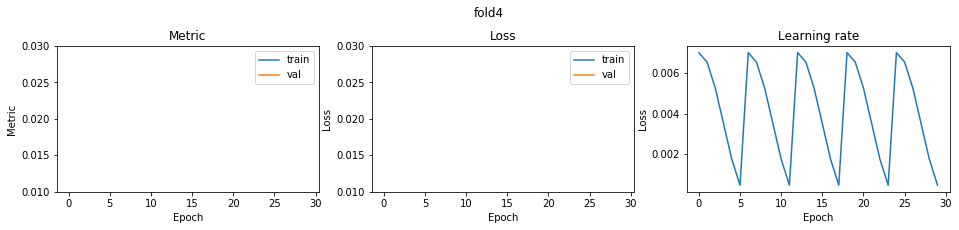

CV score: 0.4836009258069773

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019191508744429618
epoch2 save best model... 0.0183340793691898
epoch3 save best model... 0.017603889698319664
epoch4 save best model... 0.017269274289454576
epoch5 save best model... 0.01682308721260628
epoch6 save best model... 0.016532984858798817
epoch11 save best model... 0.01634866602481226
epoch12 save best model... 0.01619835285160156
epoch17 save best model... 0.01616769575923342
epoch18 save best model... 0.01609984256098034
epoch24 save best model... 0.01606534514788343
fold0 score: 0.016065345047929485


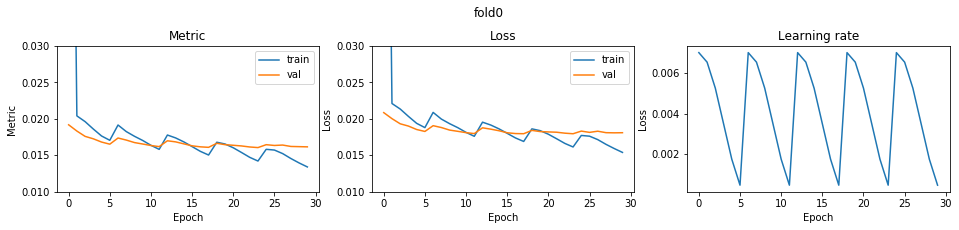

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01939706345920371
epoch2 save best model... 0.01852385793496615
epoch3 save best model... 0.018120126782834367
epoch4 save best model... 0.017453242256290198
epoch5 save best model... 0.01706765951831925
epoch6 save best model... 0.016803366014524687
epoch10 save best model... 0.016801142829983212
epoch11 save best model... 0.01665313065894021
epoch12 save best model... 0.016485468709387698
epoch17 save best model... 0.01647245503858489
epoch18 save best model... 0.016419541301648393
fold1 score: 0.01641954114430221


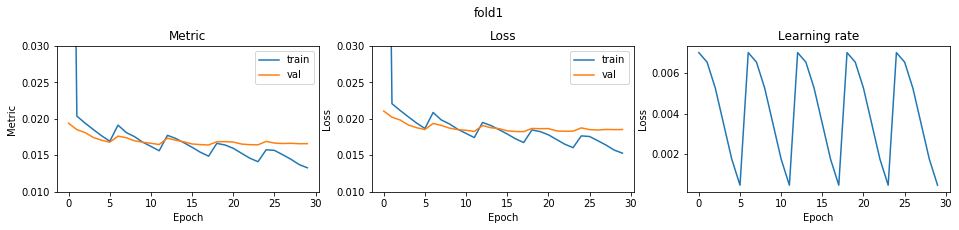

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019494361053166816
epoch2 save best model... 0.01834141358089803
epoch3 save best model... 0.017867357072017885
epoch4 save best model... 0.017315335686775433
epoch5 save best model... 0.016894250760170235
epoch6 save best model... 0.01669131089439015
epoch11 save best model... 0.016449545106094515
epoch12 save best model... 0.016345588946373363
epoch17 save best model... 0.016274167074318776
epoch18 save best model... 0.01621812964369636
fold2 score: 0.016218129504470543


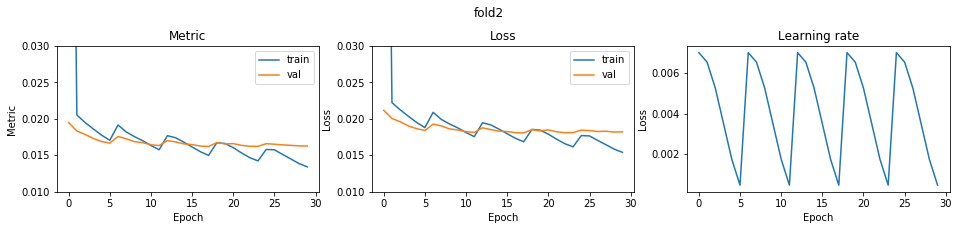

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019504185261921894
epoch2 save best model... 0.018626109393979667
epoch3 save best model... 0.018027726776371784
epoch4 save best model... 0.017594307371264575
epoch5 save best model... 0.017074132109472447
epoch6 save best model... 0.016918805073989143
epoch11 save best model... 0.016647667439913288
epoch12 save best model... 0.01650108144170942
epoch17 save best model... 0.016394154842442287
epoch18 save best model... 0.016335020776507114
fold3 score: 0.0163350206793061


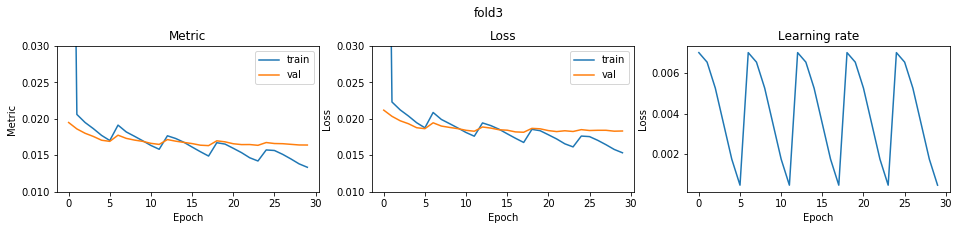

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01910299046181465
epoch2 save best model... 0.01846518638779267
epoch3 save best model... 0.017790102914128463
epoch4 save best model... 0.01724148193981015
epoch5 save best model... 0.017041220402680253
epoch6 save best model... 0.016779953636789104
epoch11 save best model... 0.016593613667341463
epoch12 save best model... 0.01648885586971506
epoch17 save best model... 0.016428185309069167
epoch18 save best model... 0.0163346263857936
fold4 score: 0.016334626345380986


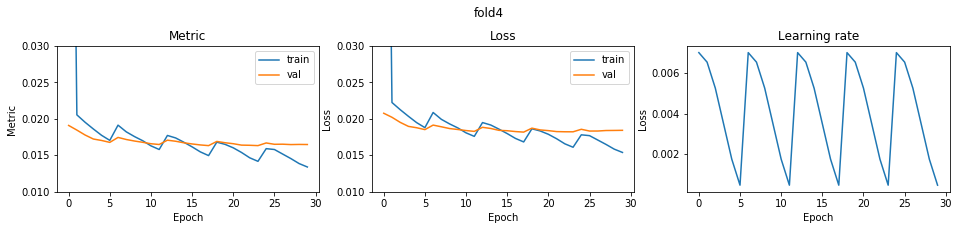

CV score: 0.01627452850721024

optimizer: AdaBound
fold 0


epoch1 save best model... 0.022505393434222577
epoch2 save best model... 0.02173298636116172
epoch3 save best model... 0.021427989139270402
epoch4 save best model... 0.021390476345099458
epoch5 save best model... 0.021251331377511416
epoch7 save best model... 0.02109971709617314
epoch8 save best model... 0.02099221293519597
epoch9 save best model... 0.020944189662983587
epoch10 save best model... 0.02092293749705534
epoch11 save best model... 0.020856129916083568
epoch12 save best model... 0.020841024679413962
epoch13 save best model... 0.02075769547924637
epoch14 save best model... 0.020711814378789183
epoch15 save best model... 0.020644908731883915
epoch16 save best model... 0.020616739679441907
epoch17 save best model... 0.020614783343665965
epoch19 save best model... 0.020549627079507485
epoch20 save best model... 0.020516048393006477
epoch22 save best model... 0.02048539017286822
epoch23 save best model... 0.020480675964800805
epoch25 save best model... 0.020449660144797217
epoch2

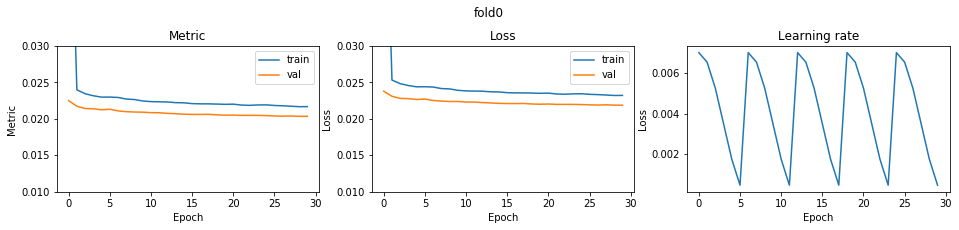

fold 1


epoch1 save best model... 0.022546680436203736
epoch2 save best model... 0.021749860885699263
epoch3 save best model... 0.02144157183716253
epoch4 save best model... 0.021326109489833853
epoch5 save best model... 0.021263965416345707
epoch7 save best model... 0.021103351830410833
epoch8 save best model... 0.02101974245640378
epoch9 save best model... 0.02094551101904112
epoch11 save best model... 0.02088943979853336
epoch12 save best model... 0.020876785584505394
epoch13 save best model... 0.020844678875966235
epoch14 save best model... 0.02078120669065263
epoch16 save best model... 0.020718355965073817
epoch18 save best model... 0.020690022939109508
epoch20 save best model... 0.020676945235794948
epoch21 save best model... 0.020588494849591382
epoch22 save best model... 0.02057984550681927
epoch24 save best model... 0.020570198040456428
epoch25 save best model... 0.020549170962327105
epoch26 save best model... 0.020511818489097576
epoch28 save best model... 0.020497378411302402
epoch2

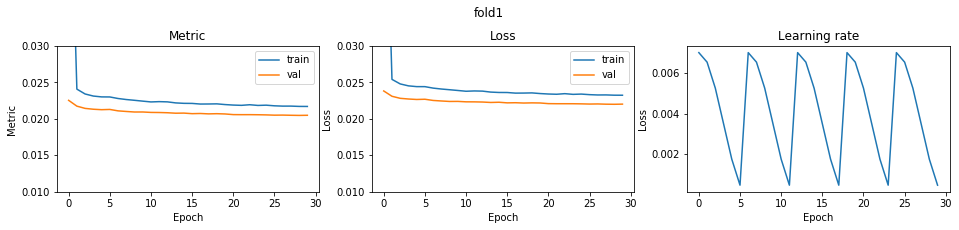

fold 2


epoch1 save best model... 0.022447101966626255
epoch2 save best model... 0.021631455253050033
epoch3 save best model... 0.02148956540903243
epoch4 save best model... 0.021299144313822415
epoch5 save best model... 0.021290287366113568
epoch6 save best model... 0.021220815941983377
epoch7 save best model... 0.021058756243170162
epoch8 save best model... 0.021043048667816727
epoch9 save best model... 0.020877521863645616
epoch10 save best model... 0.020866550571366035
epoch11 save best model... 0.020844131552394226
epoch12 save best model... 0.020823213340759983
epoch13 save best model... 0.020797531556963622
epoch14 save best model... 0.020695996513824904
epoch15 save best model... 0.02068931147614042
epoch16 save best model... 0.020643094476455844
epoch19 save best model... 0.020615779526326292
epoch20 save best model... 0.020592928822683865
epoch21 save best model... 0.020548999641836707
epoch22 save best model... 0.020545445112259003
epoch24 save best model... 0.02052658759728057
epoc

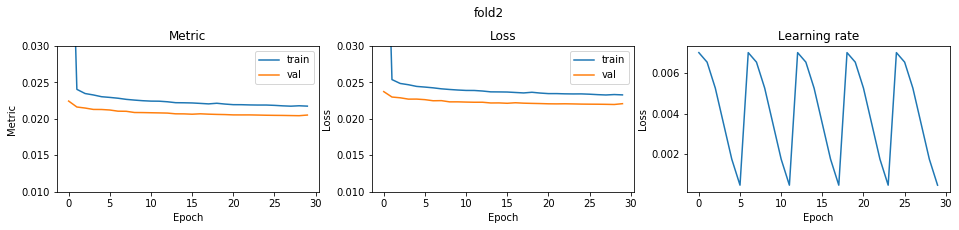

fold 3


epoch1 save best model... 0.022569688451147568
epoch2 save best model... 0.02188903434723955
epoch3 save best model... 0.021652207760339718
epoch4 save best model... 0.02149527359643531
epoch5 save best model... 0.021491188181729685
epoch6 save best model... 0.021474474684625933
epoch7 save best model... 0.02132691359041356
epoch8 save best model... 0.021300633969570347
epoch9 save best model... 0.021214605104560053
epoch10 save best model... 0.021160071489564513
epoch11 save best model... 0.02109887040727231
epoch12 save best model... 0.021078584053403016
epoch13 save best model... 0.02107059240366644
epoch14 save best model... 0.021036799412840184
epoch15 save best model... 0.020960541663941734
epoch16 save best model... 0.020923517683016004
epoch18 save best model... 0.020912438639543594
epoch19 save best model... 0.020878597680301085
epoch20 save best model... 0.020829263626086548
epoch21 save best model... 0.02080011047541688
epoch23 save best model... 0.02078454994462889
epoch25 

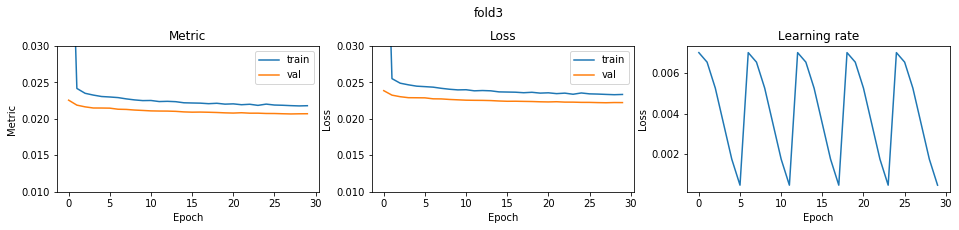

fold 4


epoch1 save best model... 0.022281462857011783
epoch2 save best model... 0.021550807574920883
epoch3 save best model... 0.021320062773068835
epoch4 save best model... 0.021200979777647858
epoch5 save best model... 0.02113479582130366
epoch7 save best model... 0.02096816876347353
epoch8 save best model... 0.02088492614872635
epoch9 save best model... 0.020814638247963778
epoch11 save best model... 0.020737297638639775
epoch13 save best model... 0.02067017053043924
epoch14 save best model... 0.020609960876456154
epoch16 save best model... 0.02056454387673756
epoch17 save best model... 0.02053982281213062
epoch19 save best model... 0.02050840367471846
epoch20 save best model... 0.02047816228231835
epoch21 save best model... 0.020441991170541574
epoch22 save best model... 0.02043353355572408
epoch24 save best model... 0.020423805228262665
epoch25 save best model... 0.020396842553804296
epoch26 save best model... 0.020377864127719865
epoch27 save best model... 0.020357148855890662
epoch29 s

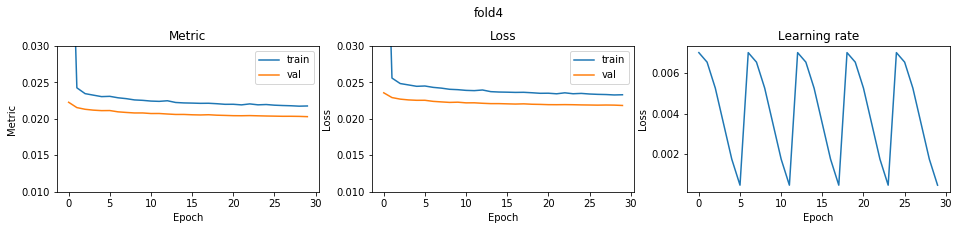

CV score: 0.02045050921976792

optimizer: AdaMod
fold 0


epoch1 save best model... 0.0198892273908324
epoch2 save best model... 0.018402006203024426
epoch3 save best model... 0.01774277338304118
epoch4 save best model... 0.017264173509964637
epoch5 save best model... 0.017002240713507547
epoch6 save best model... 0.016695372151011488
epoch11 save best model... 0.01637568981482187
epoch12 save best model... 0.016170695355768764
epoch17 save best model... 0.016147676757314076
epoch18 save best model... 0.016078374542906913
fold0 score: 0.016078374568107064


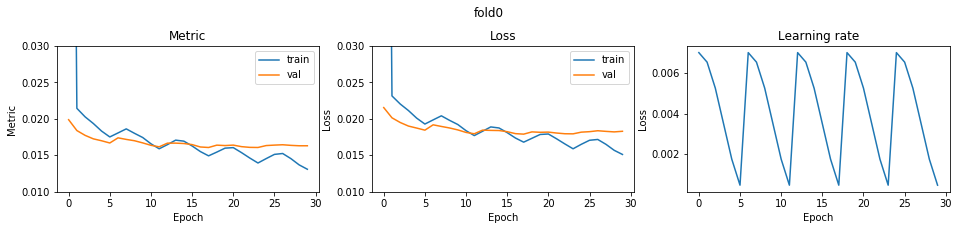

fold 1


epoch1 save best model... 0.020176038302618677
epoch2 save best model... 0.018667796789440392
epoch3 save best model... 0.017934600083977764
epoch4 save best model... 0.01755612204265122
epoch5 save best model... 0.017183583741169444
epoch6 save best model... 0.01692274108119131
epoch10 save best model... 0.016869527443956544
epoch11 save best model... 0.01656981459319062
epoch12 save best model... 0.01642072779981822
epoch17 save best model... 0.016394209803359386
epoch18 save best model... 0.016326981398458836
fold1 score: 0.016326981281565855


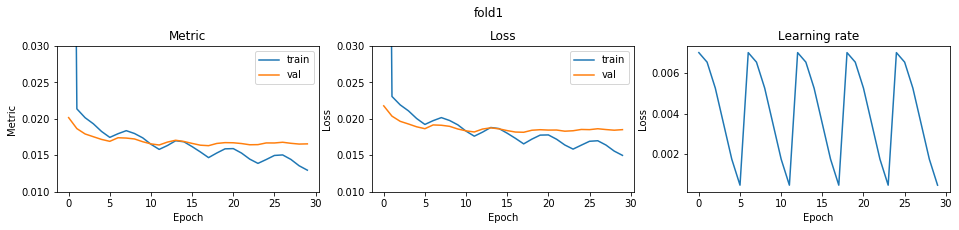

fold 2


epoch1 save best model... 0.01977689268937902
epoch2 save best model... 0.01854777767851959
epoch3 save best model... 0.017964906484868117
epoch4 save best model... 0.017432425864376967
epoch5 save best model... 0.017125541435528736
epoch6 save best model... 0.016714536810901095
epoch11 save best model... 0.016445274990816734
epoch12 save best model... 0.01626141967944076
epoch17 save best model... 0.01620784998118307
epoch18 save best model... 0.0161410805260634
fold2 score: 0.016141080479792833


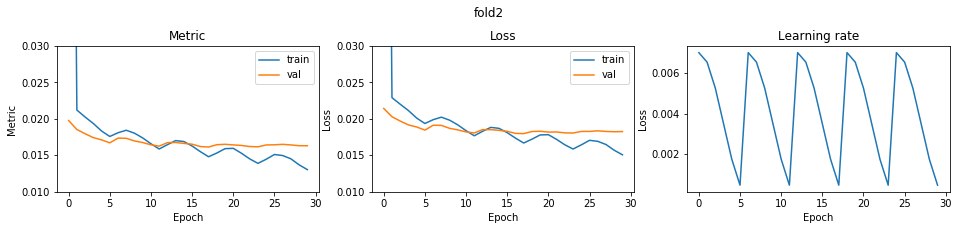

fold 3


epoch1 save best model... 0.02012958309118867
epoch2 save best model... 0.018647272825020458
epoch3 save best model... 0.018072449882219892
epoch4 save best model... 0.017604249087427498
epoch5 save best model... 0.017244049059842333
epoch6 save best model... 0.01698132491116847
epoch10 save best model... 0.016858104071187402
epoch11 save best model... 0.016674599034079522
epoch12 save best model... 0.016499666960014706
epoch17 save best model... 0.01645557229409253
epoch18 save best model... 0.016315606059952043
fold3 score: 0.016315606065997232


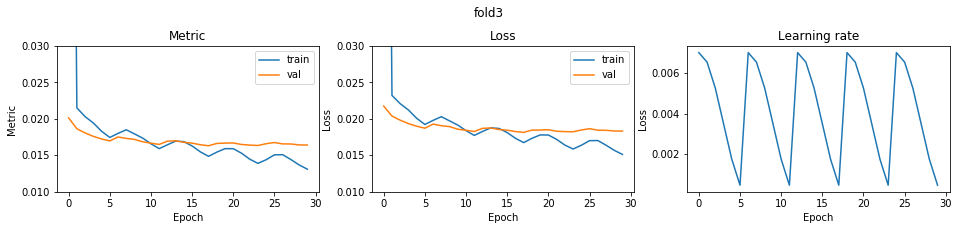

fold 4


epoch1 save best model... 0.01980199609418529
epoch2 save best model... 0.018486235006913918
epoch3 save best model... 0.018020461644374836
epoch4 save best model... 0.017571755751526166
epoch5 save best model... 0.01724253408016811
epoch6 save best model... 0.016940312598384324
epoch10 save best model... 0.01685188678910018
epoch11 save best model... 0.016639791132462188
epoch12 save best model... 0.01644726752861486
epoch17 save best model... 0.016354675742464485
epoch18 save best model... 0.01629676680146358
fold4 score: 0.016296766668968368


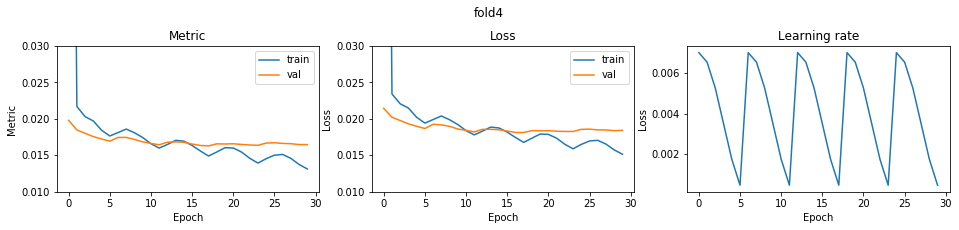

CV score: 0.016231761606118656

optimizer: AdamW
fold 0


epoch1 save best model... 0.019996053721238107
epoch2 save best model... 0.018757464625535358
epoch3 save best model... 0.017941214332615866
epoch4 save best model... 0.01739054407780154
epoch5 save best model... 0.017165013519805223
epoch6 save best model... 0.0168987995985225
epoch10 save best model... 0.01659554555536946
epoch11 save best model... 0.016443860328041338
epoch12 save best model... 0.01629149981377676
epoch16 save best model... 0.01624899443985729
epoch17 save best model... 0.016157639512032744
epoch18 save best model... 0.01611532484751899
epoch24 save best model... 0.016104460316275274
fold0 score: 0.016104460154604473


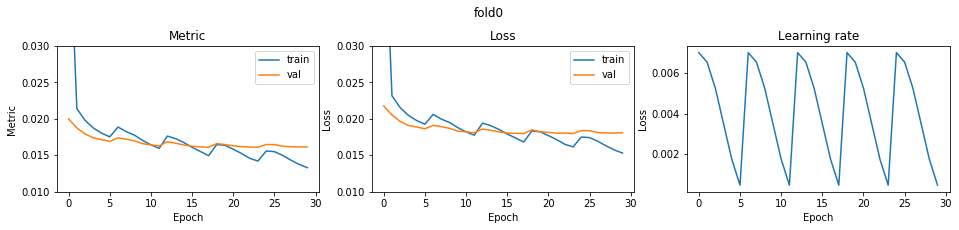

fold 1


epoch1 save best model... 0.020375805077057923
epoch2 save best model... 0.019018690878222787
epoch3 save best model... 0.018039607928204738
epoch4 save best model... 0.01769683688733023
epoch5 save best model... 0.017217895413727063
epoch6 save best model... 0.017052611560401828
epoch10 save best model... 0.01680061495193427
epoch11 save best model... 0.01667465902266544
epoch12 save best model... 0.01652674086003185
epoch16 save best model... 0.016519102327123295
epoch17 save best model... 0.016482654287579338
epoch18 save best model... 0.0164370008744936
epoch24 save best model... 0.016395039958711718
fold1 score: 0.016395039753605366


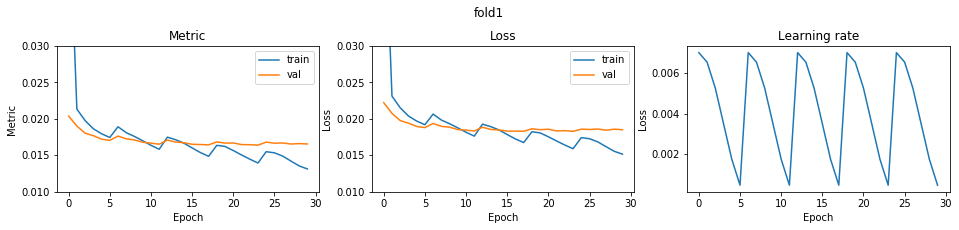

fold 2


epoch1 save best model... 0.02002532838905936
epoch2 save best model... 0.018547005847429163
epoch3 save best model... 0.017862687624547877
epoch4 save best model... 0.017375720114850134
epoch5 save best model... 0.017121853943261465
epoch6 save best model... 0.01686500519383372
epoch10 save best model... 0.01666016225047591
epoch11 save best model... 0.016402721362590356
epoch12 save best model... 0.01630442067267792
epoch17 save best model... 0.016229946215930494
epoch18 save best model... 0.016153344013031142
fold2 score: 0.016153343875027527


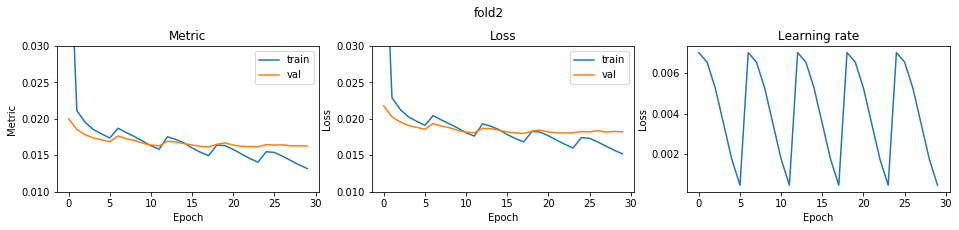

fold 3


epoch1 save best model... 0.020137940006063306
epoch2 save best model... 0.018714182870992902
epoch3 save best model... 0.017992084679153485
epoch4 save best model... 0.017531944609805093
epoch5 save best model... 0.017295479844059106
epoch6 save best model... 0.01705810699213067
epoch10 save best model... 0.016896498366630295
epoch11 save best model... 0.016644300089762937
epoch12 save best model... 0.016537449759662422
epoch17 save best model... 0.016483374448293706
epoch18 save best model... 0.016449520081400465
epoch23 save best model... 0.016439490556156854
epoch24 save best model... 0.01637506733493612
fold3 score: 0.016375067237586728


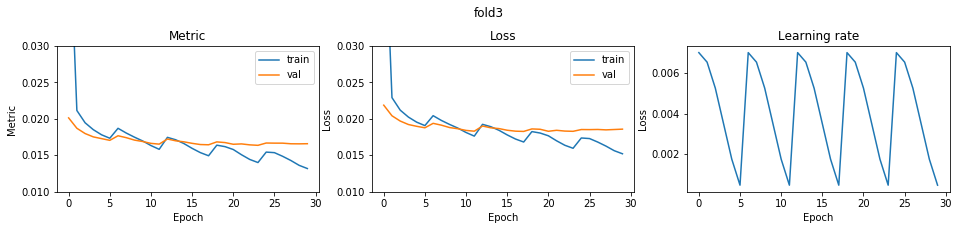

fold 4


epoch1 save best model... 0.019705968237310172
epoch2 save best model... 0.01852098256391993
epoch3 save best model... 0.017898692467285995
epoch4 save best model... 0.017372118095720954
epoch5 save best model... 0.017067511629202916
epoch6 save best model... 0.016910934655297048
epoch10 save best model... 0.01664685638820867
epoch11 save best model... 0.01651647633370139
epoch12 save best model... 0.016422585465421302
epoch16 save best model... 0.016412802918438624
epoch17 save best model... 0.01630318639693879
epoch18 save best model... 0.01625165508419343
fold4 score: 0.016251654995954504


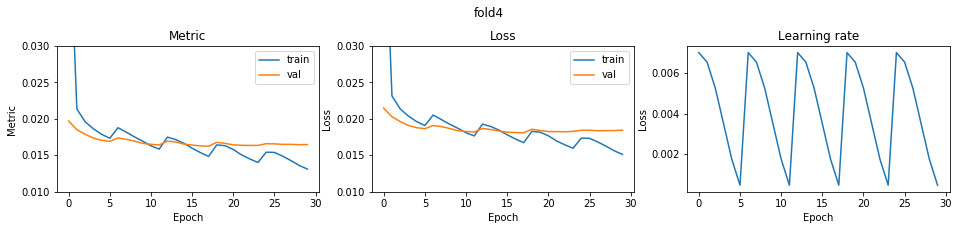

CV score: 0.01625591153772687

optimizer: AdamP
fold 0


epoch1 save best model... 0.020010140402441957
epoch2 save best model... 0.018335033431309773
epoch3 save best model... 0.0177519283043157
epoch4 save best model... 0.01733488251024471
epoch5 save best model... 0.016979223332773036
epoch6 save best model... 0.01681705691972599
epoch10 save best model... 0.016636798102281358
epoch11 save best model... 0.016402008588975274
epoch12 save best model... 0.01627343842560311
epoch17 save best model... 0.016198934002403926
epoch18 save best model... 0.016184504658985112
epoch23 save best model... 0.016181981413368483
epoch24 save best model... 0.01607362105763583
fold0 score: 0.016073620816752527


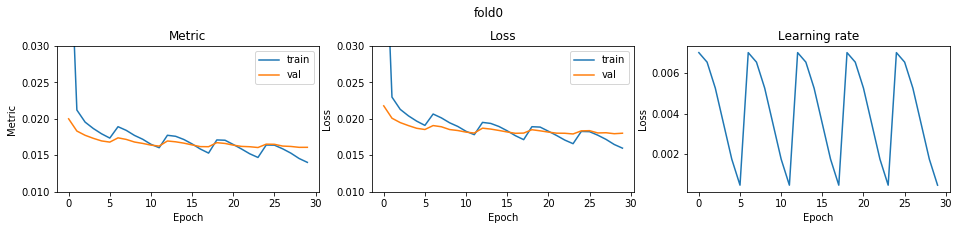

fold 1


epoch1 save best model... 0.02015281112906628
epoch2 save best model... 0.01852744938133042
epoch3 save best model... 0.018186412787323362
epoch4 save best model... 0.0174650031878889
epoch5 save best model... 0.017148795402906945
epoch6 save best model... 0.01694638825300296
epoch10 save best model... 0.01680547626776925
epoch11 save best model... 0.016560711673195446
epoch12 save best model... 0.01642991731265434
epoch18 save best model... 0.016387578923705907
epoch23 save best model... 0.01638396698994255
epoch24 save best model... 0.01631754508980873
fold1 score: 0.01631754511385718


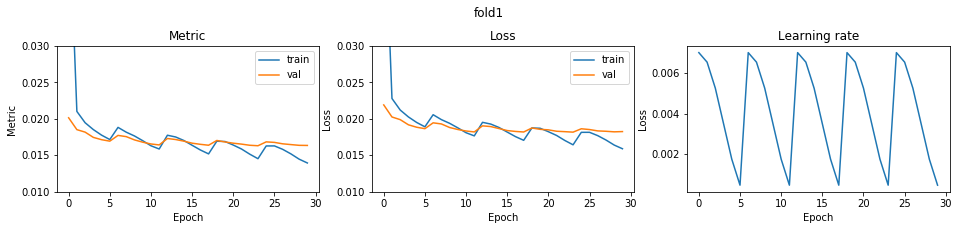

fold 2


epoch1 save best model... 0.0200029791730222
epoch2 save best model... 0.018702750084049598
epoch3 save best model... 0.017910649398191966
epoch4 save best model... 0.017293948495553033
epoch5 save best model... 0.01712183140754686
epoch6 save best model... 0.016891629303561292
epoch10 save best model... 0.016682579110366563
epoch11 save best model... 0.016437079028563187
epoch12 save best model... 0.01633279131142744
epoch17 save best model... 0.016209333702602725
epoch18 save best model... 0.016161092197343005
epoch24 save best model... 0.01615438171454227
fold2 score: 0.016154381542852914


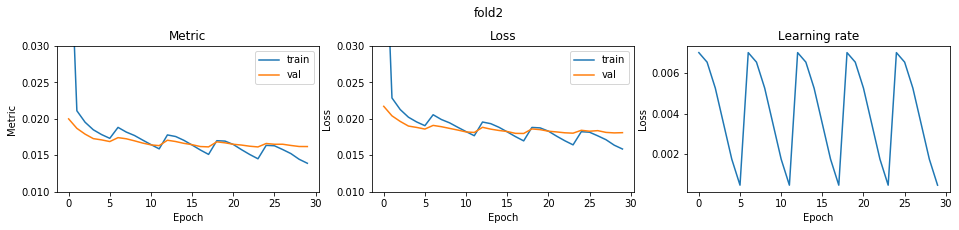

fold 3


epoch1 save best model... 0.020263874323313086
epoch2 save best model... 0.018684920037678677
epoch3 save best model... 0.018031287546734196
epoch4 save best model... 0.01741351304333954
epoch5 save best model... 0.017269988489127242
epoch6 save best model... 0.017084125296588232
epoch10 save best model... 0.016892825232941767
epoch11 save best model... 0.016662591634687366
epoch12 save best model... 0.016579498323889826
epoch17 save best model... 0.016470712890470897
epoch18 save best model... 0.01638258550112435
epoch23 save best model... 0.016373826442859167
epoch24 save best model... 0.01635561067152743
epoch30 save best model... 0.01632823638770738
fold3 score: 0.01632823631770698


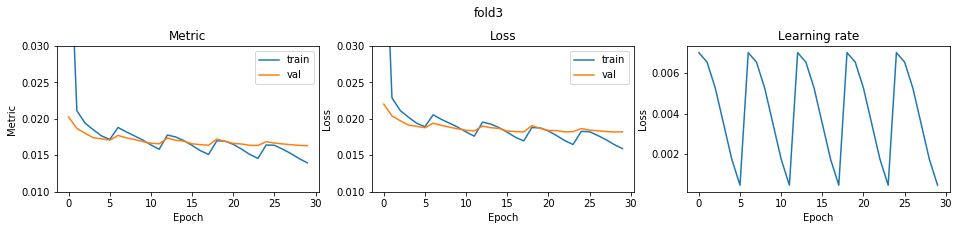

fold 4


epoch1 save best model... 0.019866815468207306
epoch2 save best model... 0.018249124711154533
epoch3 save best model... 0.01776472850615723
epoch4 save best model... 0.01736250366625251
epoch5 save best model... 0.017053751965267646
epoch6 save best model... 0.0168553086680812
epoch10 save best model... 0.016743691160358436
epoch11 save best model... 0.016617368992019217
epoch12 save best model... 0.016483281783182556
epoch17 save best model... 0.016410940938156125
epoch18 save best model... 0.016319207874697407
fold4 score: 0.01631920784241122


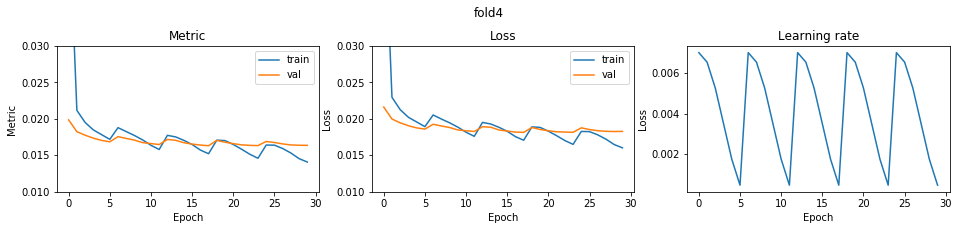

CV score: 0.016238598566829007

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.020003115259331558
epoch2 save best model... 0.018887321575457795
epoch3 save best model... 0.017950265741735222
epoch4 save best model... 0.017477631792086674
epoch5 save best model... 0.017193234196794062
epoch6 save best model... 0.016998159029183734
epoch9 save best model... 0.016989337227780347
epoch10 save best model... 0.016737668469955547
epoch11 save best model... 0.016502995177220918
epoch12 save best model... 0.016347284492843516
epoch17 save best model... 0.016220096229301907
epoch18 save best model... 0.01613796116712085
epoch23 save best model... 0.016104065233116
epoch24 save best model... 0.016053855846846023
fold0 score: 0.016053855844063835


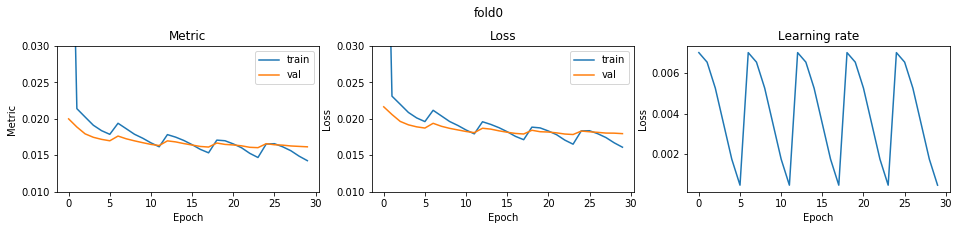

fold 1


epoch1 save best model... 0.020383917164896934
epoch2 save best model... 0.019008225220894046
epoch3 save best model... 0.018121109597213476
epoch4 save best model... 0.01772524717508538
epoch5 save best model... 0.01748766508322624
epoch6 save best model... 0.017255272074607
epoch9 save best model... 0.01718875521394611
epoch10 save best model... 0.016874566397318387
epoch11 save best model... 0.016729768364772787
epoch12 save best model... 0.016542312318421383
epoch18 save best model... 0.016474147975711312
epoch24 save best model... 0.016464064538769134
fold1 score: 0.016464064479050446


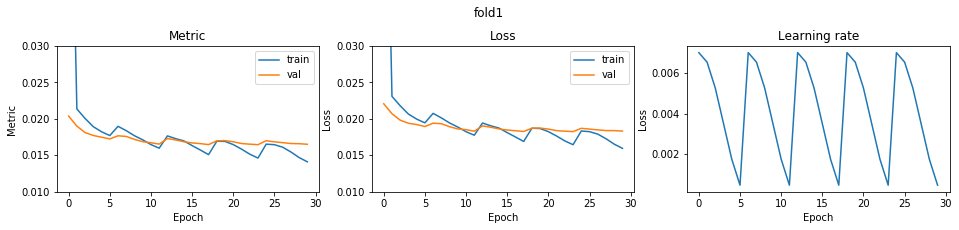

fold 2


epoch1 save best model... 0.02003452283075416
epoch2 save best model... 0.018748173056440682
epoch3 save best model... 0.018063782723643874
epoch4 save best model... 0.017650997660006742
epoch5 save best model... 0.017296278234728242
epoch6 save best model... 0.01708055360764299
epoch9 save best model... 0.017031746301108257
epoch10 save best model... 0.016674253409934236
epoch11 save best model... 0.016513193416411106
epoch12 save best model... 0.016379363197849425
epoch17 save best model... 0.016337377674696004
epoch18 save best model... 0.016209059124347776
epoch24 save best model... 0.016143032086949043
fold2 score: 0.01614303197967173


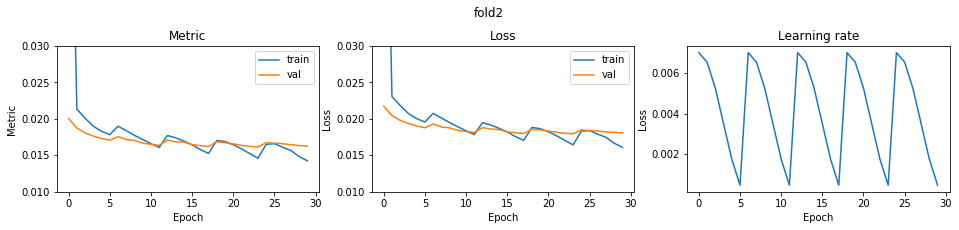

fold 3


epoch1 save best model... 0.02008911781013012
epoch2 save best model... 0.019004437065596326
epoch3 save best model... 0.018202477734289842
epoch4 save best model... 0.017718530321973194
epoch5 save best model... 0.017387190148455
epoch6 save best model... 0.01721767825382106
epoch9 save best model... 0.01711319898656126
epoch10 save best model... 0.016861598255167927
epoch11 save best model... 0.01666436732994872
epoch12 save best model... 0.016537575875589273
epoch17 save best model... 0.01645165785536136
epoch18 save best model... 0.016431881716063326
epoch23 save best model... 0.016423244812103638
epoch24 save best model... 0.016411752940700783
fold3 score: 0.016411752946646187


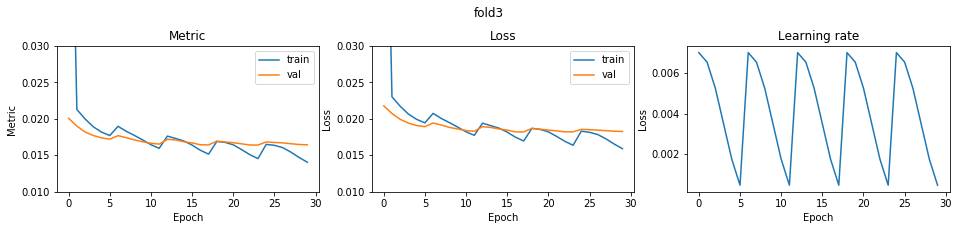

fold 4


epoch1 save best model... 0.019885098751727705
epoch2 save best model... 0.018694474254490844
epoch3 save best model... 0.017883895855643074
epoch4 save best model... 0.017503653846443513
epoch5 save best model... 0.017226806416649344
epoch6 save best model... 0.017088206927026867
epoch10 save best model... 0.016808837000492766
epoch11 save best model... 0.01665736963518456
epoch12 save best model... 0.016580778902188658
epoch17 save best model... 0.01639568788680441
epoch18 save best model... 0.016325538773895802
epoch24 save best model... 0.01631350631789561
fold4 score: 0.01631350608474791


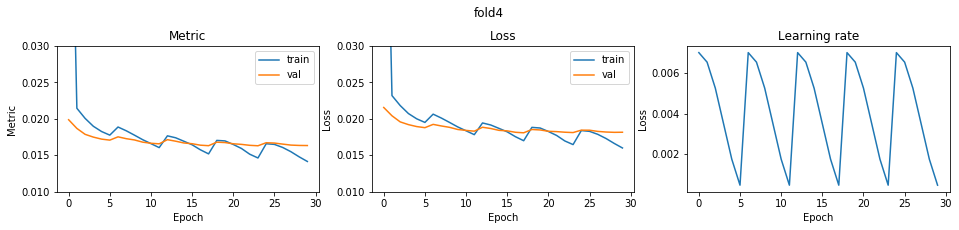

CV score: 0.016277239869718973

optimizer: Lamb
fold 0


epoch1 save best model... 0.02010494204055611
epoch2 save best model... 0.018298128507776793
epoch3 save best model... 0.017692074942527707
epoch4 save best model... 0.01737909336449209
epoch5 save best model... 0.01716185030198586
epoch6 save best model... 0.01709188883763511
epoch8 save best model... 0.01704339020395469
epoch9 save best model... 0.01675763667936613
epoch10 save best model... 0.016555516029748394
epoch11 save best model... 0.01648599558970244
epoch12 save best model... 0.016409989827416482
epoch15 save best model... 0.016351495818966885
epoch16 save best model... 0.016275265316451328
epoch17 save best model... 0.01619621356376415
epoch18 save best model... 0.016176233798316373
fold0 score: 0.016176233688970417


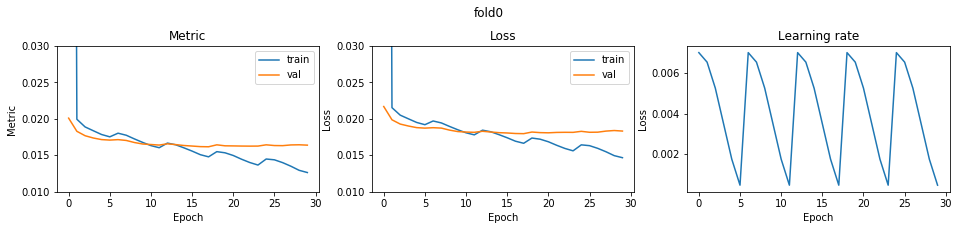

fold 1


epoch1 save best model... 0.019957665295023314
epoch2 save best model... 0.01849845960170988
epoch3 save best model... 0.01792985238822372
epoch4 save best model... 0.017529728354096386
epoch5 save best model... 0.017394288249295158
epoch6 save best model... 0.0172604107047355
epoch8 save best model... 0.01724020724933222
epoch9 save best model... 0.017141345633318195
epoch10 save best model... 0.016824032460320482
epoch11 save best model... 0.016707801923162575
epoch12 save best model... 0.016690203277905564
epoch15 save best model... 0.016646838888074413
epoch16 save best model... 0.01658929755249608
epoch17 save best model... 0.016516190563326653
epoch18 save best model... 0.016495269714324384
fold1 score: 0.016495269673121937


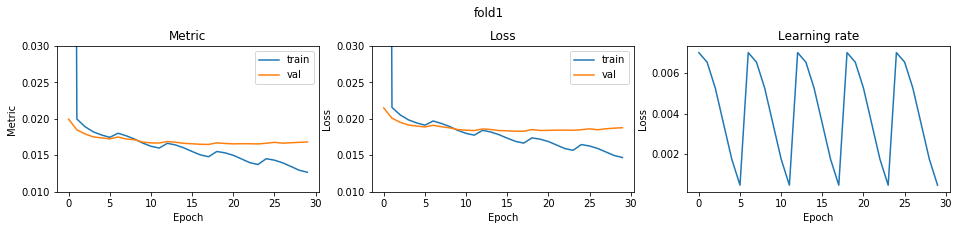

fold 2


epoch1 save best model... 0.019993410044913954
epoch2 save best model... 0.018372623705682652
epoch3 save best model... 0.017750476793814463
epoch4 save best model... 0.017371074670845525
epoch5 save best model... 0.017139170911926144
epoch6 save best model... 0.01701572716153783
epoch9 save best model... 0.016809723312177373
epoch10 save best model... 0.016593449095068432
epoch11 save best model... 0.016494268731409963
epoch12 save best model... 0.016460478963620247
epoch16 save best model... 0.016386380850951326
epoch17 save best model... 0.016292635137102794
epoch18 save best model... 0.01621080537985074
fold2 score: 0.01621080534745043


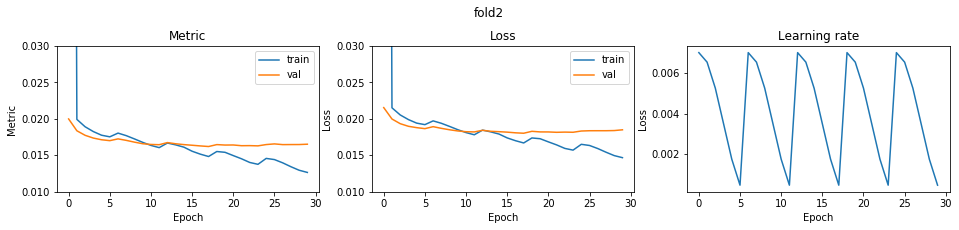

fold 3


epoch1 save best model... 0.020127360809144644
epoch2 save best model... 0.01848916027202761
epoch3 save best model... 0.01800265280966878
epoch4 save best model... 0.01766807103491386
epoch5 save best model... 0.017424797883219083
epoch6 save best model... 0.017404801194430893
epoch8 save best model... 0.017288357679199656
epoch9 save best model... 0.016988989541514996
epoch10 save best model... 0.01689215600363282
epoch11 save best model... 0.01672086000086099
epoch12 save best model... 0.01668699689565867
epoch16 save best model... 0.016594118066980655
epoch17 save best model... 0.016522022721979234
epoch18 save best model... 0.01648932640358025
fold3 score: 0.016489326231286638


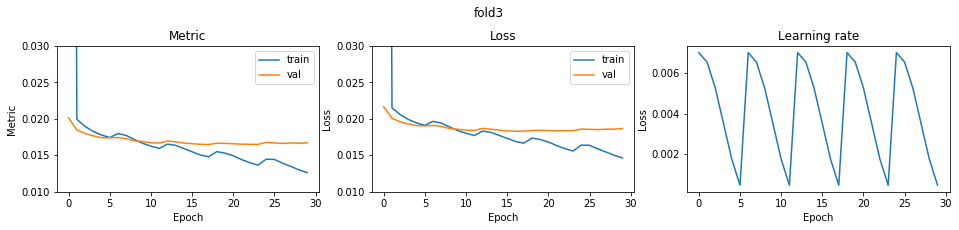

fold 4


epoch1 save best model... 0.0197326260150022
epoch2 save best model... 0.018419405408118743
epoch3 save best model... 0.017831978647797824
epoch4 save best model... 0.017497683617292748
epoch5 save best model... 0.017254500641383588
epoch6 save best model... 0.017214132512331958
epoch8 save best model... 0.017116805253834685
epoch9 save best model... 0.016896469548667074
epoch10 save best model... 0.016815734951245623
epoch11 save best model... 0.016689751071936043
epoch12 save best model... 0.016630730440241874
epoch15 save best model... 0.01659846691232268
epoch16 save best model... 0.016505683362823414
epoch17 save best model... 0.01645331415846299
epoch18 save best model... 0.01644310740529133
fold4 score: 0.016443107266874986


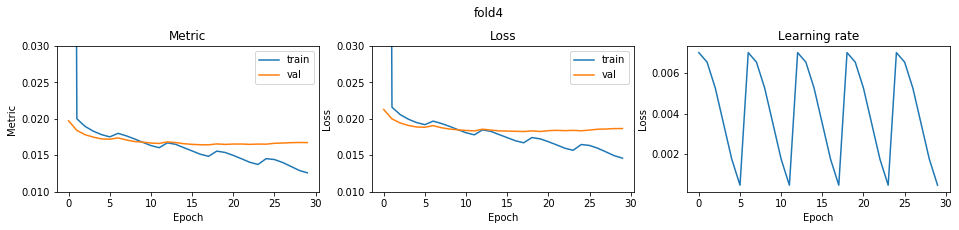

CV score: 0.0163629493446693

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018531122693371937
epoch2 save best model... 0.017655662723004412
epoch3 save best model... 0.017219879471427488
epoch4 save best model... 0.016960501630953886
epoch5 save best model... 0.016753751979737726
epoch6 save best model... 0.016698615550825156
epoch8 save best model... 0.016640133959302732
epoch9 save best model... 0.016445116882884966
epoch10 save best model... 0.01631196691720388
epoch11 save best model... 0.01626645241289109
epoch12 save best model... 0.016206205483093213
epoch15 save best model... 0.016148248752727596
epoch16 save best model... 0.016116665815828466
epoch17 save best model... 0.016061540718502226
epoch18 save best model... 0.016051763619014097
fold0 score: 0.016051763583722935


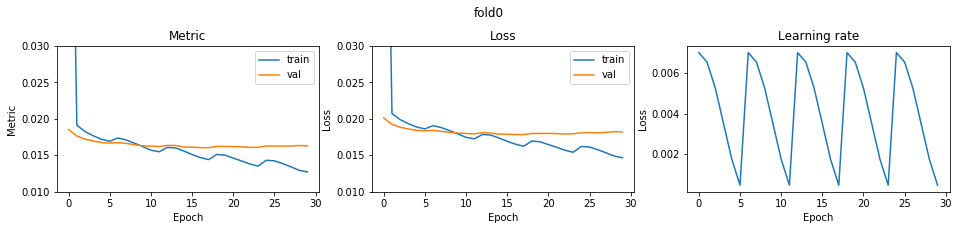

fold 1


epoch1 save best model... 0.018779059195130093
epoch2 save best model... 0.017854938861156657
epoch3 save best model... 0.017550609807665703
epoch4 save best model... 0.017181827775636628
epoch5 save best model... 0.01703869143836616
epoch6 save best model... 0.016970086187518087
epoch8 save best model... 0.016928248672507827
epoch9 save best model... 0.0167823972354061
epoch10 save best model... 0.0166536205609266
epoch11 save best model... 0.016518532462956204
epoch12 save best model... 0.016481293631027082
epoch17 save best model... 0.016475231095589994
fold1 score: 0.016475231059844622


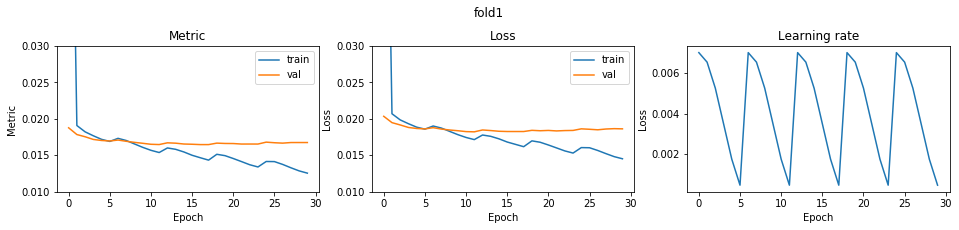

fold 2


epoch1 save best model... 0.018554663949782498
epoch2 save best model... 0.017775123345833903
epoch3 save best model... 0.017494743350383143
epoch4 save best model... 0.017038350163494895
epoch5 save best model... 0.016871535186149735
epoch6 save best model... 0.016765976748218104
epoch9 save best model... 0.01653663602085327
epoch10 save best model... 0.016385454301272282
epoch11 save best model... 0.0162901895262486
epoch12 save best model... 0.016260157587330498
epoch17 save best model... 0.016224217488869472
epoch18 save best model... 0.016202060421718692
fold2 score: 0.016202060335260438


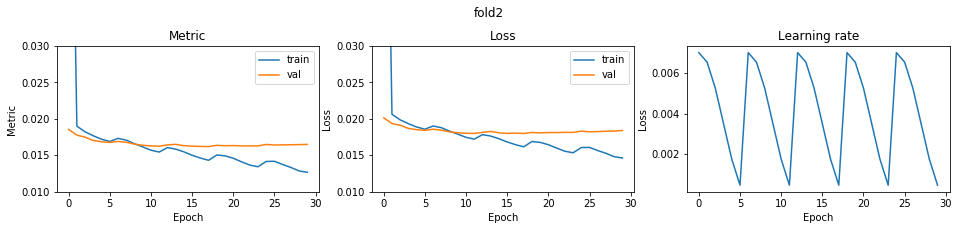

fold 3


epoch1 save best model... 0.018791236796316634
epoch2 save best model... 0.017917674822745536
epoch3 save best model... 0.017438023379984777
epoch4 save best model... 0.01721655454588439
epoch5 save best model... 0.017073537663456928
epoch6 save best model... 0.016977140145770918
epoch9 save best model... 0.01674137082171535
epoch10 save best model... 0.016580045410349183
epoch11 save best model... 0.016462307513303256
epoch12 save best model... 0.01642635116196643
epoch17 save best model... 0.016333693098319283
epoch18 save best model... 0.016319832823542636
fold3 score: 0.016319832790159108


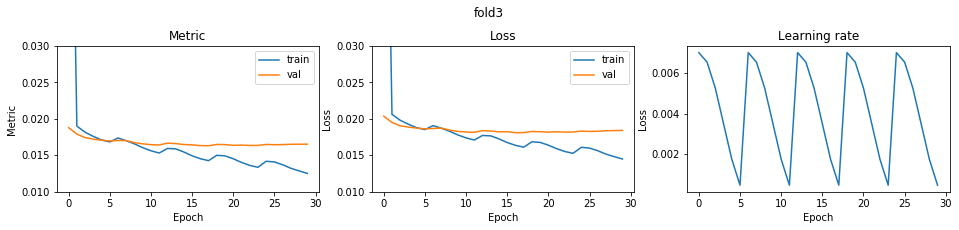

fold 4


epoch1 save best model... 0.018375516636191032
epoch2 save best model... 0.01778243571384078
epoch3 save best model... 0.01732120209316254
epoch4 save best model... 0.0171079239076118
epoch5 save best model... 0.01687412187966236
epoch6 save best model... 0.01682804428117354
epoch8 save best model... 0.01677591965612287
epoch9 save best model... 0.016669125707739443
epoch10 save best model... 0.01641392492793144
epoch11 save best model... 0.01640597815224413
epoch12 save best model... 0.01633898935202246
epoch17 save best model... 0.016254057928257896
fold4 score: 0.016254057781150716


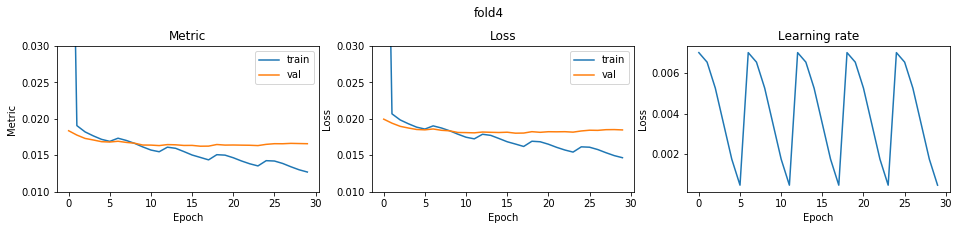

CV score: 0.016260581997161922

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.020303709164329706
epoch2 save best model... 0.018875747549947954
epoch3 save best model... 0.018294038086416782
epoch4 save best model... 0.017580154656107985
epoch5 save best model... 0.01720384293764083
epoch6 save best model... 0.016977134770406133
epoch10 save best model... 0.01665870127287229
epoch11 save best model... 0.016458381407794487
epoch12 save best model... 0.01629419345069244
epoch17 save best model... 0.01620792255043169
epoch18 save best model... 0.016133942945535742
epoch23 save best model... 0.01610226638759391
epoch24 save best model... 0.016078372463448173
fold0 score: 0.016078372512900587


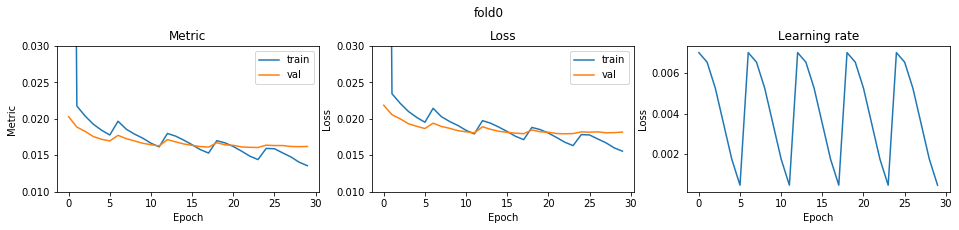

fold 1


epoch1 save best model... 0.020284443702417183
epoch2 save best model... 0.019053138499686102
epoch3 save best model... 0.01833290819695746
epoch4 save best model... 0.017719112487293832
epoch5 save best model... 0.017299713117470906
epoch6 save best model... 0.017122941631904413
epoch10 save best model... 0.016840607030998333
epoch11 save best model... 0.016706095875586104
epoch12 save best model... 0.01653547213712228
epoch17 save best model... 0.016461435413867825
epoch18 save best model... 0.016377615752358538
fold1 score: 0.016377615508498283


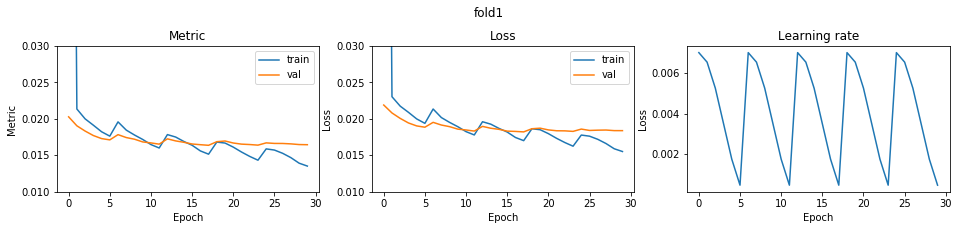

fold 2


epoch1 save best model... 0.02052278265078618
epoch2 save best model... 0.018981802850829274
epoch3 save best model... 0.018370144551088975
epoch4 save best model... 0.017716873231337346
epoch5 save best model... 0.017290166062280607
epoch6 save best model... 0.017054159760790905
epoch10 save best model... 0.01686951658913624
epoch11 save best model... 0.01657395898649886
epoch12 save best model... 0.016415671160451832
epoch17 save best model... 0.016322498295925546
epoch18 save best model... 0.016192911636261714
epoch24 save best model... 0.0161402973578341
fold2 score: 0.01614029721474458


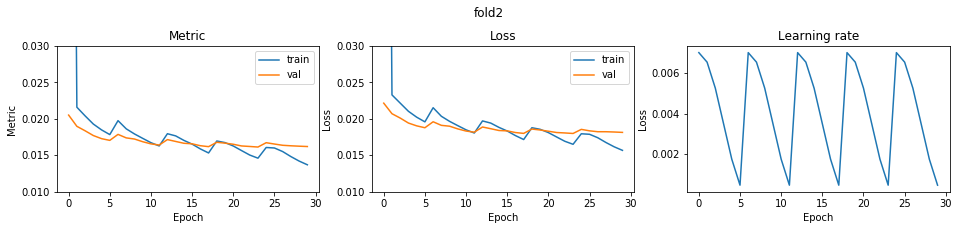

fold 3


epoch1 save best model... 0.02040702785134044
epoch2 save best model... 0.01889486646742172
epoch3 save best model... 0.018302061486828027
epoch4 save best model... 0.017902837975421637
epoch5 save best model... 0.017419252785639775
epoch6 save best model... 0.017229933174993155
epoch10 save best model... 0.016927674809865366
epoch11 save best model... 0.016832690664348542
epoch12 save best model... 0.016634067458128197
epoch17 save best model... 0.016524997134194423
epoch18 save best model... 0.016394703297670038
fold3 score: 0.01639470320440135


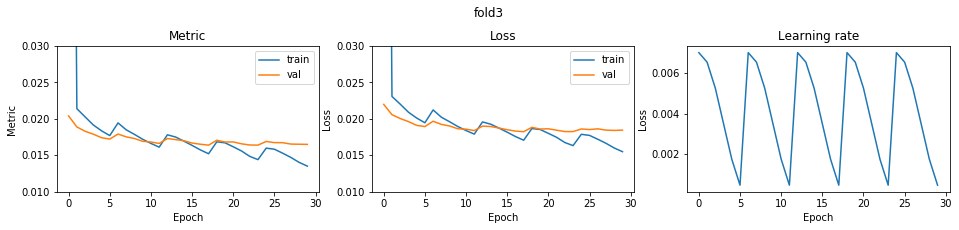

fold 4


epoch1 save best model... 0.0202620120731804
epoch2 save best model... 0.018957274115234953
epoch3 save best model... 0.01813904372529723
epoch4 save best model... 0.017704548826759387
epoch5 save best model... 0.017385174029831328
epoch6 save best model... 0.017122033163311134
epoch10 save best model... 0.016933931630520586
epoch11 save best model... 0.016692996692073643
epoch12 save best model... 0.016604260513071047
epoch17 save best model... 0.016477929320449437
epoch18 save best model... 0.016413396373306292
epoch23 save best model... 0.01636426817574846
fold4 score: 0.016364268076555475


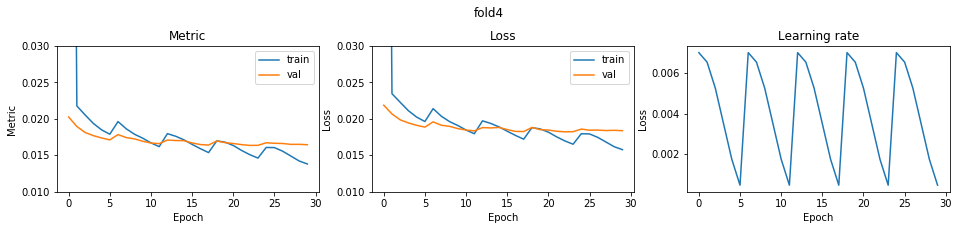

CV score: 0.01627105240556529

optimizer: QHAdam
fold 0


epoch1 save best model... 0.019855134157731213
epoch2 save best model... 0.018467690390036155
epoch3 save best model... 0.017906043143064668
epoch4 save best model... 0.017491968664296125
epoch5 save best model... 0.017083802753910932
epoch6 save best model... 0.01679795612931116
epoch11 save best model... 0.016546368811508654
epoch12 save best model... 0.01630567568301272
epoch18 save best model... 0.01622077056921696
fold0 score: 0.016220770439435567


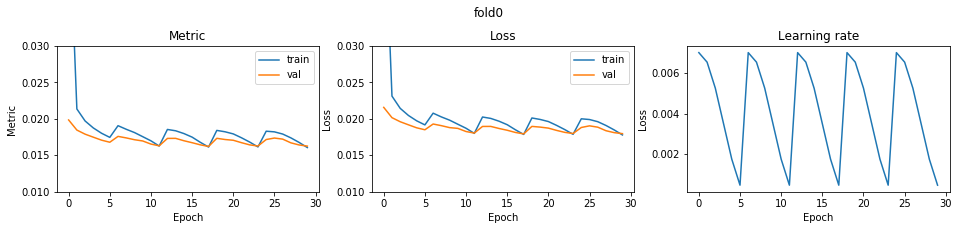

fold 1


epoch1 save best model... 0.01989786426786492
epoch2 save best model... 0.018572905780117315
epoch3 save best model... 0.018085473379399055
epoch4 save best model... 0.017543693806651
epoch5 save best model... 0.017196905564522726
epoch6 save best model... 0.01699436506212749
epoch11 save best model... 0.016813988993222336
epoch12 save best model... 0.01661281292465736
epoch18 save best model... 0.016562013007321887
epoch30 save best model... 0.016517516761368038
fold1 score: 0.016517516748367482


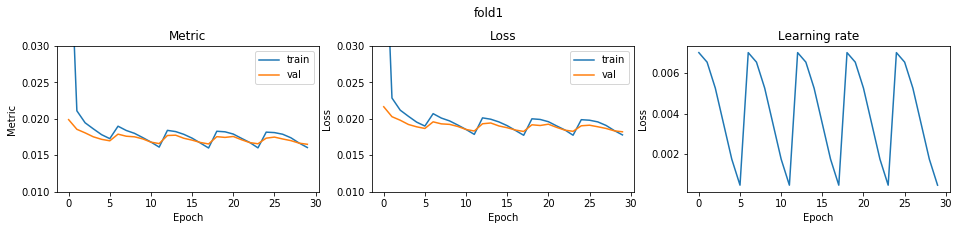

fold 2


epoch1 save best model... 0.01983225118499576
epoch2 save best model... 0.01861608485076097
epoch3 save best model... 0.018014357725952366
epoch4 save best model... 0.017422021910510864
epoch5 save best model... 0.017058468844141497
epoch6 save best model... 0.016894202770427205
epoch11 save best model... 0.016640234514935112
epoch12 save best model... 0.016426675290499102
epoch18 save best model... 0.01636039463904601
epoch24 save best model... 0.016333631578069812
epoch30 save best model... 0.016313516346011612
fold2 score: 0.016313516284258832


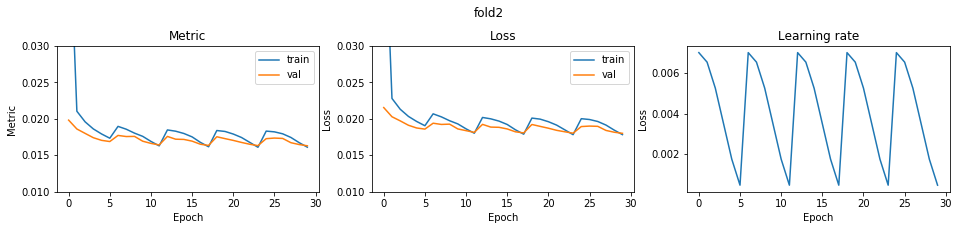

fold 3


epoch1 save best model... 0.019963221569759836
epoch2 save best model... 0.01882829411052897
epoch3 save best model... 0.01807969113077824
epoch4 save best model... 0.017610790324238276
epoch5 save best model... 0.01732440800119641
epoch6 save best model... 0.017062479641568554
epoch11 save best model... 0.0168352629323246
epoch12 save best model... 0.01665580294228632
epoch18 save best model... 0.01647593618958238
epoch24 save best model... 0.016440461772432496
fold3 score: 0.016440461723612423


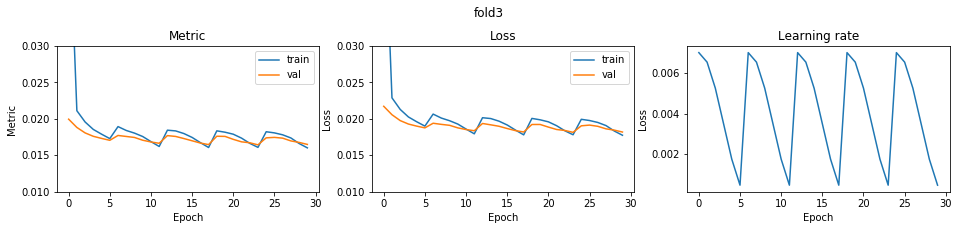

fold 4


epoch1 save best model... 0.019692827776447788
epoch2 save best model... 0.01842771023257311
epoch3 save best model... 0.017923825036030017
epoch4 save best model... 0.017396391576457268
epoch5 save best model... 0.017080975470296477
epoch6 save best model... 0.016904904326776167
epoch11 save best model... 0.016840534955942007
epoch12 save best model... 0.01656741091858485
epoch18 save best model... 0.01644676616860889
epoch24 save best model... 0.01643014119976202
epoch30 save best model... 0.01641210657767188
fold4 score: 0.016412106553447575


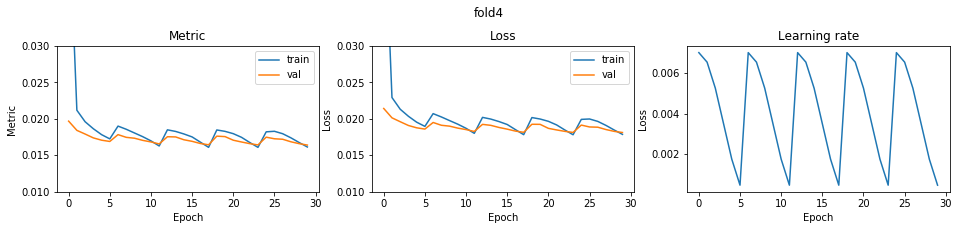

CV score: 0.016380871193075103

optimizer: RAdam
fold 0


epoch1 save best model... 0.020808600227864023
epoch2 save best model... 0.019059945088821827
epoch3 save best model... 0.017970346261435326
epoch4 save best model... 0.017537329874610305
epoch5 save best model... 0.01719204536246683
epoch6 save best model... 0.016949679605781625
epoch9 save best model... 0.016937801164653415
epoch10 save best model... 0.01663642283656331
epoch11 save best model... 0.01643199294398206
epoch12 save best model... 0.01629576312721726
epoch17 save best model... 0.016202523779115536
epoch18 save best model... 0.01612659685593735
epoch23 save best model... 0.016082393341105863
fold0 score: 0.01608239322520089


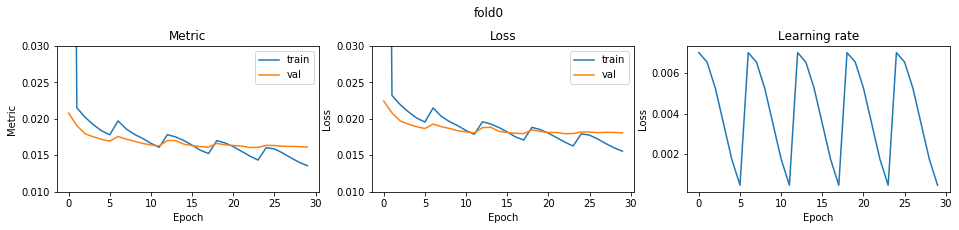

fold 1


epoch1 save best model... 0.020490937346605703
epoch2 save best model... 0.018954530436826555
epoch3 save best model... 0.01824594613043288
epoch4 save best model... 0.017746908691202243
epoch5 save best model... 0.017365343006373157
epoch6 save best model... 0.017141624969402896
epoch10 save best model... 0.016992426706118544
epoch11 save best model... 0.016712491045325933
epoch12 save best model... 0.01658850441960328
epoch17 save best model... 0.01648701166135286
epoch18 save best model... 0.016417896806876314
fold1 score: 0.01641789663356018


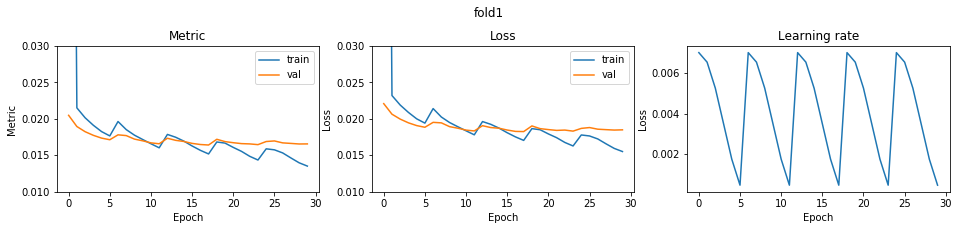

fold 2


epoch1 save best model... 0.020525460012849547
epoch2 save best model... 0.019258840057526126
epoch3 save best model... 0.018234758866167024
epoch4 save best model... 0.017762791703835615
epoch5 save best model... 0.0173364059700815
epoch6 save best model... 0.017023045704189724
epoch9 save best model... 0.017003464438895426
epoch10 save best model... 0.016713416350058623
epoch11 save best model... 0.01650447065660407
epoch12 save best model... 0.01641617530346168
epoch17 save best model... 0.016309542548336643
epoch18 save best model... 0.016204098289619006
epoch23 save best model... 0.016182894057766753
epoch24 save best model... 0.01617602608723646
fold2 score: 0.01617602595946441


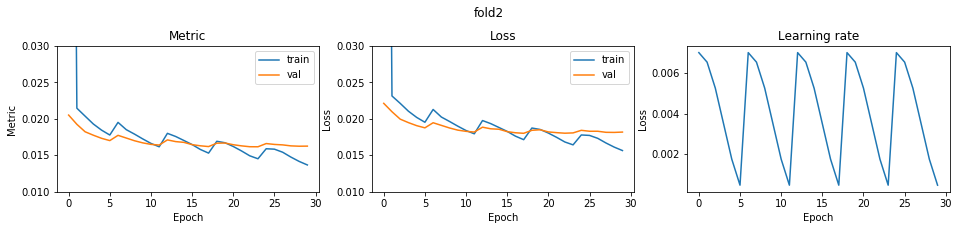

fold 3


epoch1 save best model... 0.02054652757094091
epoch2 save best model... 0.018837405576164874
epoch4 save best model... 0.017745102827006566
epoch5 save best model... 0.017418353545536756
epoch6 save best model... 0.01715291407264786
epoch10 save best model... 0.01695378169137348
epoch11 save best model... 0.016731043602923327
epoch12 save best model... 0.016597578875245295
epoch17 save best model... 0.0164851416029664
epoch18 save best model... 0.0164068878982598
epoch24 save best model... 0.01636172145740861
fold3 score: 0.01636172151942516


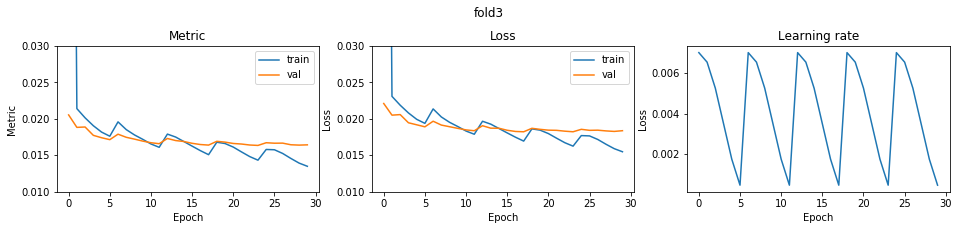

fold 4


epoch1 save best model... 0.020091699731614704
epoch2 save best model... 0.01864696642498492
epoch3 save best model... 0.017883921182525592
epoch4 save best model... 0.017438953993990508
epoch5 save best model... 0.017170592718216717
epoch6 save best model... 0.01693661534832048
epoch10 save best model... 0.016857610771894998
epoch11 save best model... 0.016556544355403182
epoch12 save best model... 0.016466009194256233
epoch17 save best model... 0.01642915285096964
epoch18 save best model... 0.0163287768738688
epoch24 save best model... 0.01632176180813538
fold4 score: 0.016321761779254703


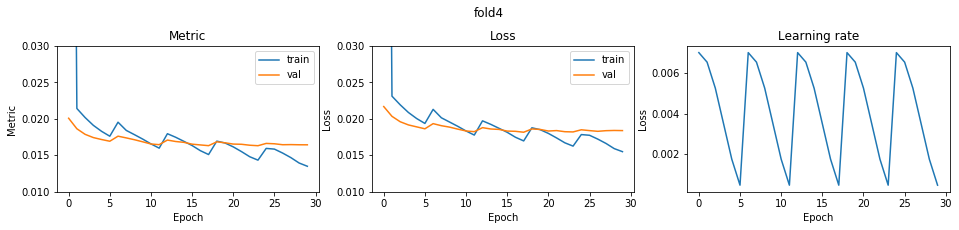

CV score: 0.01627195754513493

optimizer: Ranger
fold 0


epoch1 save best model... 0.02111640263408219
epoch2 save best model... 0.019476323600238984
epoch3 save best model... 0.018661055408401208
epoch4 save best model... 0.017984781549195493
epoch5 save best model... 0.017715528839880892
epoch6 save best model... 0.017416814243705236
epoch8 save best model... 0.017378099823629395
epoch9 save best model... 0.017015529713319755
epoch10 save best model... 0.016722658065260135
epoch11 save best model... 0.016581558971612762
epoch12 save best model... 0.01646126025697908
epoch16 save best model... 0.01635277619869671
epoch17 save best model... 0.01616793590765404
epoch18 save best model... 0.01609856614244758
epoch24 save best model... 0.016083745035535925
fold0 score: 0.016083745015856698


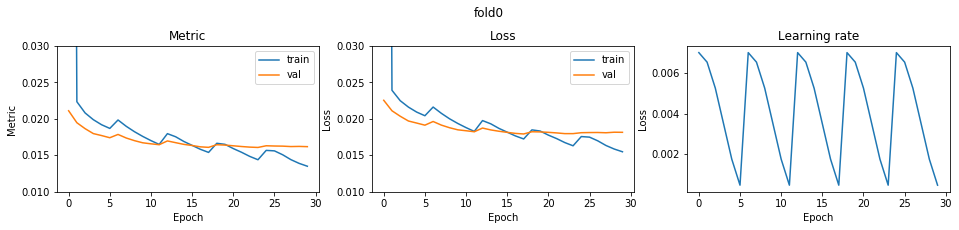

fold 1


epoch1 save best model... 0.021306869314801424
epoch2 save best model... 0.019721651694672233
epoch3 save best model... 0.018750992245203164
epoch4 save best model... 0.018130751767620787
epoch5 save best model... 0.017874087412211612
epoch6 save best model... 0.01762911329955358
epoch8 save best model... 0.017606020448858836
epoch9 save best model... 0.017294095425959274
epoch10 save best model... 0.0170185514073246
epoch11 save best model... 0.01675522818781162
epoch12 save best model... 0.016644975862247877
epoch16 save best model... 0.01660504585416768
epoch17 save best model... 0.01649935014068904
epoch18 save best model... 0.016385724563486866
fold1 score: 0.01638572449368934


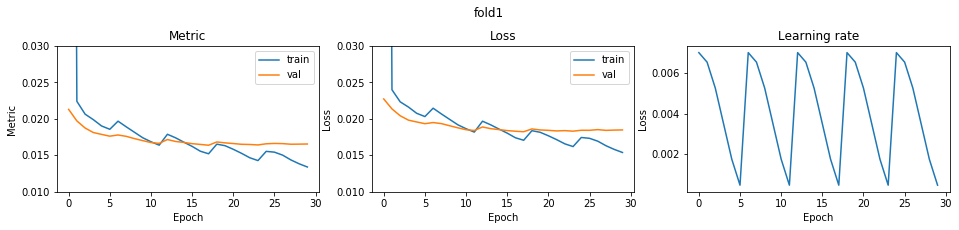

fold 2


epoch1 save best model... 0.021239698045660216
epoch2 save best model... 0.01979629951767924
epoch3 save best model... 0.018734470878741104
epoch4 save best model... 0.018004694255228045
epoch5 save best model... 0.017588802140972547
epoch6 save best model... 0.01749398005440047
epoch8 save best model... 0.017436650275460923
epoch9 save best model... 0.01712652743473822
epoch10 save best model... 0.01683654207723522
epoch11 save best model... 0.016543967891030402
epoch12 save best model... 0.016438422647153537
epoch16 save best model... 0.016381628263260475
epoch17 save best model... 0.016279477850799477
epoch18 save best model... 0.016216730161666137
epoch23 save best model... 0.016212997019951273
epoch24 save best model... 0.016164686845725425
fold2 score: 0.016164686641739357


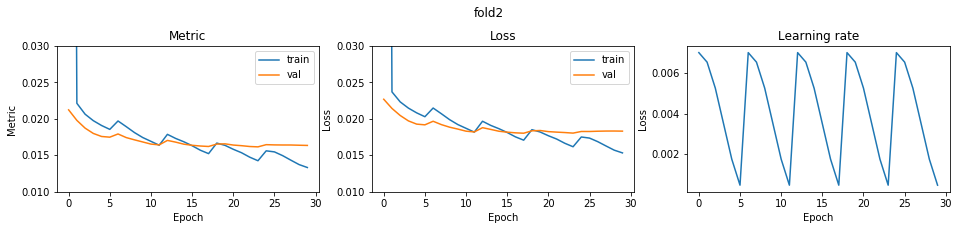

fold 3


epoch1 save best model... 0.021605978957918347
epoch2 save best model... 0.019475419391667925
epoch3 save best model... 0.018570976312312557
epoch4 save best model... 0.018010260079879152
epoch5 save best model... 0.017743544917392433
epoch6 save best model... 0.017523493213846362
epoch9 save best model... 0.01713173282513043
epoch10 save best model... 0.01696565996066313
epoch11 save best model... 0.016797814759635845
epoch12 save best model... 0.01664132664875384
epoch16 save best model... 0.016547263037320015
epoch17 save best model... 0.016509512342207117
epoch18 save best model... 0.016405203391146553
epoch24 save best model... 0.016367803805917163
fold3 score: 0.016367803638785195


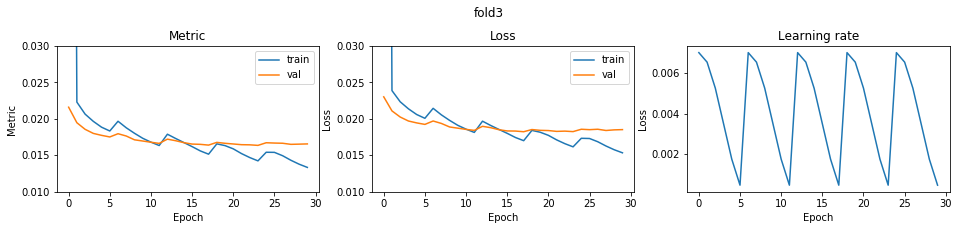

fold 4


epoch1 save best model... 0.021163215405882625
epoch2 save best model... 0.01933519116566773
epoch3 save best model... 0.01853805436054775
epoch4 save best model... 0.017909551108073535
epoch5 save best model... 0.017638384210102786
epoch6 save best model... 0.01744573079304163
epoch9 save best model... 0.017186537478331283
epoch10 save best model... 0.016927302065294806
epoch11 save best model... 0.016688372157429236
epoch12 save best model... 0.016610264294867772
epoch16 save best model... 0.016565815935119275
epoch17 save best model... 0.016421019138263406
epoch18 save best model... 0.016357360433591935
fold4 score: 0.016357360153927244


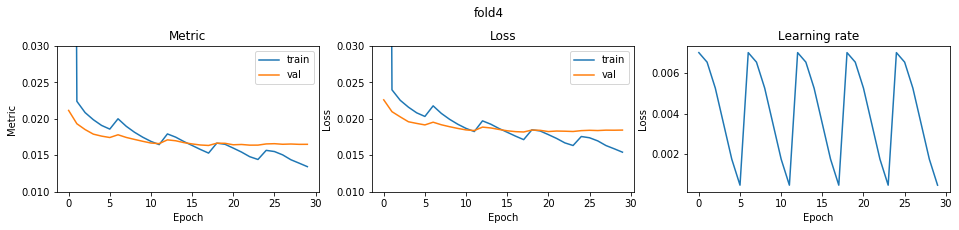

CV score: 0.01627186368429994

optimizer: RangerQH
fold 0


epoch1 save best model... 0.019961457158139736
epoch2 save best model... 0.018583543674175994
epoch3 save best model... 0.01788723651056681
epoch4 save best model... 0.01745283266694915
epoch5 save best model... 0.017099128688148866
epoch6 save best model... 0.016959760303276002
epoch9 save best model... 0.01690271058478361
epoch10 save best model... 0.016617474264989274
epoch11 save best model... 0.016386894084479246
epoch12 save best model... 0.01626347649825529
epoch17 save best model... 0.01618493299990689
epoch18 save best model... 0.016096628119570792
epoch24 save best model... 0.016093285789115012
fold0 score: 0.016093285700651522


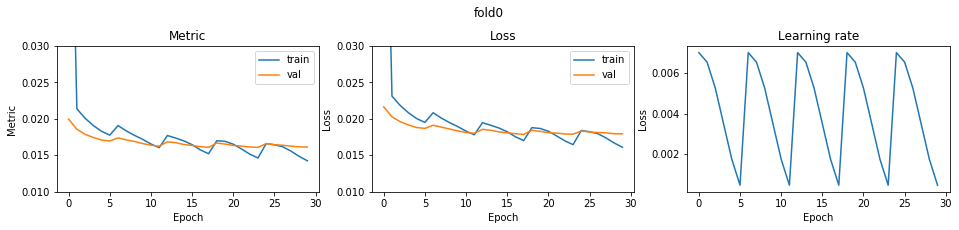

fold 1


epoch1 save best model... 0.02034343740934458
epoch2 save best model... 0.019009520616114994
epoch3 save best model... 0.01809957612914454
epoch4 save best model... 0.01775961508942604
epoch5 save best model... 0.017362515660846088
epoch6 save best model... 0.017225558265846746
epoch9 save best model... 0.01714442122882959
epoch10 save best model... 0.01690092834451559
epoch11 save best model... 0.016674347999544956
epoch12 save best model... 0.01653481386882022
epoch18 save best model... 0.01643998701932572
fold1 score: 0.016439986935773927


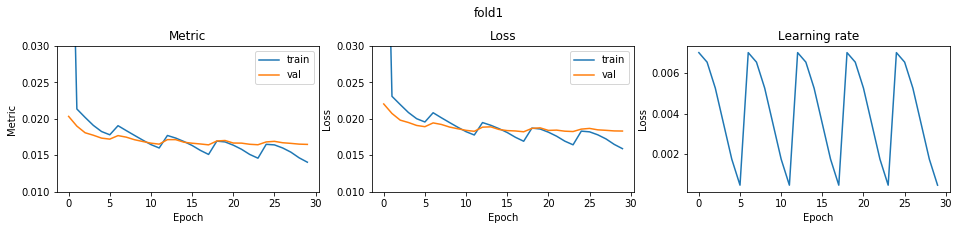

fold 2


epoch1 save best model... 0.02006923656687429
epoch2 save best model... 0.018877336590731843
epoch3 save best model... 0.018020848565586174
epoch4 save best model... 0.017566901964586806
epoch5 save best model... 0.017207243972292223
epoch6 save best model... 0.01704652398938428
epoch9 save best model... 0.016911454111724705
epoch10 save best model... 0.016645239722972497
epoch11 save best model... 0.016417418400750436
epoch12 save best model... 0.016331726691320006
epoch17 save best model... 0.016221620035938127
epoch18 save best model... 0.016176194956877978
epoch24 save best model... 0.016146013114917968
fold2 score: 0.016146013094038267


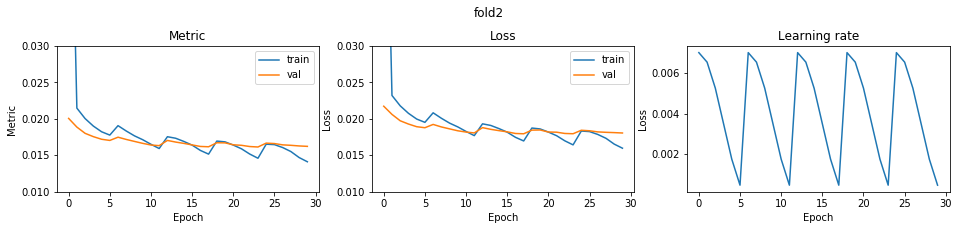

fold 3


epoch1 save best model... 0.020291876972807838
epoch2 save best model... 0.018888213334431136
epoch3 save best model... 0.018145048718025445
epoch4 save best model... 0.01767756244154957
epoch5 save best model... 0.01745345810415533
epoch6 save best model... 0.017247615046884043
epoch9 save best model... 0.017185774973353926
epoch10 save best model... 0.01689501714835406
epoch11 save best model... 0.01670541942442061
epoch12 save best model... 0.01656182003218112
epoch17 save best model... 0.01645419070441997
epoch18 save best model... 0.016382781448424
epoch23 save best model... 0.016374519847944413
epoch24 save best model... 0.016292192998229777
fold3 score: 0.01629219288870189


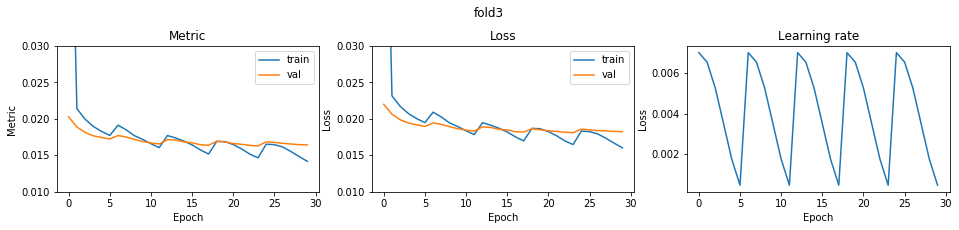

fold 4


epoch1 save best model... 0.0198649853951635
epoch2 save best model... 0.01886852986279001
epoch3 save best model... 0.01788627395368179
epoch4 save best model... 0.017484908841193945
epoch5 save best model... 0.017210726069545285
epoch6 save best model... 0.017114045338997946
epoch9 save best model... 0.017034782487517202
epoch10 save best model... 0.016844752193736188
epoch11 save best model... 0.016628320832102472
epoch12 save best model... 0.016552142228651156
epoch17 save best model... 0.016484675828392928
epoch18 save best model... 0.016389289935774983
fold4 score: 0.016389289731577803


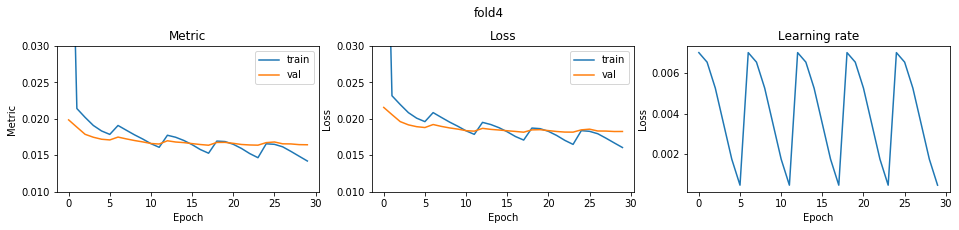

CV score: 0.01627215177053644

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5338208510283728
epoch2 save best model... 0.06508190134595358
epoch3 save best model... 0.031099237086662943
epoch4 save best model... 0.026064649169123256
epoch5 save best model... 0.024845263962729375
epoch6 save best model... 0.02447876866168612
epoch7 save best model... 0.022145714983344077
epoch8 save best model... 0.021264062136208007
epoch9 save best model... 0.02084740307224503
epoch10 save best model... 0.020612254854215306
epoch11 save best model... 0.02055970352728573
epoch13 save best model... 0.020205835907259672
epoch14 save best model... 0.019931223770446548
epoch15 save best model... 0.01979440464924571
epoch16 save best model... 0.019724208750424733
epoch17 save best model... 0.019640301848530498
epoch18 save best model... 0.01963788793084969
epoch19 save best model... 0.019454205502036765
epoch20 save best model... 0.019345036043800362
epoch21 save best model... 0.019173860170609045
epoch22 save best model... 0.019098455367232238
epoch23 s

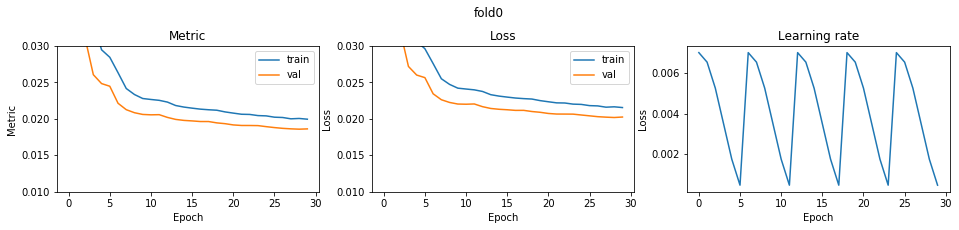

fold 1


epoch1 save best model... 0.5396133745469002
epoch2 save best model... 0.06629655294597325
epoch3 save best model... 0.031170105366819294
epoch4 save best model... 0.02610778648683818
epoch5 save best model... 0.02480325214462947
epoch6 save best model... 0.024494166763303734
epoch7 save best model... 0.022137087546789745
epoch8 save best model... 0.02131373264442125
epoch9 save best model... 0.020866247939697484
epoch10 save best model... 0.020696925441994432
epoch12 save best model... 0.02060092480394435
epoch13 save best model... 0.020278778543373698
epoch14 save best model... 0.01999694012159787
epoch15 save best model... 0.01991627679611086
epoch16 save best model... 0.01978257531671528
epoch17 save best model... 0.019744748190659873
epoch19 save best model... 0.019532338776565218
epoch20 save best model... 0.019446853364103338
epoch21 save best model... 0.019326767230422953
epoch22 save best model... 0.01923544397995667
epoch23 save best model... 0.019200382318783116
epoch24 save

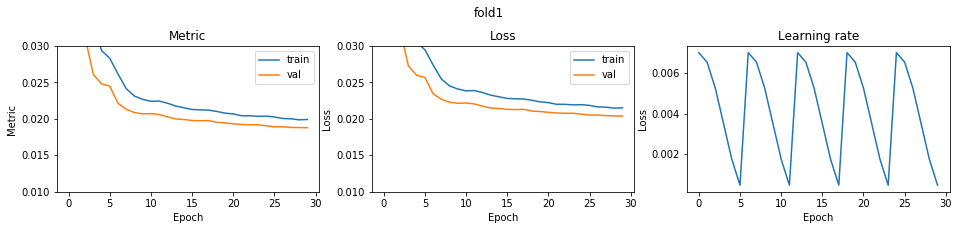

fold 2


epoch1 save best model... 0.536561352526525
epoch2 save best model... 0.0652692718093964
epoch3 save best model... 0.031189105662099863
epoch4 save best model... 0.02630423294203337
epoch5 save best model... 0.024888185269436335
epoch6 save best model... 0.024632523800540308
epoch7 save best model... 0.022259233361986454
epoch8 save best model... 0.021376629311427572
epoch9 save best model... 0.02102986717540206
epoch10 save best model... 0.020810610769406948
epoch11 save best model... 0.020686202311001788
epoch12 save best model... 0.02065957235212708
epoch13 save best model... 0.020410453225915674
epoch14 save best model... 0.02010805354856581
epoch15 save best model... 0.0199746391775227
epoch16 save best model... 0.0198613796442557
epoch17 save best model... 0.019814624719527132
epoch19 save best model... 0.019595606188468277
epoch20 save best model... 0.01947054467156553
epoch21 save best model... 0.019335751882424302
epoch22 save best model... 0.019224954986302695
epoch23 save be

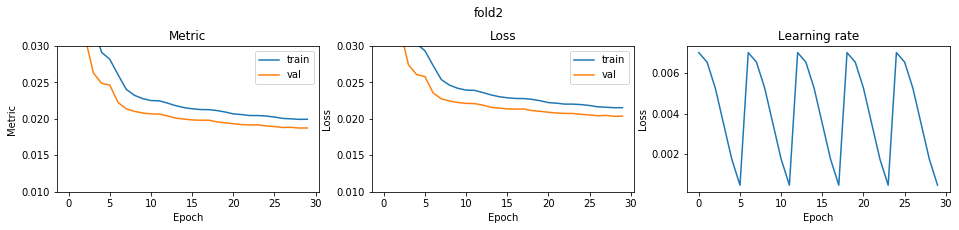

fold 3


epoch1 save best model... 0.5254731758580392
epoch2 save best model... 0.06314883431534289
epoch3 save best model... 0.030913173148497633
epoch4 save best model... 0.026229604990444313
epoch5 save best model... 0.02492147244105714
epoch6 save best model... 0.024446411502116905
epoch7 save best model... 0.022260276097507303
epoch8 save best model... 0.021488509777772127
epoch9 save best model... 0.021070566708922114
epoch10 save best model... 0.020921755408134166
epoch11 save best model... 0.02076548322577004
epoch13 save best model... 0.02050774233343593
epoch14 save best model... 0.02032060056865419
epoch15 save best model... 0.020155674164397706
epoch16 save best model... 0.02002721797878555
epoch18 save best model... 0.020009406522374627
epoch19 save best model... 0.019793030454995694
epoch20 save best model... 0.01967180757603029
epoch21 save best model... 0.019511586914352376
epoch22 save best model... 0.019438719196172946
epoch23 save best model... 0.019429579967365586
epoch24 sa

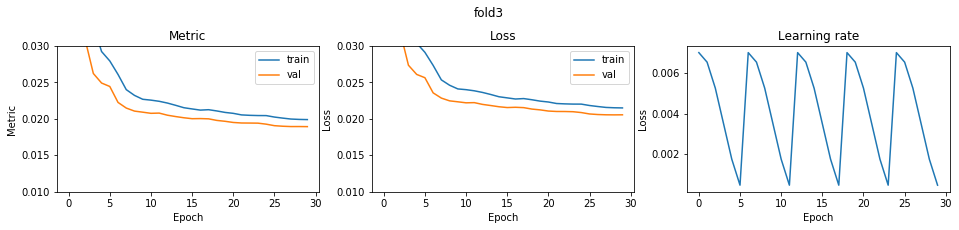

fold 4


epoch1 save best model... 0.5332992822271273
epoch2 save best model... 0.0644709481533133
epoch3 save best model... 0.030271238041935586
epoch4 save best model... 0.02566804763922523
epoch5 save best model... 0.02456443524560923
epoch6 save best model... 0.024278315827080763
epoch7 save best model... 0.022001791273610738
epoch8 save best model... 0.021254496048109136
epoch9 save best model... 0.020791506016274792
epoch10 save best model... 0.020544851912452856
epoch11 save best model... 0.02048227637921352
epoch13 save best model... 0.020177574217285544
epoch14 save best model... 0.020004375303558718
epoch15 save best model... 0.019888864089321168
epoch16 save best model... 0.019742325046746768
epoch17 save best model... 0.019689414379503025
epoch19 save best model... 0.019494087310987344
epoch20 save best model... 0.019339313083126766
epoch21 save best model... 0.0192212443883639
epoch22 save best model... 0.019158014813798706
epoch23 save best model... 0.019101566142468353
epoch24 sa

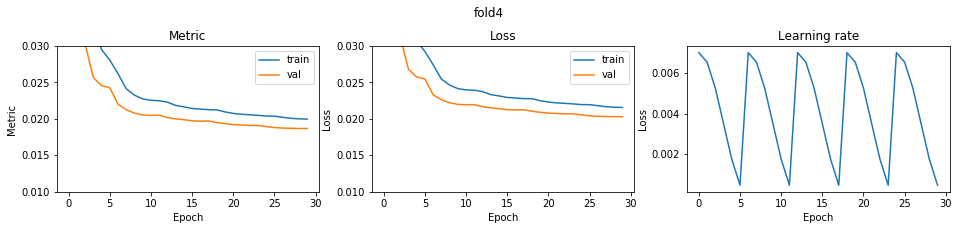

CV score: 0.018749587566830088

optimizer: SWATS
fold 0


epoch1 save best model... 0.020501153697185474
epoch2 save best model... 0.018961169846474717
epoch3 save best model... 0.01847482849175539
epoch4 save best model... 0.017901517171624852
epoch5 save best model... 0.017747337743639947
epoch6 save best model... 0.017666130233768177
epoch7 save best model... 0.017615462489137618
epoch8 save best model... 0.017298267812283545
epoch9 save best model... 0.017164653878243202
epoch10 save best model... 0.016978097967548903
epoch11 save best model... 0.01688305522168823
epoch12 save best model... 0.016820486816567008
epoch14 save best model... 0.01675396659379668
epoch15 save best model... 0.016638363666985193
epoch16 save best model... 0.016509746647268057
epoch17 save best model... 0.016442236386595935
epoch18 save best model... 0.016415768654715772
epoch21 save best model... 0.016292874988567314
epoch22 save best model... 0.016239957325584795
epoch23 save best model... 0.016189838469809172
epoch24 save best model... 0.016176582726062295
epoc

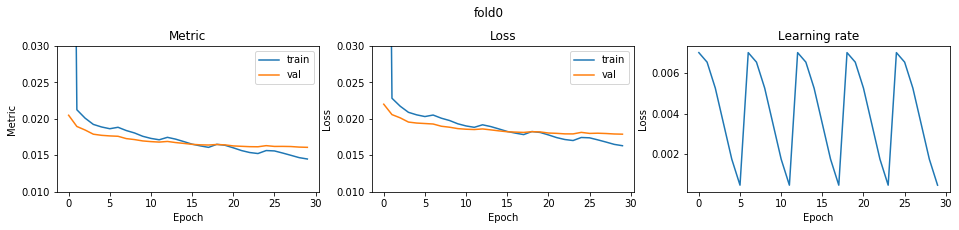

fold 1


epoch1 save best model... 0.02037674609480876
epoch2 save best model... 0.019094448184391228
epoch3 save best model... 0.018314605907257583
epoch4 save best model... 0.01798651764442218
epoch5 save best model... 0.017855988312949756
epoch6 save best model... 0.01776229501310392
epoch7 save best model... 0.01764219105803877
epoch8 save best model... 0.01734262108454796
epoch9 save best model... 0.0172483956754907
epoch10 save best model... 0.01710720700215006
epoch11 save best model... 0.016985485563638218
epoch12 save best model... 0.016968045180833648
epoch14 save best model... 0.01690288188008519
epoch15 save best model... 0.016802930380698352
epoch16 save best model... 0.016717641845881925
epoch17 save best model... 0.016658787782170094
epoch18 save best model... 0.01661262157977673
epoch22 save best model... 0.01654150107555901
epoch23 save best model... 0.01647521043185711
epoch24 save best model... 0.016435331643123403
epoch30 save best model... 0.016414891067348246
fold1 score: 

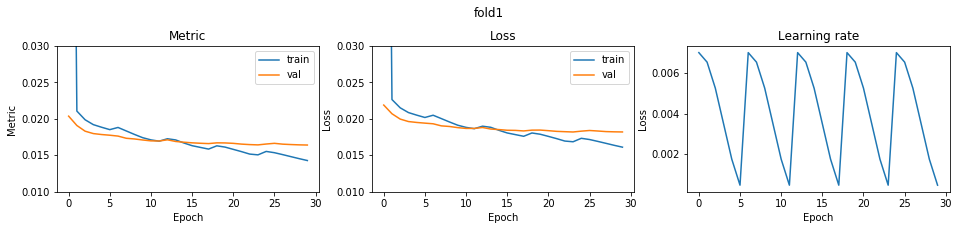

fold 2


epoch1 save best model... 0.020427087878676396
epoch2 save best model... 0.019012338543804325
epoch3 save best model... 0.01836193548517561
epoch4 save best model... 0.017855363691726002
epoch5 save best model... 0.017681086800676742
epoch6 save best model... 0.017646993630951686
epoch7 save best model... 0.017506141386591755
epoch8 save best model... 0.01735180872900967
epoch9 save best model... 0.017143434053424837
epoch10 save best model... 0.016983402727435325
epoch11 save best model... 0.016791221969411893
epoch12 save best model... 0.016777964589803712
epoch14 save best model... 0.01673946703202118
epoch15 save best model... 0.016563580909777432
epoch16 save best model... 0.01654551849134163
epoch17 save best model... 0.01645788615860179
epoch18 save best model... 0.01638183543425903
epoch23 save best model... 0.016315424291760333
epoch24 save best model... 0.01627269352211832
epoch29 save best model... 0.01625406371306914
epoch30 save best model... 0.016239687279045012
fold2 sco

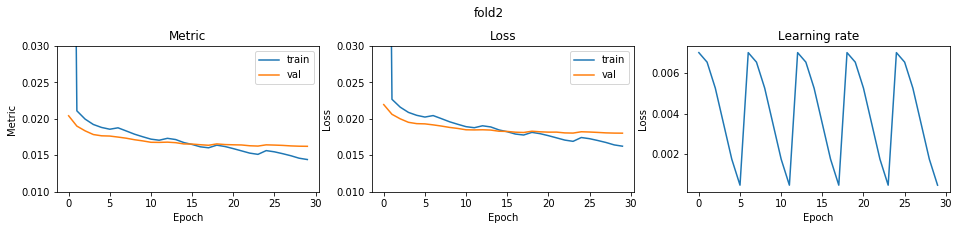

fold 3


epoch1 save best model... 0.020567794364785823
epoch2 save best model... 0.01926942806656988
epoch3 save best model... 0.018525025904908402
epoch4 save best model... 0.01815212757447586
epoch5 save best model... 0.01798660883803031
epoch6 save best model... 0.01788977359109696
epoch7 save best model... 0.01780704754767494
epoch8 save best model... 0.017513244020368624
epoch9 save best model... 0.017251476821975448
epoch10 save best model... 0.017233781430420543
epoch11 save best model... 0.017151871277761892
epoch12 save best model... 0.01703745789257364
epoch14 save best model... 0.01698515492115925
epoch15 save best model... 0.01690742744849931
epoch16 save best model... 0.01679546741094092
epoch17 save best model... 0.01674425166422726
epoch18 save best model... 0.01673441464951207
epoch21 save best model... 0.016636790770078437
epoch22 save best model... 0.016606971055931136
epoch23 save best model... 0.0165292395889793
epoch24 save best model... 0.0164869378628485
epoch28 save bes

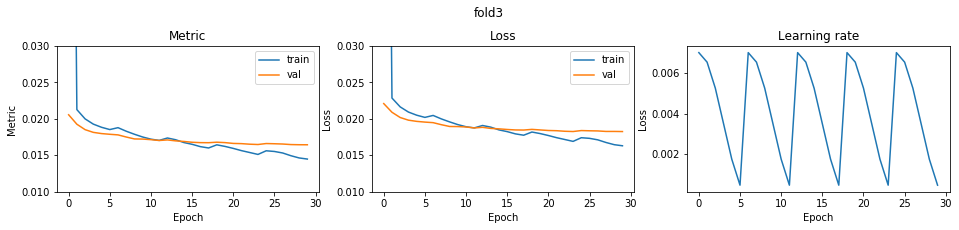

fold 4


epoch1 save best model... 0.020111991078985307
epoch2 save best model... 0.018816186948456635
epoch3 save best model... 0.01830547964688314
epoch4 save best model... 0.017904079116134137
epoch5 save best model... 0.017672662238393123
epoch6 save best model... 0.017636617454689564
epoch7 save best model... 0.017557078819289158
epoch8 save best model... 0.017398065730827545
epoch9 save best model... 0.01718701493156255
epoch10 save best model... 0.017035333169008984
epoch11 save best model... 0.016934980331985854
epoch12 save best model... 0.016913091253429855
epoch14 save best model... 0.0168059444886575
epoch15 save best model... 0.01678098405335854
epoch16 save best model... 0.016661624345665368
epoch17 save best model... 0.016579820183031516
epoch18 save best model... 0.016565141218856553
epoch20 save best model... 0.016547094859556213
epoch21 save best model... 0.016495662126987155
epoch22 save best model... 0.016432952663197196
epoch23 save best model... 0.01638667424992236
epoch24

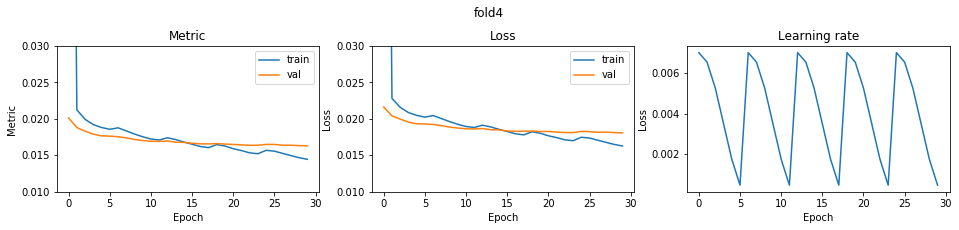

CV score: 0.0163040665384561

optimizer: Yogi
fold 0


epoch1 save best model... 0.020558650829831396
epoch2 save best model... 0.019195629460291602
epoch3 save best model... 0.0186101574875024
epoch4 save best model... 0.018251691566003755
epoch5 save best model... 0.01808809317512637
epoch6 save best model... 0.018059933269587356
epoch7 save best model... 0.017844521112587296
epoch8 save best model... 0.01759977767791319
epoch9 save best model... 0.01735463562784271
epoch10 save best model... 0.017255411922490405
epoch11 save best model... 0.017148628128280944
epoch13 save best model... 0.017126291970762684
epoch14 save best model... 0.017005597330748627
epoch15 save best model... 0.0168366022968075
epoch16 save best model... 0.016724176031955282
epoch17 save best model... 0.016709273479081233
epoch20 save best model... 0.01655412855428688
epoch21 save best model... 0.016524773143690104
epoch22 save best model... 0.016462100770723305
epoch23 save best model... 0.0164092667808158
epoch24 save best model... 0.01638294550969959
epoch27 save

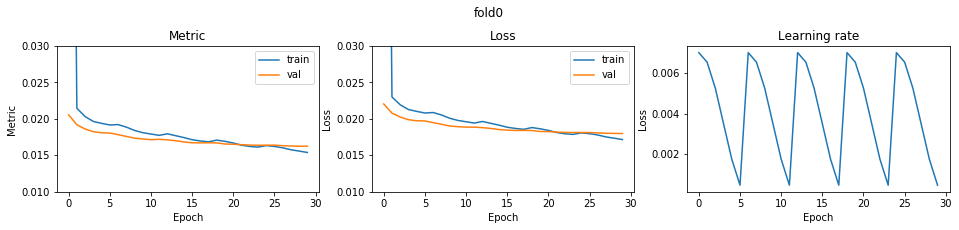

fold 1


epoch1 save best model... 0.020417869357974877
epoch2 save best model... 0.019215477880037003
epoch3 save best model... 0.018664221883017047
epoch4 save best model... 0.018293924428527678
epoch5 save best model... 0.018095640540734106
epoch7 save best model... 0.017903456767848262
epoch8 save best model... 0.017632206999093097
epoch9 save best model... 0.017461594593948644
epoch10 save best model... 0.017317877919853453
epoch11 save best model... 0.01727512565318993
epoch12 save best model... 0.01725532574798529
epoch13 save best model... 0.017241284178642482
epoch14 save best model... 0.01714694240497793
epoch15 save best model... 0.017034436718451052
epoch16 save best model... 0.016960279876016136
epoch17 save best model... 0.01687746156557909
epoch18 save best model... 0.01685237233677875
epoch20 save best model... 0.016785910064055345
epoch21 save best model... 0.016743982897841812
epoch22 save best model... 0.016664716750587085
epoch23 save best model... 0.01664555267536727
epoch2

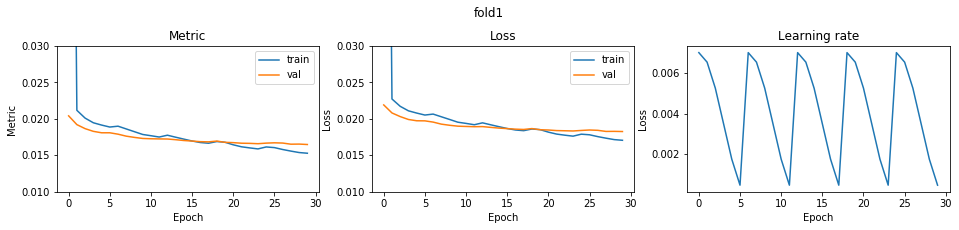

fold 2


epoch1 save best model... 0.02058340110840464
epoch2 save best model... 0.019367001469907604
epoch3 save best model... 0.018631673342656318
epoch4 save best model... 0.018355166741559188
epoch5 save best model... 0.018148838190158573
epoch6 save best model... 0.018095529824113363
epoch7 save best model... 0.017948969737107797
epoch8 save best model... 0.017623518776308977
epoch9 save best model... 0.017496160300069556
epoch10 save best model... 0.017326876795902682
epoch11 save best model... 0.01725240186850739
epoch12 save best model... 0.01716805560784667
epoch14 save best model... 0.017016070592943914
epoch15 save best model... 0.016972501280317142
epoch16 save best model... 0.01682399272601258
epoch17 save best model... 0.01674682484321359
epoch18 save best model... 0.01672886664442095
epoch20 save best model... 0.01663489094715736
epoch21 save best model... 0.016623926999997606
epoch22 save best model... 0.016531757224630416
epoch23 save best model... 0.016510984846567968
epoch24 

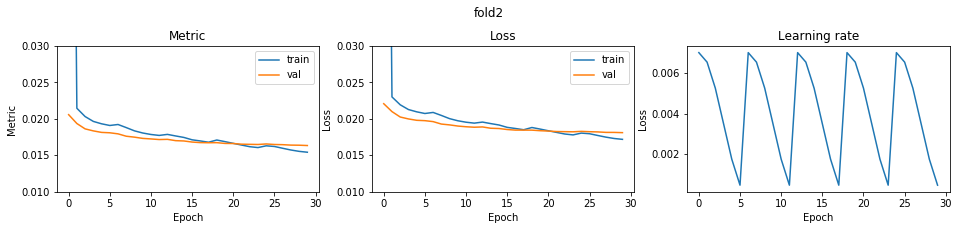

fold 3


epoch1 save best model... 0.02065013955031142
epoch2 save best model... 0.019510964268143874
epoch3 save best model... 0.018768134100069896
epoch4 save best model... 0.01840734289734198
epoch5 save best model... 0.018301952815273085
epoch6 save best model... 0.018240025544916716
epoch7 save best model... 0.017976188435217106
epoch8 save best model... 0.01777898788596408
epoch9 save best model... 0.017590443771290074
epoch10 save best model... 0.017427887389508494
epoch11 save best model... 0.0173929077460683
epoch12 save best model... 0.01738129381540153
epoch14 save best model... 0.017207321983280514
epoch15 save best model... 0.017123510998701318
epoch16 save best model... 0.017052902354262683
epoch17 save best model... 0.016950104168800804
epoch18 save best model... 0.016917283746471164
epoch20 save best model... 0.01691170532069676
epoch21 save best model... 0.016761343872306152
epoch22 save best model... 0.01669914162079199
epoch24 save best model... 0.016645575348703628
epoch27 s

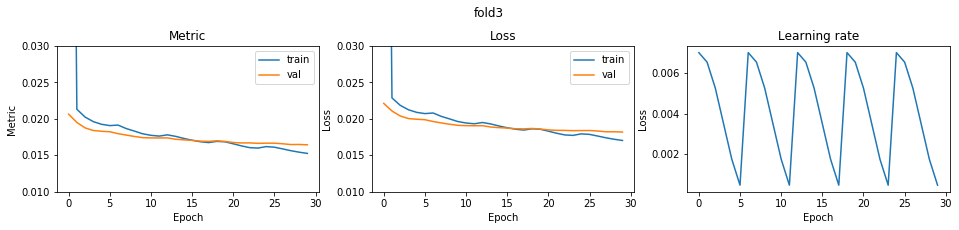

fold 4


epoch1 save best model... 0.020382402377343123
epoch2 save best model... 0.019247208711328432
epoch3 save best model... 0.018646988450021298
epoch4 save best model... 0.018288068474187666
epoch5 save best model... 0.01816181310183095
epoch6 save best model... 0.01810737463024048
epoch7 save best model... 0.017837965903816436
epoch8 save best model... 0.017752152175169462
epoch9 save best model... 0.017504951748190816
epoch10 save best model... 0.017410638482481717
epoch11 save best model... 0.017318430532338544
epoch12 save best model... 0.017292734276257236
epoch13 save best model... 0.017263197839888056
epoch14 save best model... 0.01716057981167133
epoch15 save best model... 0.017056177746173597
epoch16 save best model... 0.016990301418616724
epoch17 save best model... 0.016940164417113285
epoch18 save best model... 0.0168695444483013
epoch20 save best model... 0.016815288572366388
epoch21 save best model... 0.016778235300815323
epoch22 save best model... 0.016668151938494354
epoch2

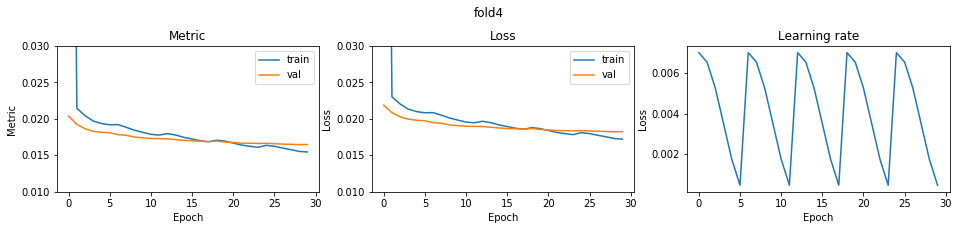

CV score: 0.0164010065822322

optimizer: Adam
fold 0


epoch1 save best model... 0.01975052493087659
epoch2 save best model... 0.01855371691337479
epoch3 save best model... 0.017829494900441386
epoch4 save best model... 0.01743406108357776
epoch5 save best model... 0.01704269276511832
epoch6 save best model... 0.01685089533618208
epoch11 save best model... 0.016477289252780837
epoch12 save best model... 0.016382541375527485
epoch18 save best model... 0.01630444444699005
epoch30 save best model... 0.016296633713134057
fold0 score: 0.016296633689665753


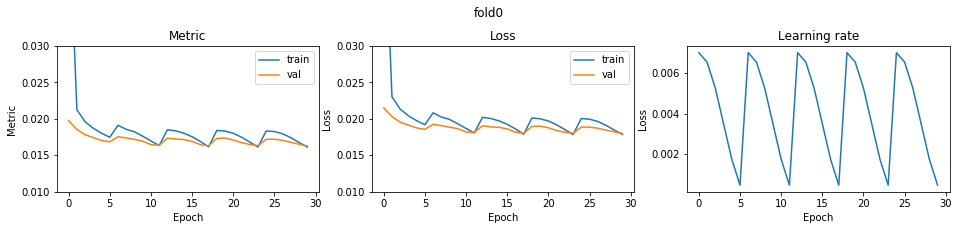

fold 1


epoch1 save best model... 0.0200947172384676
epoch2 save best model... 0.018587186937656455
epoch3 save best model... 0.0184596284233436
epoch4 save best model... 0.017617407426540225
epoch5 save best model... 0.017216341467317483
epoch6 save best model... 0.01707693277400918
epoch11 save best model... 0.016879521080734764
epoch12 save best model... 0.016626672269035903
epoch18 save best model... 0.01654896854855227
epoch30 save best model... 0.016453018810071253
fold1 score: 0.016453018648900104


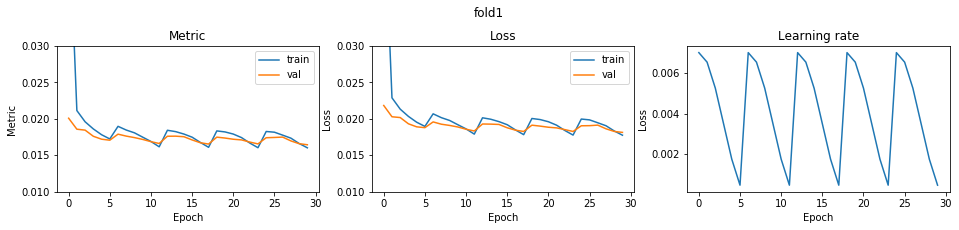

fold 2


epoch1 save best model... 0.01998682461163773
epoch2 save best model... 0.018572655246917927
epoch3 save best model... 0.018028413462262676
epoch4 save best model... 0.01758355763650655
epoch5 save best model... 0.01718830577218572
epoch6 save best model... 0.0169431688798743
epoch10 save best model... 0.016893937294264267
epoch11 save best model... 0.016619028212062507
epoch12 save best model... 0.016507379091490127
epoch18 save best model... 0.01629019561857087
epoch30 save best model... 0.016289764552872215
fold2 score: 0.01628976453170391


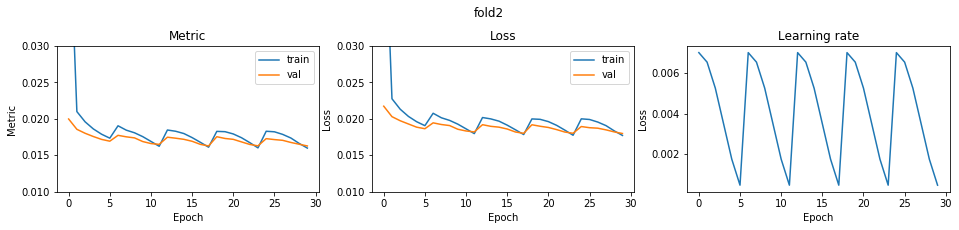

fold 3


epoch1 save best model... 0.019831097930890416
epoch2 save best model... 0.018902510173347247
epoch3 save best model... 0.01809669194407846
epoch4 save best model... 0.01765523600924531
epoch5 save best model... 0.017332384246136305
epoch6 save best model... 0.017083859266734475
epoch11 save best model... 0.01681818131671408
epoch12 save best model... 0.016624476034660954
epoch18 save best model... 0.016549836356693493
epoch24 save best model... 0.016442233936305332
fold3 score: 0.016442233919152636


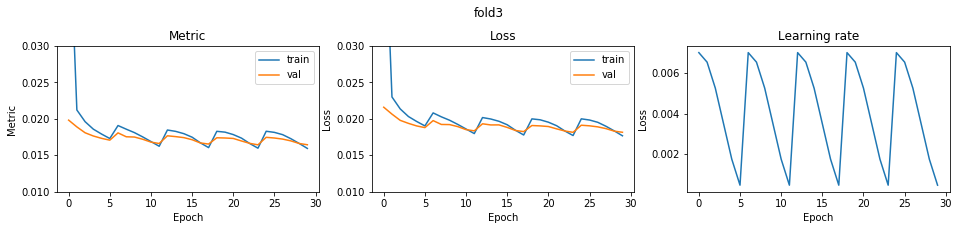

fold 4


epoch1 save best model... 0.019557459335901473
epoch2 save best model... 0.01853483830979582
epoch3 save best model... 0.017860738818103062
epoch4 save best model... 0.01744014353349228
epoch5 save best model... 0.01717946734703687
epoch6 save best model... 0.016952521639084762
epoch11 save best model... 0.016718147419698553
epoch12 save best model... 0.01655160918670594
epoch18 save best model... 0.0165421809992649
epoch24 save best model... 0.01649358373916027
epoch30 save best model... 0.016470617630809613
fold4 score: 0.016470617610739167


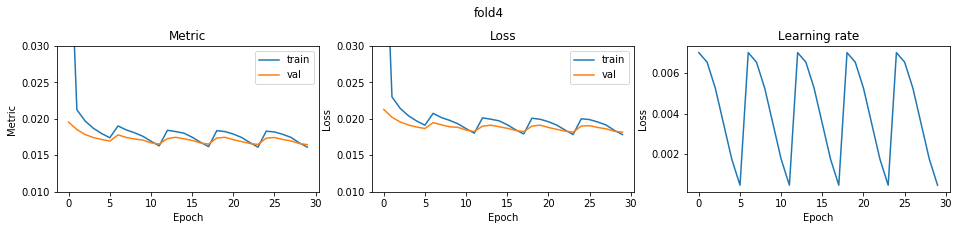

CV score: 0.016390455417055253

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.020076013649209214
epoch2 save best model... 0.018997688123061063
epoch3 save best model... 0.018041165485333202
epoch4 save best model... 0.017533082313886537
epoch5 save best model... 0.017253535662635582
epoch6 save best model... 0.017117356957871983
epoch9 save best model... 0.0168621957624556
epoch10 save best model... 0.016621149010141646
epoch11 save best model... 0.01642400373986886
epoch12 save best model... 0.016302138239416827
epoch17 save best model... 0.01621052308224464
epoch18 save best model... 0.016111883812569134
epoch24 save best model... 0.016106785219035413
fold0 score: 0.01610678500346239


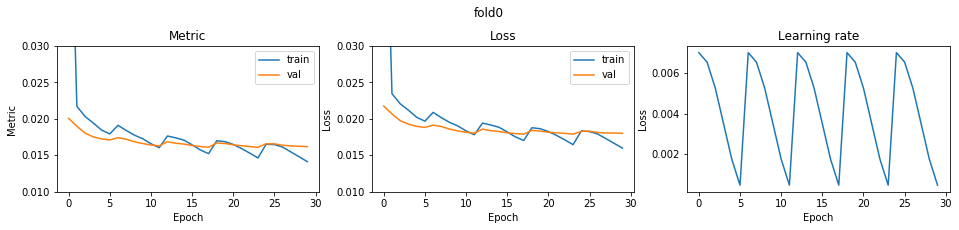

fold 1


epoch1 save best model... 0.02010999168834835
epoch2 save best model... 0.01894703550795999
epoch3 save best model... 0.01825094706699079
epoch4 save best model... 0.01776128012103857
epoch5 save best model... 0.017425351100342507
epoch6 save best model... 0.01728848302233977
epoch9 save best model... 0.017170000711435145
epoch10 save best model... 0.01686849874735225
epoch11 save best model... 0.01671925740387383
epoch12 save best model... 0.0165942919042278
epoch17 save best model... 0.016500575460305134
epoch18 save best model... 0.01642338489728695
epoch24 save best model... 0.01641454854901599
fold1 score: 0.01641454841292567


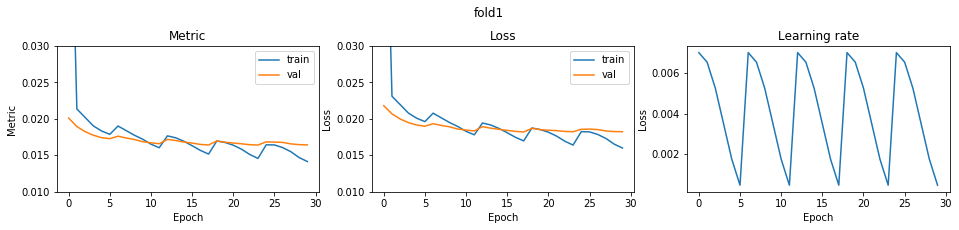

fold 2


epoch1 save best model... 0.020596112004519662
epoch2 save best model... 0.01915100672341481
epoch3 save best model... 0.01823930383597726
epoch4 save best model... 0.017696779867004808
epoch5 save best model... 0.01736527897322482
epoch6 save best model... 0.017161078229512596
epoch9 save best model... 0.017049444097737825
epoch10 save best model... 0.016729185530204155
epoch11 save best model... 0.016497394010826935
epoch12 save best model... 0.01638282737237401
epoch17 save best model... 0.016343431068572865
epoch18 save best model... 0.016217627724062666
epoch24 save best model... 0.016208725279262027
epoch30 save best model... 0.016180963705954395
fold2 score: 0.016180963489102782


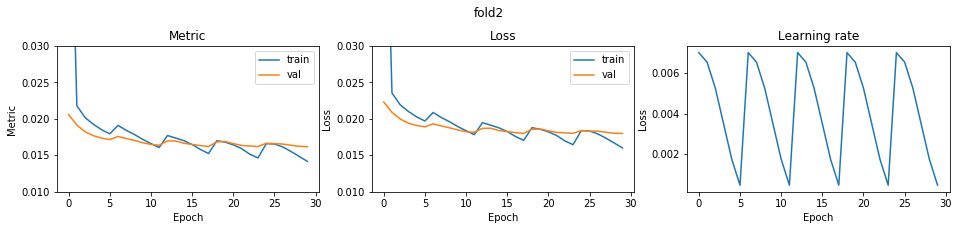

fold 3


epoch1 save best model... 0.02041545302218891
epoch2 save best model... 0.019189732276106885
epoch3 save best model... 0.01832412044413744
epoch4 save best model... 0.017877363226883505
epoch5 save best model... 0.017514644137208175
epoch6 save best model... 0.01737807410724614
epoch9 save best model... 0.01714265500672654
epoch10 save best model... 0.016894554956508524
epoch11 save best model... 0.01671473138195575
epoch12 save best model... 0.016576885315324422
epoch17 save best model... 0.016501733037411894
epoch18 save best model... 0.016374823574511366
epoch24 save best model... 0.01636695781243214
fold3 score: 0.01636695775961218


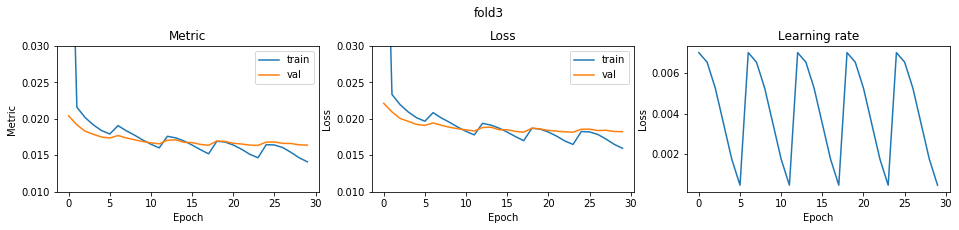

fold 4


epoch1 save best model... 0.020038779719747553
epoch2 save best model... 0.018906288674623115
epoch3 save best model... 0.01796652785245677
epoch4 save best model... 0.01751340971601987
epoch5 save best model... 0.017244371959774126
epoch6 save best model... 0.01713094470941871
epoch9 save best model... 0.016934705929987658
epoch10 save best model... 0.016719794100689318
epoch11 save best model... 0.01659986451098479
epoch12 save best model... 0.01650444875197625
epoch17 save best model... 0.016439119543124985
epoch18 save best model... 0.016363503361345694
epoch24 save best model... 0.016359655529786757
fold4 score: 0.016359655439831484


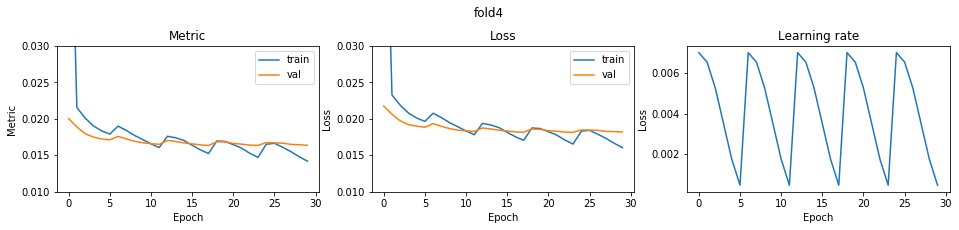

CV score: 0.0162857809298688

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.020744977996669762
epoch2 save best model... 0.019444279485553977
epoch3 save best model... 0.018729687522002124
epoch4 save best model... 0.018145255416903247
epoch5 save best model... 0.017855648862745332
epoch6 save best model... 0.01769424379041635
epoch7 save best model... 0.017653955417369114
epoch8 save best model... 0.017223954069213877
epoch9 save best model... 0.017023455939660856
epoch10 save best model... 0.016758750398178715
epoch11 save best model... 0.016569028636079987
epoch12 save best model... 0.016545309982599864
epoch15 save best model... 0.016375253690673986
epoch16 save best model... 0.016289779391979845
epoch17 save best model... 0.016194059908525817
epoch18 save best model... 0.01611586322791552
fold0 score: 0.01611586322284582


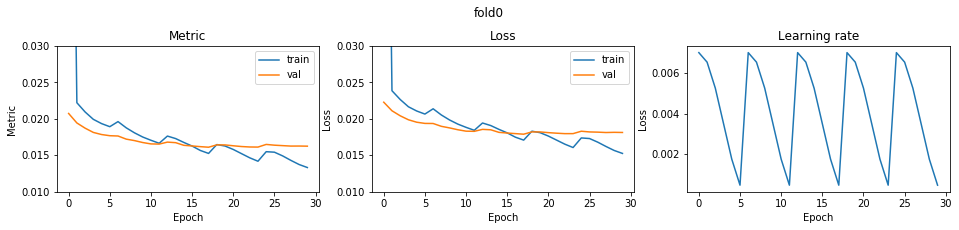

fold 1


epoch1 save best model... 0.020615681190205806
epoch2 save best model... 0.019619931234948644
epoch3 save best model... 0.018751650279242266
epoch4 save best model... 0.018227384960218182
epoch5 save best model... 0.018007798364403364
epoch6 save best model... 0.0178617421574984
epoch7 save best model... 0.01785131383625297
epoch8 save best model... 0.017642112804449862
epoch9 save best model... 0.01722655177420257
epoch10 save best model... 0.017079691750825632
epoch11 save best model... 0.01684913556750352
epoch12 save best model... 0.0167475391805722
epoch16 save best model... 0.01662148363777074
epoch17 save best model... 0.016448306226175585
epoch18 save best model... 0.016413468909342716
fold1 score: 0.016413468902128543


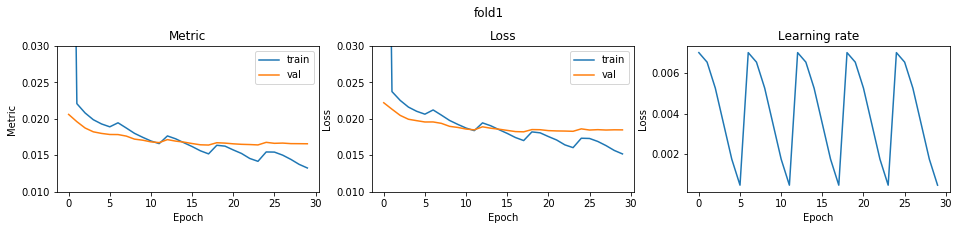

fold 2


epoch1 save best model... 0.020769312091665732
epoch2 save best model... 0.019662132326281813
epoch3 save best model... 0.01872545828006009
epoch4 save best model... 0.01832735692472366
epoch5 save best model... 0.01787999293735723
epoch6 save best model... 0.017811113595028866
epoch7 save best model... 0.01770414108986374
epoch8 save best model... 0.01740259466610898
epoch9 save best model... 0.017038541124515298
epoch10 save best model... 0.01679894226115374
epoch11 save best model... 0.016665741119904695
epoch12 save best model... 0.01658166391619261
epoch16 save best model... 0.016388196503672656
epoch17 save best model... 0.01628907309901534
epoch18 save best model... 0.016227095001681666
epoch23 save best model... 0.016215695569656262
epoch24 save best model... 0.016168676618479004
fold2 score: 0.016168676609878887


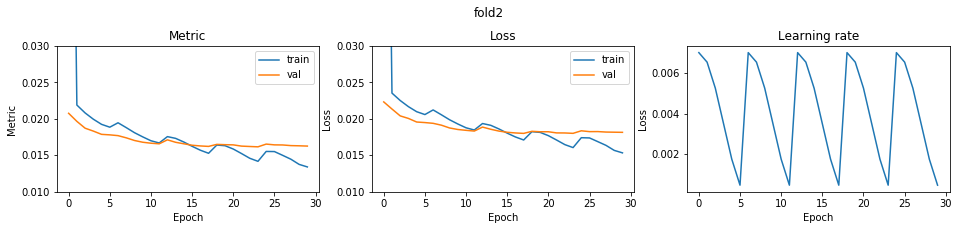

fold 3


epoch1 save best model... 0.020930852066377573
epoch2 save best model... 0.019600540364335093
epoch3 save best model... 0.018818254765029786
epoch4 save best model... 0.018418443976458084
epoch5 save best model... 0.018063418781024177
epoch6 save best model... 0.017981676682235846
epoch8 save best model... 0.017513668516773842
epoch9 save best model... 0.017285891946888867
epoch10 save best model... 0.01701702442665103
epoch11 save best model... 0.016843008770181
epoch12 save best model... 0.016771392900590067
epoch15 save best model... 0.016735317997193147
epoch16 save best model... 0.0165953872581108
epoch17 save best model... 0.016410808742114244
epoch18 save best model... 0.016370768289682126
epoch24 save best model... 0.016337920447433863
fold3 score: 0.01633792038486239


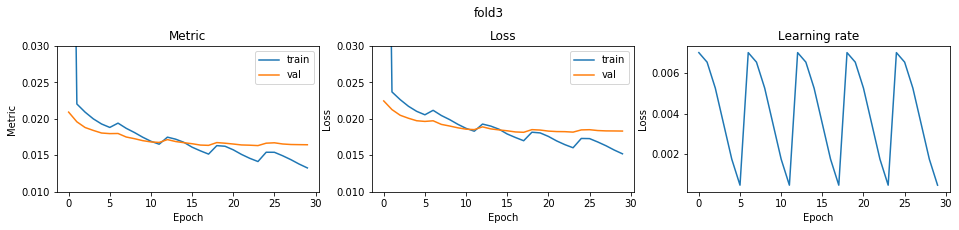

fold 4


epoch1 save best model... 0.020558003931898192
epoch2 save best model... 0.019402836106191465
epoch3 save best model... 0.018564943779166575
epoch4 save best model... 0.018160144500179824
epoch5 save best model... 0.017845234040654603
epoch6 save best model... 0.017764148164056835
epoch8 save best model... 0.017430738891752815
epoch9 save best model... 0.017160721919191727
epoch10 save best model... 0.016884058323139346
epoch11 save best model... 0.016783724813075027
epoch12 save best model... 0.016695103571582628
epoch15 save best model... 0.016608369756057215
epoch16 save best model... 0.0165965348070568
epoch17 save best model... 0.016393565522731707
epoch18 save best model... 0.01638228674472261
epoch23 save best model... 0.016340488822099694
epoch24 save best model... 0.016314744040930054
fold4 score: 0.016314743950719458


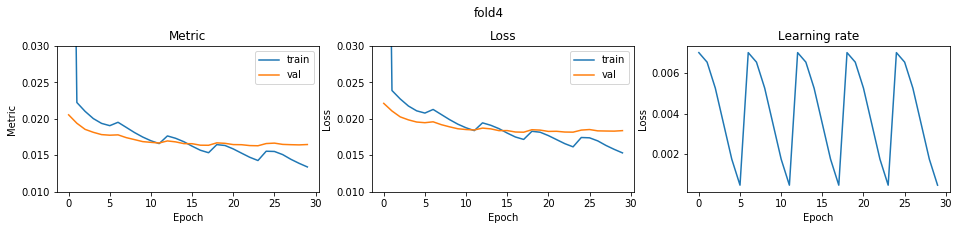

CV score: 0.01627013270610981

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.022127158718357597
epoch2 save best model... 0.020141324563830207
epoch3 save best model... 0.019484405614147153
epoch4 save best model... 0.019054473281449772
epoch5 save best model... 0.018936763165819888
epoch6 save best model... 0.018875734924693043
epoch7 save best model... 0.018486750986350695
epoch8 save best model... 0.018211008076278117
epoch9 save best model... 0.017930668903883878
epoch10 save best model... 0.017855910699738187
epoch11 save best model... 0.017772528083659794
epoch12 save best model... 0.01774407132933922
epoch13 save best model... 0.01762118800744788
epoch14 save best model... 0.01747197459509134
epoch15 save best model... 0.01735251591814542
epoch16 save best model... 0.01729723478758661
epoch17 save best model... 0.017227157532897247
epoch18 save best model... 0.017195997275157505
epoch19 save best model... 0.01717612010114964
epoch20 save best model... 0.01709999499464904
epoch21 save best model... 0.017049527360054245
epoch22 

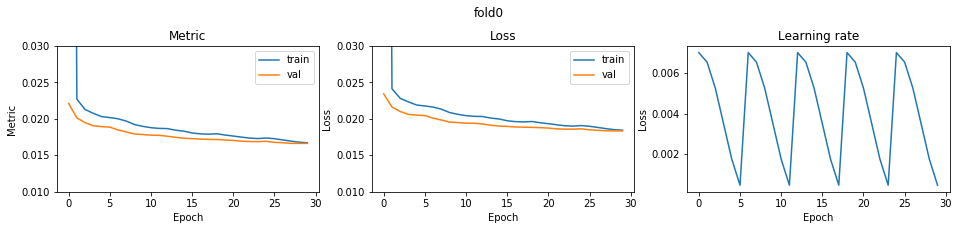

fold 1


epoch1 save best model... 0.022117305053434087
epoch2 save best model... 0.02034823791781518
epoch3 save best model... 0.019775126762153428
epoch4 save best model... 0.019338225937766945
epoch5 save best model... 0.019149063555254267
epoch6 save best model... 0.019115670246540428
epoch7 save best model... 0.018642988191749057
epoch8 save best model... 0.018420850344581113
epoch9 save best model... 0.018198949717092173
epoch10 save best model... 0.018162720419736406
epoch11 save best model... 0.01794909260739265
epoch13 save best model... 0.01784754589821326
epoch14 save best model... 0.017697982502794397
epoch15 save best model... 0.01764942104738281
epoch16 save best model... 0.017548923295158465
epoch17 save best model... 0.017476061639569294
epoch18 save best model... 0.017459899963720646
epoch19 save best model... 0.017456479723686018
epoch20 save best model... 0.017314145213349938
epoch21 save best model... 0.017308239610541055
epoch22 save best model... 0.017228619608663974
epoch

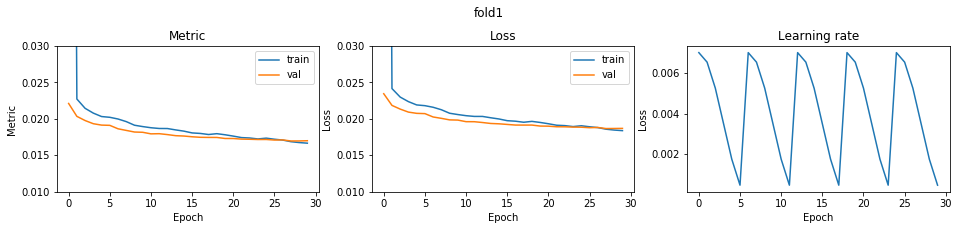

fold 2


epoch1 save best model... 0.02218978372049185
epoch2 save best model... 0.020212743526392955
epoch3 save best model... 0.01948357803764458
epoch4 save best model... 0.019234787021744738
epoch5 save best model... 0.019022434892582308
epoch6 save best model... 0.018945804041063195
epoch7 save best model... 0.018485085654636264
epoch8 save best model... 0.018240596563486335
epoch9 save best model... 0.01804854253132561
epoch10 save best model... 0.017868476733735088
epoch11 save best model... 0.01778879182849917
epoch12 save best model... 0.01776877249168573
epoch14 save best model... 0.017563491213899534
epoch15 save best model... 0.017409674152324483
epoch16 save best model... 0.017301691049914896
epoch17 save best model... 0.01728194222018873
epoch19 save best model... 0.01722926882070808
epoch20 save best model... 0.017162720184526213
epoch21 save best model... 0.017102961171707863
epoch22 save best model... 0.016974646036421268
epoch23 save best model... 0.016956084111854383
epoch25 

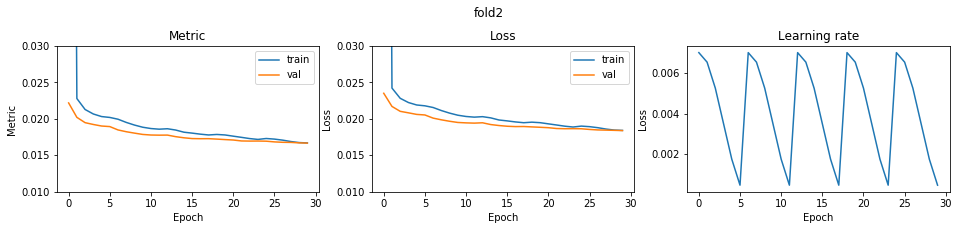

fold 3


epoch1 save best model... 0.022257286742974523
epoch2 save best model... 0.020401098139601035
epoch3 save best model... 0.019766837952908865
epoch4 save best model... 0.019414576240189392
epoch5 save best model... 0.01921746989835164
epoch6 save best model... 0.019210490294157237
epoch7 save best model... 0.01871039542774744
epoch8 save best model... 0.018407594591192476
epoch9 save best model... 0.018116677014458425
epoch10 save best model... 0.01807606840391637
epoch11 save best model... 0.017944788617126492
epoch13 save best model... 0.01788064674145472
epoch14 save best model... 0.017739776778193977
epoch15 save best model... 0.01760892363133626
epoch16 save best model... 0.017525076163521117
epoch17 save best model... 0.017463977188550802
epoch19 save best model... 0.017375643673970244
epoch20 save best model... 0.017340656075889672
epoch21 save best model... 0.017267598039926727
epoch22 save best model... 0.0172567653344575
epoch23 save best model... 0.01719718843970049
epoch24 s

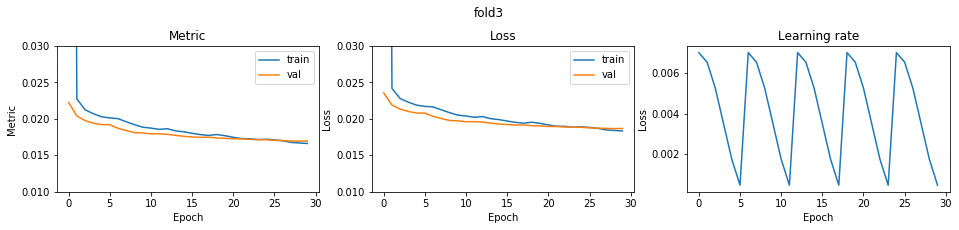

fold 4


epoch1 save best model... 0.02184068981413825
epoch2 save best model... 0.019901811459646954
epoch3 save best model... 0.019365115714914977
epoch4 save best model... 0.019041265468357094
epoch5 save best model... 0.018818697958743382
epoch6 save best model... 0.018779087968696765
epoch7 save best model... 0.01845962704161441
epoch8 save best model... 0.018159175765592443
epoch9 save best model... 0.01795473605190703
epoch10 save best model... 0.017844461851619642
epoch11 save best model... 0.017714990064043527
epoch13 save best model... 0.01764666204953859
epoch14 save best model... 0.017491994709506256
epoch15 save best model... 0.017406525199380036
epoch16 save best model... 0.01731344921501663
epoch17 save best model... 0.01726137947817259
epoch18 save best model... 0.01723981682075387
epoch20 save best model... 0.017189653155421477
epoch21 save best model... 0.017109469205124097
epoch22 save best model... 0.017054313808204373
epoch23 save best model... 0.017051540352488976
epoch24 

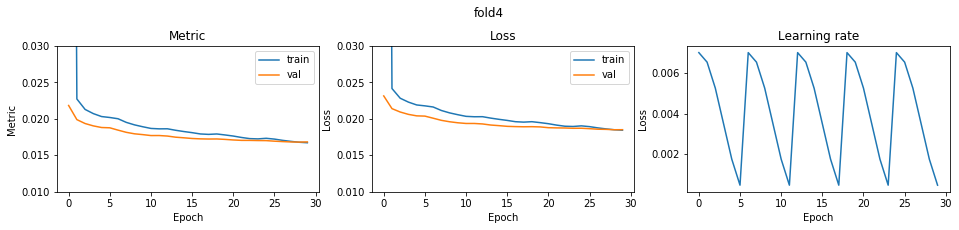

CV score: 0.016812053971256555

optimizer: RangerLars
fold 0


epoch1 save best model... 0.021717128859395862
epoch2 save best model... 0.01988850074707783
epoch3 save best model... 0.018814833414717524
epoch4 save best model... 0.018195401709993498
epoch5 save best model... 0.01781167646186906
epoch6 save best model... 0.0177061028193029
epoch8 save best model... 0.01742283415074772
epoch9 save best model... 0.017021803336391958
epoch10 save best model... 0.016813931249268776
epoch11 save best model... 0.016597223271677324
epoch12 save best model... 0.016539821370689364
epoch15 save best model... 0.016381181212638533
epoch16 save best model... 0.01627424420037886
epoch17 save best model... 0.016167140012534848
epoch18 save best model... 0.016110894139983387
fold0 score: 0.016110894016864632


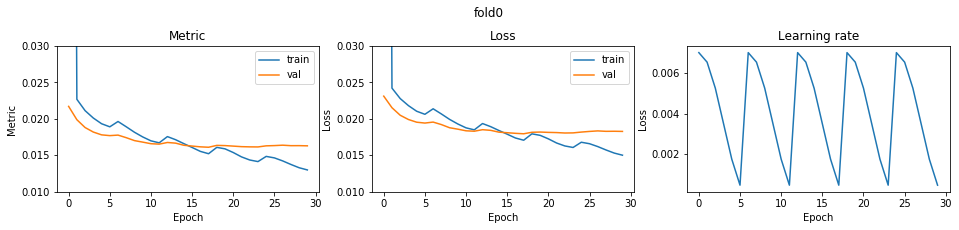

fold 1


epoch1 save best model... 0.022754972169545386
epoch2 save best model... 0.019864832038154468
epoch3 save best model... 0.018962746943983953
epoch4 save best model... 0.0182959349284033
epoch5 save best model... 0.018046604621774327
epoch6 save best model... 0.01790348798720691
epoch8 save best model... 0.017611173817395187
epoch9 save best model... 0.017314173130534537
epoch10 save best model... 0.01699841899746818
epoch11 save best model... 0.016820967427437276
epoch12 save best model... 0.01674429952799527
epoch15 save best model... 0.016681539145798868
epoch16 save best model... 0.016576274157021984
epoch17 save best model... 0.016456578369512323
epoch23 save best model... 0.016449038790635244
epoch24 save best model... 0.016437609912350173
fold1 score: 0.016437609796344954


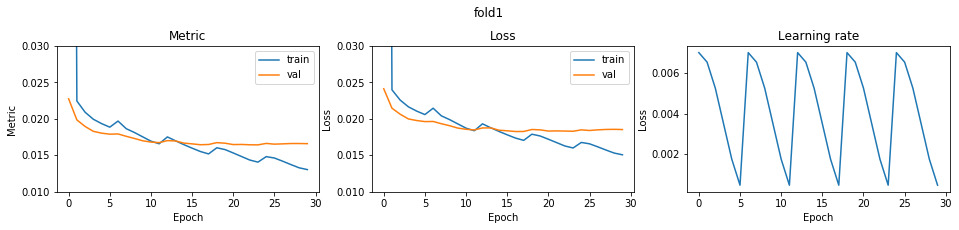

fold 2


epoch1 save best model... 0.021663230659444827
epoch2 save best model... 0.01993497318103757
epoch3 save best model... 0.01896894749849831
epoch4 save best model... 0.018362947555687927
epoch5 save best model... 0.01799298999404569
epoch6 save best model... 0.017834277722774905
epoch7 save best model... 0.017821836251978532
epoch8 save best model... 0.017560200281076237
epoch9 save best model... 0.017189274474131367
epoch10 save best model... 0.016985065952846497
epoch11 save best model... 0.016824878093579222
epoch12 save best model... 0.016693341359665874
epoch15 save best model... 0.016506978990516473
epoch16 save best model... 0.016392041051641063
epoch17 save best model... 0.016308618933947
epoch18 save best model... 0.016233935832720963
epoch24 save best model... 0.016211897877886752
fold2 score: 0.016211897881661164


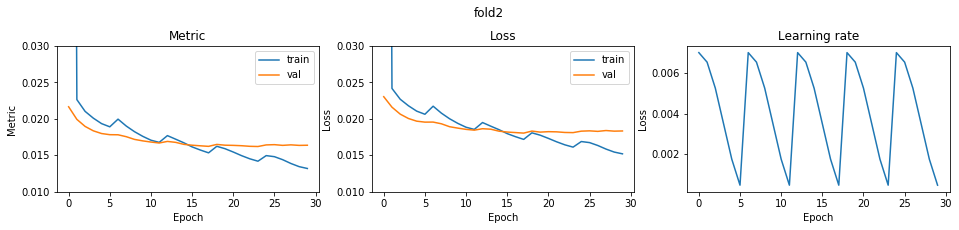

fold 3


epoch1 save best model... 0.021515905758650266
epoch2 save best model... 0.019799665089671188
epoch3 save best model... 0.018932849779334727
epoch4 save best model... 0.01838323081035277
epoch5 save best model... 0.018073061129379515
epoch6 save best model... 0.01785466499363575
epoch8 save best model... 0.017711644781358827
epoch9 save best model... 0.017296259910088874
epoch10 save best model... 0.017000959585749615
epoch11 save best model... 0.016837940183054477
epoch12 save best model... 0.016754832652085598
epoch15 save best model... 0.016667268656041463
epoch16 save best model... 0.016544495528067433
epoch17 save best model... 0.016454225230817777
epoch18 save best model... 0.016428568683021567
epoch23 save best model... 0.01641274271235888
epoch24 save best model... 0.016410299331577737
fold3 score: 0.0164102992156989


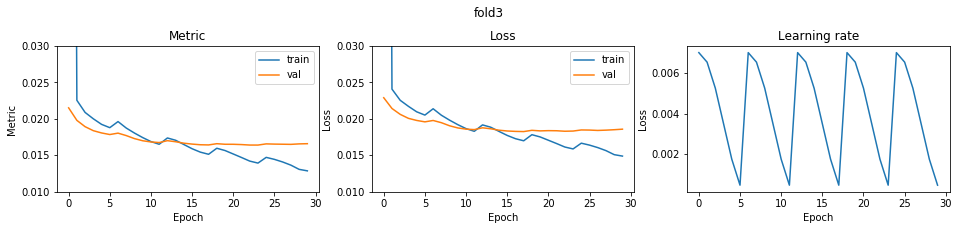

fold 4


epoch1 save best model... 0.0214974702371959
epoch2 save best model... 0.019509528549324407
epoch3 save best model... 0.018658032666272344
epoch4 save best model... 0.01816325535730444
epoch5 save best model... 0.01778092606328343
epoch6 save best model... 0.017665705780216527
epoch8 save best model... 0.017331309924177946
epoch9 save best model... 0.01708370248292804
epoch10 save best model... 0.016903826220975107
epoch11 save best model... 0.01669810442147874
epoch12 save best model... 0.01664131993304828
epoch15 save best model... 0.016535841936674095
epoch16 save best model... 0.016434268154848816
epoch17 save best model... 0.016382805863501406
epoch18 save best model... 0.016340137234462558
fold4 score: 0.01634013698050539


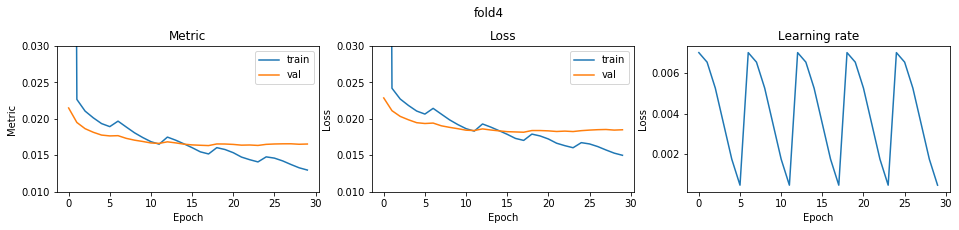

CV score: 0.01630216552005383


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'Adam_CG': 0.016396362264699666,
 'AdamW_CG': 0.016314534675922563,
 'PlainRAdam_CG': 0.02140447845220047,
 'RAdam_CG': 0.016324196236624657,
 'Ranger_CG': 0.016361620745457453,
 'AggMo': 0.018786278857253133,
 'Apollo': 0.4763897836270182,
 'PID': 0.47579545794882133,
 'QHM': 0.4811514943524021,
 'SGDP': 0.47799837228072856,
 'SGDW': 0.4861040919653987,
 'SGD': 0.4836009258069798,
 'AdaBelief': 0.0162745285072102,
 'AdaBound': 0.020450509219767894,
 'AdaMod': 0.016231761606118663,
 'AdamW': 0.016255911537726854,
 'AdamP': 0.016238598566829007,
 'DiffGrad': 0.016277239869719032,
 'Lamb': 0.01636294934466916,
 'NovoGrad': 0.01626058199716189,
 'PlainRAdam': 0.016271052405565322,
 'QHAdam': 0.016380871193075037,
 'RAdam': 0.01627195754513506,
 'Ranger': 0.016271863684299916,
 'RangerQH': 0.0162721517705364,
 'RangerVA': 0.018749587566830036,
 'SWATS': 0.016304066538455994,
 'Yogi': 0.016401006582232137,
 'Adam': 0.016390455417055153,
 'LookaheadAdam': 0.01628578092986881,
 'LookaheadDif

In [26]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
Adam_CG            0.016396
AdamW_CG           0.016315
PlainRAdam_CG      0.021404
RAdam_CG           0.016324
Ranger_CG          0.016362
AggMo              0.018786
Apollo             0.476390
PID                0.475795
QHM                0.481151
SGDP               0.477998
SGDW               0.486104
SGD                0.483601
AdaBelief          0.016275
AdaBound           0.020451
AdaMod             0.016232
AdamW              0.016256
AdamP              0.016239
DiffGrad           0.016277
Lamb               0.016363
NovoGrad           0.016261
PlainRAdam         0.016271
QHAdam             0.016381
RAdam              0.016272
Ranger             0.016272
RangerQH           0.016272
RangerVA           0.018750
SWATS              0.016304
Yogi               0.016401
Adam               0.016390
LookaheadAdam      0.016286
LookaheadDiffGrad  0.016270
LookaheadYogi      0.016812
RangerLars         0.016302

In [27]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
Adam_CG            0.016396
AdamW_CG           0.016315
PlainRAdam_CG      0.021404
RAdam_CG           0.016324
Ranger_CG          0.016362
AggMo              0.018786
Apollo             0.476390
PID                0.475795
QHM                0.481151
SGDP               0.477998
SGDW               0.486104
SGD                0.483601
AdaBelief          0.016275
AdaBound           0.020451
AdaMod             0.016232
AdamW              0.016256
AdamP              0.016239
DiffGrad           0.016277
Lamb               0.016363
NovoGrad           0.016261
PlainRAdam         0.016271
QHAdam             0.016381
RAdam              0.016272
Ranger             0.016272
RangerQH           0.016272
RangerVA           0.018750
SWATS              0.016304
Yogi               0.016401
Adam               0.016390
LookaheadAdam      0.016286
LookaheadDiffGrad  0.016270
LookaheadYogi      0.016812
RangerLars         0.016302


In [28]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [29]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
AdaMod             0.016232
AdamP              0.016239
AdamW              0.016256
NovoGrad           0.016261
LookaheadDiffGrad  0.016270
PlainRAdam         0.016271
Ranger             0.016272
RAdam              0.016272
RangerQH           0.016272
AdaBelief          0.016275
DiffGrad           0.016277
LookaheadAdam      0.016286
RangerLars         0.016302
SWATS              0.016304
AdamW_CG           0.016315
RAdam_CG           0.016324
Ranger_CG          0.016362
Lamb               0.016363
QHAdam             0.016381
Adam               0.016390
Adam_CG            0.016396
Yogi               0.016401
LookaheadYogi      0.016812
RangerVA           0.018750
AggMo              0.018786
AdaBound           0.020451
PlainRAdam_CG      0.021404
PID                0.475795
Apollo             0.476390
SGDP               0.477998
QHM                0.481151
SGD                0.483601
SGDW               0.486104

In [30]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
AdaMod             0.016232
AdamP              0.016239
AdamW              0.016256
NovoGrad           0.016261
LookaheadDiffGrad  0.016270
PlainRAdam         0.016271
Ranger             0.016272
RAdam              0.016272
RangerQH           0.016272
AdaBelief          0.016275
DiffGrad           0.016277
LookaheadAdam      0.016286
RangerLars         0.016302
SWATS              0.016304
AdamW_CG           0.016315
RAdam_CG           0.016324
Ranger_CG          0.016362
Lamb               0.016363
QHAdam             0.016381
Adam               0.016390
Adam_CG            0.016396
Yogi               0.016401
LookaheadYogi      0.016812
RangerVA           0.018750
AggMo              0.018786
AdaBound           0.020451
PlainRAdam_CG      0.021404
PID                0.475795
Apollo             0.476390
SGDP               0.477998
QHM                0.481151
SGD                0.483601
SGDW               0.486104


In [36]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')